# Generate Flow-Centric DCN Benchmark Traffic

In this example, we will use `TrafPy` to generate the flow-centric data centre network benchmark traffic traces (University, Private Enterprise, Commercial Cloud, and Social Media Cloud) for a custom network topology. We will then save these traffic traces as .pickle files, which can then be imported into any simulation, emulation, or experimentation environment/test bed independently of `TrafPy`. We will also organise the demonstrated traffic into time slots and generate an sqlite data base which we can save to our disk and access during a simulation, thereby enabling us to scale to very large simulation sizes.

To do this, we will need to use the `trafpy.generator` and `trafpy.benchmarker` modules.

In [24]:
import trafpy.generator as tpg
from trafpy.benchmarker import BenchmarkImporter

## 1. Define the Network

Consider that you have a network with $n_{n}=64$ end points/machines/leaf nodes, and that you've defined your network externally to TrafPy, but you would like to use TrafPy to generate the University, Private Enterprise, Commercial Cloud, and Social Media Cloud traffic traces for your network. Regardless of your network's topology, we can use the `trafpy.generator.gen_arbitrary_network()` function to initialise an arbitrary representation of your network which TrafPy can recognise and create traffic data for.

Start by setting how many end points are in your network:

In [25]:
num_eps = 64

### (Optional) End Point Clusters/Racks
In the context of data centre networks, it is common to cluster end points/machines into *racks*. This can lead to varying levels of end point and end point pair traffic loads (e.g. inter vs. intra-rack traffic load). `TrafPy` lets you group your end points into racks by providing a `racks_dict` dictionary which maps racks (keys) to the list of end points (values) within each rack. If your network did not have any clustering/racks, you could simply set `racks_dict=None`, but consider that your $n_{n}=64$ network has 8 servers per rack (8 racks overall).

In [26]:
racks_dict, num_racks = {}, 8
eps_per_rack = int(num_eps/num_racks)
for rack in range(num_racks):
    racks_dict[rack] = [ep for ep in range(rack*eps_per_rack, (rack*eps_per_rack)+eps_per_rack)]
print(racks_dict)

{0: [0, 1, 2, 3, 4, 5, 6, 7], 1: [8, 9, 10, 11, 12, 13, 14, 15], 2: [16, 17, 18, 19, 20, 21, 22, 23], 3: [24, 25, 26, 27, 28, 29, 30, 31], 4: [32, 33, 34, 35, 36, 37, 38, 39], 5: [40, 41, 42, 43, 44, 45, 46, 47], 6: [48, 49, 50, 51, 52, 53, 54, 55], 7: [56, 57, 58, 59, 60, 61, 62, 63]}


### Network Bandwidth Capacity

Each link in your network will have (1) some bandwidth capacity per link channel (the maximum rate of information transfer per unit time on each channel) $C_{c}$, and (2) some number of channels per link $n_{c}$. `TrafPy` will assume that your links are *bidirectional*, meaning traffic can simultaneously be outbound and inbound from/to a given end point, therefore each link channel's bandwidth is split between the end points' transceiver (source) and receiver (destination) port. Consider that your network has link channel capacity $C_{c}=1250$ and $n_{c}=1$ channels:

In [27]:
ep_capacity = 1250

You can now initialise your network in a format recognised by `TrafPy` using the `trafpy.generator.gen_arbitrary_network()` function:

In [28]:
net = tpg.gen_arbitrary_network(num_eps=num_eps, ep_capacity=ep_capacity, racks_dict=racks_dict)

The *total network capacity* $C_{t}$ is the maximum amount of information which can be transmitted through the entire network per unit time. If 2 end points are connected, the most amount of information they can transfer along a single channel per unit time is the end point bandwidth capacity per channel $C_{c}$ (*not* $2 \cdot C_{c}$), therefore the network's total capacity $C_{t}$ can be evaluated as:

\begin{equation}
    C_{t} = \frac{n_{n} \cdot C_{c} \cdot n_{c}}{2}
\end{equation}

All `TrafPy` networks and graphs are `NetworkX` graphs (see [here](https://networkx.org/documentation/stable/tutorial.html) for details) which can be treated as Python dictionaries. All `TrafPy` networks have the following 'global' graph keys:

In [29]:
print(net.graph.keys())
print(net.graph['topology_type'])

dict_keys(['endpoints', 'endpoint_label', 'num_channels_per_link', 'ep_link_capacity', 'ep_link_port_capacity', 'max_nw_capacity', 'curr_nw_capacity_used', 'num_active_connections', 'total_connections_blocked', 'node_labels', 'topology_type', 'channel_names', 'rack_to_ep_dict', 'ep_to_rack_dict'])
arbitrary_endpoints_64_chancap_1250_channels_1


Notice that TrafPy has automatically evaluated the maximum capacity of your network:

In [30]:
print(net.graph['max_nw_capacity'])
print(net.graph['topology_type'])

40000.0
arbitrary_endpoints_64_chancap_1250_channels_1


Notice also that all references to capacity have been unitless. $C_{c}=1250$ could refer to e.g. 1250 B/s, 1250 $\mu$B/ms, 1250 Gbps, and so on. This is intentional, and allows you to plug in whatever values you find convenient. Just ensure the information and time units you use are consistent.

## 2. Define the Load Configuration

The network load refers to the overall amount of traffic received by the network. This is commonly referred to as a load rate (information units arriving per unit time) or as a load fraction (the fraction of the total network capacity being requested for a given duration). `TrafPy` typically uses the load fraction definition for load, therefore loads can be varied between 0 and 1.

A key feature of `TrafPy` is that you can generate any load for your custom network. To do this, you should provide `TrafPy` with a `network_load_config` dictionary which tells `TrafPy` (1) the end point capacity of your network, (2) the maximum capacity of your network, and (3) the overall load fraction you would like `TrafPy` to generate for your network. Consider that you would like `TrafPy` to generate a 0.1 load traffic trace for your network (i.e. around 10% of your total network capacity will be requested per unit time):

In [41]:
network_load_config = {'network_rate_capacity': net.graph['max_nw_capacity'], 
                       'ep_link_capacity': net.graph['ep_link_capacity'],
                       'target_load_fraction': 0.6}

## 3. Load the TrafPy Benchmarks

The `trafpy.benchmarker.BenchmarkImporter` can be used to load pre-defined `TrafPy` benchmarks which are compatible with the end points we previously defined for our custom network.

`TrafPy` is able to generate arbitrary distributions and therefore arbitrary traffic traces. As the nature of applications handled by real data centres changes, so too will the resultant traffic traces. Therefore, the initial benchmarks established for `TrafPy` have been stored under `benchmark_version='v001'` with the anticipation that future benchmark versions will be established with new and evolving traffic traces.

In [42]:
importer = BenchmarkImporter(benchmark_version='v001', load_prev_dists=False)

load_prev_dist=False. Will re-generate dists with given network params and override any previously saved distributions.


We can now import the University, Private Enterprise, Commercial Cloud, and Social Media Cloud `TrafPy` benchmark distributions adapted for our network's endpoints:

In [43]:
dcn_dists = {}
for dcn in ['university', 'private_enterprise', 'commercial_cloud', 'social_media_cloud']:
    dcn_dists[dcn] = importer.get_benchmark_dists(benchmark_name=dcn, 
                                                  eps=net.graph['endpoints'], 
                                                  racks_dict=net.graph['rack_to_ep_dict'])

Set to save benchmark university distribution data to /home/zciccwf/phd_project/projects/trafpy/trafpy/benchmarker/versions/benchmark_v001/benchmarks/university/
Saved node_dist distribution data to /home/zciccwf/phd_project/projects/trafpy/trafpy/benchmarker/versions/benchmark_v001/benchmarks/university/
Saved flow_size_dist distribution data to /home/zciccwf/phd_project/projects/trafpy/trafpy/benchmarker/versions/benchmark_v001/benchmarks/university/
Saved interarrival_time_dist distribution data to /home/zciccwf/phd_project/projects/trafpy/trafpy/benchmarker/versions/benchmark_v001/benchmarks/university/
Set to save benchmark private_enterprise distribution data to /home/zciccwf/phd_project/projects/trafpy/trafpy/benchmarker/versions/benchmark_v001/benchmarks/private_enterprise/
Saved node_dist distribution data to /home/zciccwf/phd_project/projects/trafpy/trafpy/benchmarker/versions/benchmark_v001/benchmarks/private_enterprise/
Saved flow_size_dist distribution data to /home/zciccw

Each benchmark contains the following distributions (stored as dictionaries with key (distribution name) value (distribution hash table) pairs):

In [44]:
print(list(dcn_dists['university'].keys()))

['node_dist', 'flow_size_dist', 'interarrival_time_dist', 'num_ops_dist']


For flow-centric traffic, we only need to worry about flow size, inter-arrival time, and node distributions.

32## 4. (Optional) Define Additional Trace Parameters

`TrafPy` generates traffic trace data for your network using the `trafpy.generator.create_demand_data()` function. This function has some useful additional parameters you can define to further customise the trace generated for your network (see documentation for details).

An important parameter in `TrafPy` traffic generation is the `jensen_shannon_distance_threshold`. Since `TrafPy` traffic data are generated by sampling from some pre-defined distributions, how similar the sampled data are to the original distributions will depend on the number of demands generated/sampled by the law of large numbers. `TrafPy` lets you set the `jensen_shannon_distance_threshold`, which must be between 0 and 1. A lower value will result in more demands being generated and therefore a data set more similar to the original distributions (in the example, benchmarks) you are sampling from, whereas a higher value will be less reliably similar but will result in fewer demands (which can reduce the memory and time size of your tests).

Other useful additional parameters include `min_last_demand_arrival_time`, `min_num_demands`, and `max_num_demands`. See documentation for details.

Here, we will set `jensen_shannon_distance_threshold=0.9` (a high value so that we don't generate many demands and therefore save time).

In [45]:
jsd_threshold = 0.9

## 5. Generate the Traffic Traces

With our network defined and our benchmark distributions loaded, we are now ready to generate some traffic for our custom network using the `trafpy.generator.create_demand_data()` function. We will save our traffic into separate .pickle files. These files can then be imported into your own simulation, emulation, and/or experimentation test beds to test your own systems under these `TrafPy` benchmarks.

In [46]:
from pathlib import Path
import gzip
import pickle
import time

path_to_data = 'data/generate_flow_benchmark_traffic/'
Path(path_to_data).mkdir(exist_ok=True, parents=True)
for dcn in dcn_dists.keys():
    print('Generating \'{}\' traffic demands for {} network'.format(dcn, net.graph['topology_type']))
    time.sleep(1)
    
    # get node, flow size, and flow inter-arrival time benchmark dists
    dists = dcn_dists[dcn]
    
    # generate traffic demands
    demand_data = tpg.create_demand_data(eps=net.graph['endpoints'],
                                         node_dist=dists['node_dist'],
                                         flow_size_dist=dists['flow_size_dist'],
                                         interarrival_time_dist=dists['interarrival_time_dist'],
                                         network_load_config=network_load_config,
                                         jensen_shannon_distance_threshold=jsd_threshold)
    
    # save demands as pickle file
    filename = path_to_data+'{}_demand_data.pickle'.format(dcn)
    with gzip.open(filename, 'wb') as f:
        pickle.dump(demand_data, f)

Generating 'university' traffic demands for arbitrary_endpoints_64_chancap_1250_channels_1 network


Packing flows:   0%|          | 0/6000 [00:00<?, ?it/s]

Exception: Unable to find valid pair to assign flow flow_0: {'size': 14994750.0, 'src': None, 'dst': None} without exceeding ep total information load limit 14698575.83333335 information units for this session. Increase number of flows to increase time duration the flow packer has to pack flows into (recommended), and/or decrease flow sizes to help with packing (recommended), and/or increase end point link capacity (recommended), and/or decrease your required target load to increase the time duration the flow packer has to pack flows into, and/or change your node dist to be less heavily skewed. Alternatively, try re-running dist and flow generator since may have chance of creating valid dists and flows which can be packed (also recommended). You can also disable this validity checker by setting check_dont_exceed_one_ep_load to False. Doing so will allow end point loads to go above 1.0 when packing the flows and disable this exception being raised. Current end point total information loads (information units):
{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '18': 0, '19': 0, '20': 0, '21': 0, '22': 0, '23': 0, '24': 0, '25': 0, '26': 0, '27': 0, '28': 0, '29': 0, '30': 0, '31': 0, '32': 0, '33': 0, '34': 0, '35': 0, '36': 0, '37': 0, '38': 0, '39': 0, '40': 0, '41': 0, '42': 0, '43': 0, '44': 0, '45': 0, '46': 0, '47': 0, '48': 0, '49': 0, '50': 0, '51': 0, '52': 0, '53': 0, '54': 0, '55': 0, '56': 0, '57': 0, '58': 0, '59': 0, '60': 0, '61': 0, '62': 0, '63': 0}
Pair info distances from targets:
{'["0", "1"]': 106850.13334506853, '["0", "2"]': 91327.68958714929, '["0", "3"]': 83078.85167390949, '["0", "4"]': 89052.14809384177, '["0", "5"]': 91896.57496047618, '["0", "6"]': 90758.8042138224, '["0", "7"]': 84501.0651072267, '["0", "8"]': 27268.244187834367, '["0", "9"]': 39946.26107911919, '["0", "10"]': 23001.60388788275, '["0", "11"]': 17312.75015461392, '["0", "12"]': 39946.26107911919, '["0", "13"]': 15606.094034633274, '["0", "14"]': 23570.489261209634, '["0", "15"]': 39946.26107911919, '["0", "16"]': 16743.864781287044, '["0", "17"]': 17881.635527940805, '["0", "18"]': 20726.06239457522, '["0", "19"]': 39946.26107911919, '["0", "20"]': 23570.489261209634, '["0", "21"]': 23854.93194787307, '["0", "22"]': 24423.817321199956, '["0", "23"]': 18734.963587931128, '["0", "24"]': 23570.489261209634, '["0", "25"]': 39946.26107911919, '["0", "26"]': 39946.26107911919, '["0", "27"]': 24139.37463453651, '["0", "28"]': 22148.275827892423, '["0", "29"]': 39946.26107911919, '["0", "30"]': 18734.963587931128, '["0", "31"]': 23286.04657454619, '["0", "32"]': 27552.68687449781, '["0", "33"]': 19019.40627459457, '["0", "34"]': 24139.37463453651, '["0", "35"]': 23286.04657454619, '["0", "36"]': 39946.26107911919, '["0", "37"]': 17028.307467950483, '["0", "38"]': 19872.734334584893, '["0", "39"]': 17881.635527940805, '["0", "40"]': 23001.60388788275, '["0", "41"]': 21579.390454565542, '["0", "42"]': 19019.40627459457, '["0", "43"]': 21863.833141228984, '["0", "44"]': 25277.145381190283, '["0", "45"]': 21294.9477679021, '["0", "46"]': 21010.505081238658, '["0", "47"]': 18450.520901267686, '["0", "48"]': 22717.161201219307, '["0", "49"]': 18734.963587931128, '["0", "50"]': 39946.26107911919, '["0", "51"]': 22717.161201219307, '["0", "52"]': 20726.06239457522, '["0", "53"]': 23001.60388788275, '["0", "54"]': 21863.833141228984, '["0", "55"]': 21010.505081238658, '["0", "56"]': 25846.030754517164, '["0", "57"]': 21863.833141228984, '["0", "58"]': 27552.68687449781, '["0", "59"]': 17881.635527940805, '["0", "60"]': 28406.014934488132, '["0", "61"]': 23286.04657454619, '["0", "62"]': 19588.291647921455, '["0", "63"]': 22717.161201219307, '["1", "2"]': 106850.13334506853, '["1", "3"]': 106850.13334506853, '["1", "4"]': 106850.13334506853, '["1", "5"]': 106850.13334506853, '["1", "6"]': 106850.13334506853, '["1", "7"]': 106850.13334506853, '["1", "8"]': 39946.26107911919, '["1", "9"]': 87326.28574334386, '["1", "10"]': 39946.26107911919, '["1", "11"]': 39946.26107911919, '["1", "12"]': 87326.28574334386, '["1", "13"]': 39946.26107911919, '["1", "14"]': 39946.26107911919, '["1", "15"]': 87326.28574334386, '["1", "16"]': 39946.26107911919, '["1", "17"]': 39946.26107911919, '["1", "18"]': 39946.26107911919, '["1", "19"]': 87326.28574334386, '["1", "20"]': 39946.26107911919, '["1", "21"]': 39946.26107911919, '["1", "22"]': 39946.26107911919, '["1", "23"]': 39946.26107911919, '["1", "24"]': 39946.26107911919, '["1", "25"]': 87326.28574334386, '["1", "26"]': 87326.28574334386, '["1", "27"]': 39946.26107911919, '["1", "28"]': 39946.26107911919, '["1", "29"]': 87326.28574334386, '["1", "30"]': 39946.26107911919, '["1", "31"]': 39946.26107911919, '["1", "32"]': 39946.26107911919, '["1", "33"]': 39946.26107911919, '["1", "34"]': 39946.26107911919, '["1", "35"]': 39946.26107911919, '["1", "36"]': 87326.28574334386, '["1", "37"]': 39946.26107911919, '["1", "38"]': 39946.26107911919, '["1", "39"]': 39946.26107911919, '["1", "40"]': 39946.26107911919, '["1", "41"]': 39946.26107911919, '["1", "42"]': 39946.26107911919, '["1", "43"]': 39946.26107911919, '["1", "44"]': 39946.26107911919, '["1", "45"]': 39946.26107911919, '["1", "46"]': 39946.26107911919, '["1", "47"]': 39946.26107911919, '["1", "48"]': 39946.26107911919, '["1", "49"]': 39946.26107911919, '["1", "50"]': 87326.28574334386, '["1", "51"]': 39946.26107911919, '["1", "52"]': 39946.26107911919, '["1", "53"]': 39946.26107911919, '["1", "54"]': 39946.26107911919, '["1", "55"]': 39946.26107911919, '["1", "56"]': 39946.26107911919, '["1", "57"]': 39946.26107911919, '["1", "58"]': 39946.26107911919, '["1", "59"]': 39946.26107911919, '["1", "60"]': 39946.26107911919, '["1", "61"]': 39946.26107911919, '["1", "62"]': 39946.26107911919, '["1", "63"]': 39946.26107911919, '["2", "3"]': 87345.49197386112, '["2", "4"]': 87629.93466052457, '["2", "5"]': 89052.14809384177, '["2", "6"]': 88483.26272051489, '["2", "7"]': 90758.8042138224, '["2", "8"]': 23570.489261209634, '["2", "9"]': 39946.26107911919, '["2", "10"]': 19872.734334584893, '["2", "11"]': 22717.161201219307, '["2", "12"]': 39946.26107911919, '["2", "13"]': 20157.177021248335, '["2", "14"]': 21579.390454565542, '["2", "15"]': 39946.26107911919, '["2", "16"]': 21294.9477679021, '["2", "17"]': 25277.145381190283, '["2", "18"]': 22148.275827892423, '["2", "19"]': 39946.26107911919, '["2", "20"]': 20157.177021248335, '["2", "21"]': 19588.291647921455, '["2", "22"]': 19019.40627459457, '["2", "23"]': 19019.40627459457, '["2", "24"]': 21579.390454565542, '["2", "25"]': 39946.26107911919, '["2", "26"]': 39946.26107911919, '["2", "27"]': 23286.04657454619, '["2", "28"]': 20157.177021248335, '["2", "29"]': 39946.26107911919, '["2", "30"]': 21579.390454565542, '["2", "31"]': 17597.19284127736, '["2", "32"]': 24708.2600078634, '["2", "33"]': 24139.37463453651, '["2", "34"]': 24139.37463453651, '["2", "35"]': 19588.291647921455, '["2", "36"]': 39946.26107911919, '["2", "37"]': 18450.520901267686, '["2", "38"]': 19303.84896125801, '["2", "39"]': 18166.078214604244, '["2", "40"]': 21863.833141228984, '["2", "41"]': 23286.04657454619, '["2", "42"]': 20441.619707911777, '["2", "43"]': 20726.06239457522, '["2", "44"]': 20157.177021248335, '["2", "45"]': 24139.37463453651, '["2", "46"]': 19872.734334584893, '["2", "47"]': 22717.161201219307, '["2", "48"]': 18734.963587931128, '["2", "49"]': 18734.963587931128, '["2", "50"]': 39946.26107911919, '["2", "51"]': 22717.161201219307, '["2", "52"]': 22148.275827892423, '["2", "53"]': 20157.177021248335, '["2", "54"]': 15606.094034633274, '["2", "55"]': 22717.161201219307, '["2", "56"]': 22148.275827892423, '["2", "57"]': 28121.572247824697, '["2", "58"]': 16459.422094623595, '["2", "59"]': 21010.505081238658, '["2", "60"]': 20441.619707911777, '["2", "61"]': 26983.80150117093, '["2", "62"]': 21579.390454565542, '["2", "63"]': 15321.651347969831, '["3", "4"]': 89905.47615383209, '["3", "5"]': 88767.70540717832, '["3", "6"]': 86776.60660053423, '["3", "7"]': 87345.49197386112, '["3", "8"]': 22432.71851455587, '["3", "9"]': 39946.26107911919, '["3", "10"]': 16743.864781287044, '["3", "11"]': 26983.80150117093, '["3", "12"]': 39946.26107911919, '["3", "13"]': 20726.06239457522, '["3", "14"]': 21579.390454565542, '["3", "15"]': 39946.26107911919, '["3", "16"]': 22432.71851455587, '["3", "17"]': 23854.93194787307, '["3", "18"]': 22148.275827892423, '["3", "19"]': 39946.26107911919, '["3", "20"]': 22148.275827892423, '["3", "21"]': 19303.84896125801, '["3", "22"]': 24139.37463453651, '["3", "23"]': 20441.619707911777, '["3", "24"]': 25846.030754517164, '["3", "25"]': 39946.26107911919, '["3", "26"]': 39946.26107911919, '["3", "27"]': 21010.505081238658, '["3", "28"]': 15606.094034633274, '["3", "29"]': 39946.26107911919, '["3", "30"]': 23570.489261209634, '["3", "31"]': 17597.19284127736, '["3", "32"]': 18166.078214604244, '["3", "33"]': 19019.40627459457, '["3", "34"]': 24139.37463453651, '["3", "35"]': 28406.014934488132, '["3", "36"]': 39946.26107911919, '["3", "37"]': 21863.833141228984, '["3", "38"]': 25846.030754517164, '["3", "39"]': 19019.40627459457, '["3", "40"]': 15890.536721296718, '["3", "41"]': 16459.422094623595, '["3", "42"]': 21010.505081238658, '["3", "43"]': 21579.390454565542, '["3", "44"]': 24423.817321199956, '["3", "45"]': 20157.177021248335, '["3", "46"]': 21863.833141228984, '["3", "47"]': 23854.93194787307, '["3", "48"]': 20726.06239457522, '["3", "49"]': 25277.145381190283, '["3", "50"]': 39946.26107911919, '["3", "51"]': 19588.291647921455, '["3", "52"]': 23001.60388788275, '["3", "53"]': 25846.030754517164, '["3", "54"]': 21010.505081238658, '["3", "55"]': 17312.75015461392, '["3", "56"]': 19303.84896125801, '["3", "57"]': 24139.37463453651, '["3", "58"]': 22148.275827892423, '["3", "59"]': 17597.19284127736, '["3", "60"]': 21579.390454565542, '["3", "61"]': 23286.04657454619, '["3", "62"]': 20726.06239457522, '["3", "63"]': 25277.145381190283, '["4", "5"]': 86776.60660053423, '["4", "6"]': 87345.49197386112, '["4", "7"]': 87629.93466052457, '["4", "8"]': 24992.702694526837, '["4", "9"]': 39946.26107911919, '["4", "10"]': 17028.307467950483, '["4", "11"]': 15321.651347969831, '["4", "12"]': 39946.26107911919, '["4", "13"]': 21863.833141228984, '["4", "14"]': 21294.9477679021, '["4", "15"]': 39946.26107911919, '["4", "16"]': 18166.078214604244, '["4", "17"]': 19588.291647921455, '["4", "18"]': 19303.84896125801, '["4", "19"]': 39946.26107911919, '["4", "20"]': 17881.635527940805, '["4", "21"]': 21294.9477679021, '["4", "22"]': 15321.651347969831, '["4", "23"]': 19588.291647921455, '["4", "24"]': 23286.04657454619, '["4", "25"]': 39946.26107911919, '["4", "26"]': 39946.26107911919, '["4", "27"]': 20157.177021248335, '["4", "28"]': 24992.702694526837, '["4", "29"]': 39946.26107911919, '["4", "30"]': 20157.177021248335, '["4", "31"]': 27552.68687449781, '["4", "32"]': 21010.505081238658, '["4", "33"]': 24139.37463453651, '["4", "34"]': 17312.75015461392, '["4", "35"]': 22148.275827892423, '["4", "36"]': 39946.26107911919, '["4", "37"]': 21010.505081238658, '["4", "38"]': 21010.505081238658, '["4", "39"]': 20726.06239457522, '["4", "40"]': 20726.06239457522, '["4", "41"]': 21863.833141228984, '["4", "42"]': 21010.505081238658, '["4", "43"]': 16743.864781287044, '["4", "44"]': 21010.505081238658, '["4", "45"]': 18734.963587931128, '["4", "46"]': 23286.04657454619, '["4", "47"]': 25561.58806785372, '["4", "48"]': 21579.390454565542, '["4", "49"]': 15606.094034633274, '["4", "50"]': 39946.26107911919, '["4", "51"]': 26130.473441180602, '["4", "52"]': 24708.2600078634, '["4", "53"]': 21863.833141228984, '["4", "54"]': 20726.06239457522, '["4", "55"]': 25277.145381190283, '["4", "56"]': 17881.635527940805, '["4", "57"]': 23854.93194787307, '["4", "58"]': 20726.06239457522, '["4", "59"]': 19303.84896125801, '["4", "60"]': 24139.37463453651, '["4", "61"]': 18166.078214604244, '["4", "62"]': 23001.60388788275, '["4", "63"]': 22148.275827892423, '["5", "6"]': 85354.39316721703, '["5", "7"]': 93034.34570712993, '["5", "8"]': 23001.60388788275, '["5", "9"]': 39946.26107911919, '["5", "10"]': 23001.60388788275, '["5", "11"]': 29259.342994478455, '["5", "12"]': 39946.26107911919, '["5", "13"]': 21579.390454565542, '["5", "14"]': 17881.635527940805, '["5", "15"]': 39946.26107911919, '["5", "16"]': 20157.177021248335, '["5", "17"]': 21863.833141228984, '["5", "18"]': 18166.078214604244, '["5", "19"]': 39946.26107911919, '["5", "20"]': 23854.93194787307, '["5", "21"]': 19872.734334584893, '["5", "22"]': 21579.390454565542, '["5", "23"]': 23570.489261209634, '["5", "24"]': 21010.505081238658, '["5", "25"]': 39946.26107911919, '["5", "26"]': 39946.26107911919, '["5", "27"]': 19019.40627459457, '["5", "28"]': 18734.963587931128, '["5", "29"]': 39946.26107911919, '["5", "30"]': 18450.520901267686, '["5", "31"]': 20726.06239457522, '["5", "32"]': 20157.177021248335, '["5", "33"]': 20441.619707911777, '["5", "34"]': 18734.963587931128, '["5", "35"]': 19303.84896125801, '["5", "36"]': 39946.26107911919, '["5", "37"]': 20441.619707911777, '["5", "38"]': 21579.390454565542, '["5", "39"]': 19588.291647921455, '["5", "40"]': 19872.734334584893, '["5", "41"]': 15606.094034633274, '["5", "42"]': 20726.06239457522, '["5", "43"]': 21579.390454565542, '["5", "44"]': 20726.06239457522, '["5", "45"]': 20157.177021248335, '["5", "46"]': 17881.635527940805, '["5", "47"]': 20441.619707911777, '["5", "48"]': 17028.307467950483, '["5", "49"]': 18166.078214604244, '["5", "50"]': 39946.26107911919, '["5", "51"]': 20726.06239457522, '["5", "52"]': 22148.275827892423, '["5", "53"]': 20441.619707911777, '["5", "54"]': 21010.505081238658, '["5", "55"]': 20157.177021248335, '["5", "56"]': 17028.307467950483, '["5", "57"]': 18450.520901267686, '["5", "58"]': 21863.833141228984, '["5", "59"]': 22717.161201219307, '["5", "60"]': 19019.40627459457, '["5", "61"]': 19019.40627459457, '["5", "62"]': 20157.177021248335, '["5", "63"]': 21863.833141228984, '["6", "7"]': 89052.14809384177, '["6", "8"]': 18734.963587931128, '["6", "9"]': 39946.26107911919, '["6", "10"]': 15037.208661306393, '["6", "11"]': 21579.390454565542, '["6", "12"]': 39946.26107911919, '["6", "13"]': 19872.734334584893, '["6", "14"]': 23570.489261209634, '["6", "15"]': 39946.26107911919, '["6", "16"]': 25846.030754517164, '["6", "17"]': 19588.291647921455, '["6", "18"]': 23286.04657454619, '["6", "19"]': 39946.26107911919, '["6", "20"]': 19872.734334584893, '["6", "21"]': 21294.9477679021, '["6", "22"]': 19303.84896125801, '["6", "23"]': 19872.734334584893, '["6", "24"]': 21010.505081238658, '["6", "25"]': 39946.26107911919, '["6", "26"]': 39946.26107911919, '["6", "27"]': 21863.833141228984, '["6", "28"]': 22432.71851455587, '["6", "29"]': 39946.26107911919, '["6", "30"]': 16459.422094623595, '["6", "31"]': 23854.93194787307, '["6", "32"]': 21010.505081238658, '["6", "33"]': 21579.390454565542, '["6", "34"]': 23286.04657454619, '["6", "35"]': 23570.489261209634, '["6", "36"]': 39946.26107911919, '["6", "37"]': 26414.916127844044, '["6", "38"]': 24139.37463453651, '["6", "39"]': 20441.619707911777, '["6", "40"]': 20441.619707911777, '["6", "41"]': 23570.489261209634, '["6", "42"]': 17028.307467950483, '["6", "43"]': 21863.833141228984, '["6", "44"]': 21010.505081238658, '["6", "45"]': 25561.58806785372, '["6", "46"]': 23001.60388788275, '["6", "47"]': 19019.40627459457, '["6", "48"]': 18166.078214604244, '["6", "49"]': 18450.520901267686, '["6", "50"]': 39946.26107911919, '["6", "51"]': 18450.520901267686, '["6", "52"]': 22432.71851455587, '["6", "53"]': 23854.93194787307, '["6", "54"]': 22432.71851455587, '["6", "55"]': 17312.75015461392, '["6", "56"]': 30397.113741132227, '["6", "57"]': 16174.979407960158, '["6", "58"]': 24708.2600078634, '["6", "59"]': 19019.40627459457, '["6", "60"]': 15606.094034633274, '["6", "61"]': 21579.390454565542, '["6", "62"]': 20441.619707911777, '["6", "63"]': 19588.291647921455, '["7", "8"]': 19303.84896125801, '["7", "9"]': 39946.26107911919, '["7", "10"]': 23001.60388788275, '["7", "11"]': 16459.422094623595, '["7", "12"]': 39946.26107911919, '["7", "13"]': 24139.37463453651, '["7", "14"]': 19303.84896125801, '["7", "15"]': 39946.26107911919, '["7", "16"]': 20157.177021248335, '["7", "17"]': 17597.19284127736, '["7", "18"]': 27552.68687449781, '["7", "19"]': 39946.26107911919, '["7", "20"]': 22717.161201219307, '["7", "21"]': 25277.145381190283, '["7", "22"]': 16743.864781287044, '["7", "23"]': 20441.619707911777, '["7", "24"]': 23286.04657454619, '["7", "25"]': 39946.26107911919, '["7", "26"]': 39946.26107911919, '["7", "27"]': 17597.19284127736, '["7", "28"]': 21294.9477679021, '["7", "29"]': 39946.26107911919, '["7", "30"]': 22717.161201219307, '["7", "31"]': 23286.04657454619, '["7", "32"]': 23854.93194787307, '["7", "33"]': 23001.60388788275, '["7", "34"]': 19588.291647921455, '["7", "35"]': 22432.71851455587, '["7", "36"]': 39946.26107911919, '["7", "37"]': 23286.04657454619, '["7", "38"]': 25846.030754517164, '["7", "39"]': 23570.489261209634, '["7", "40"]': 21010.505081238658, '["7", "41"]': 28406.014934488132, '["7", "42"]': 14183.880601316068, '["7", "43"]': 19872.734334584893, '["7", "44"]': 24423.817321199956, '["7", "45"]': 17881.635527940805, '["7", "46"]': 24139.37463453651, '["7", "47"]': 21863.833141228984, '["7", "48"]': 21010.505081238658, '["7", "49"]': 17312.75015461392, '["7", "50"]': 39946.26107911919, '["7", "51"]': 17881.635527940805, '["7", "52"]': 23001.60388788275, '["7", "53"]': 21294.9477679021, '["7", "54"]': 20726.06239457522, '["7", "55"]': 19303.84896125801, '["7", "56"]': 20157.177021248335, '["7", "57"]': 25561.58806785372, '["7", "58"]': 22717.161201219307, '["7", "59"]': 19019.40627459457, '["7", "60"]': 21579.390454565542, '["7", "61"]': 23570.489261209634, '["7", "62"]': 19872.734334584893, '["7", "63"]': 19303.84896125801, '["8", "9"]': 106850.13334506853, '["8", "10"]': 90474.36152715898, '["8", "11"]': 86207.72122720734, '["8", "12"]': 106850.13334506853, '["8", "13"]': 90474.36152715898, '["8", "14"]': 83932.17973389983, '["8", "15"]': 106850.13334506853, '["8", "16"]': 19019.40627459457, '["8", "17"]': 25277.145381190283, '["8", "18"]': 22148.275827892423, '["8", "19"]': 39946.26107911919, '["8", "20"]': 21863.833141228984, '["8", "21"]': 21294.9477679021, '["8", "22"]': 24992.702694526837, '["8", "23"]': 20441.619707911777, '["8", "24"]': 23286.04657454619, '["8", "25"]': 39946.26107911919, '["8", "26"]': 39946.26107911919, '["8", "27"]': 21294.9477679021, '["8", "28"]': 20157.177021248335, '["8", "29"]': 39946.26107911919, '["8", "30"]': 21294.9477679021, '["8", "31"]': 25846.030754517164, '["8", "32"]': 21863.833141228984, '["8", "33"]': 25846.030754517164, '["8", "34"]': 19872.734334584893, '["8", "35"]': 18450.520901267686, '["8", "36"]': 39946.26107911919, '["8", "37"]': 23001.60388788275, '["8", "38"]': 25561.58806785372, '["8", "39"]': 17028.307467950483, '["8", "40"]': 19019.40627459457, '["8", "41"]': 19303.84896125801, '["8", "42"]': 22432.71851455587, '["8", "43"]': 15890.536721296718, '["8", "44"]': 20157.177021248335, '["8", "45"]': 22717.161201219307, '["8", "46"]': 17597.19284127736, '["8", "47"]': 20157.177021248335, '["8", "48"]': 16743.864781287044, '["8", "49"]': 21863.833141228984, '["8", "50"]': 39946.26107911919, '["8", "51"]': 22148.275827892423, '["8", "52"]': 21579.390454565542, '["8", "53"]': 24992.702694526837, '["8", "54"]': 19872.734334584893, '["8", "55"]': 23001.60388788275, '["8", "56"]': 15606.094034633274, '["8", "57"]': 19588.291647921455, '["8", "58"]': 15606.094034633274, '["8", "59"]': 22717.161201219307, '["8", "60"]': 19588.291647921455, '["8", "61"]': 20157.177021248335, '["8", "62"]': 18734.963587931128, '["8", "63"]': 18166.078214604244, '["9", "10"]': 106850.13334506853, '["9", "11"]': 106850.13334506853, '["9", "12"]': 154230.15800929317, '["9", "13"]': 106850.13334506853, '["9", "14"]': 106850.13334506853, '["9", "15"]': 154230.15800929317, '["9", "16"]': 39946.26107911919, '["9", "17"]': 39946.26107911919, '["9", "18"]': 39946.26107911919, '["9", "19"]': 87326.28574334386, '["9", "20"]': 39946.26107911919, '["9", "21"]': 39946.26107911919, '["9", "22"]': 39946.26107911919, '["9", "23"]': 39946.26107911919, '["9", "24"]': 39946.26107911919, '["9", "25"]': 87326.28574334386, '["9", "26"]': 87326.28574334386, '["9", "27"]': 39946.26107911919, '["9", "28"]': 39946.26107911919, '["9", "29"]': 87326.28574334386, '["9", "30"]': 39946.26107911919, '["9", "31"]': 39946.26107911919, '["9", "32"]': 39946.26107911919, '["9", "33"]': 39946.26107911919, '["9", "34"]': 39946.26107911919, '["9", "35"]': 39946.26107911919, '["9", "36"]': 87326.28574334386, '["9", "37"]': 39946.26107911919, '["9", "38"]': 39946.26107911919, '["9", "39"]': 39946.26107911919, '["9", "40"]': 39946.26107911919, '["9", "41"]': 39946.26107911919, '["9", "42"]': 39946.26107911919, '["9", "43"]': 39946.26107911919, '["9", "44"]': 39946.26107911919, '["9", "45"]': 39946.26107911919, '["9", "46"]': 39946.26107911919, '["9", "47"]': 39946.26107911919, '["9", "48"]': 39946.26107911919, '["9", "49"]': 39946.26107911919, '["9", "50"]': 87326.28574334386, '["9", "51"]': 39946.26107911919, '["9", "52"]': 39946.26107911919, '["9", "53"]': 39946.26107911919, '["9", "54"]': 39946.26107911919, '["9", "55"]': 39946.26107911919, '["9", "56"]': 39946.26107911919, '["9", "57"]': 39946.26107911919, '["9", "58"]': 39946.26107911919, '["9", "59"]': 39946.26107911919, '["9", "60"]': 39946.26107911919, '["9", "61"]': 39946.26107911919, '["9", "62"]': 39946.26107911919, '["9", "63"]': 39946.26107911919, '["10", "11"]': 89052.14809384177, '["10", "12"]': 106850.13334506853, '["10", "13"]': 87061.04928719767, '["10", "14"]': 86776.60660053423, '["10", "15"]': 106850.13334506853, '["10", "16"]': 19019.40627459457, '["10", "17"]': 18450.520901267686, '["10", "18"]': 20726.06239457522, '["10", "19"]': 39946.26107911919, '["10", "20"]': 18450.520901267686, '["10", "21"]': 17597.19284127736, '["10", "22"]': 24139.37463453651, '["10", "23"]': 20441.619707911777, '["10", "24"]': 23286.04657454619, '["10", "25"]': 39946.26107911919, '["10", "26"]': 39946.26107911919, '["10", "27"]': 25277.145381190283, '["10", "28"]': 21294.9477679021, '["10", "29"]': 39946.26107911919, '["10", "30"]': 20726.06239457522, '["10", "31"]': 24139.37463453651, '["10", "32"]': 18734.963587931128, '["10", "33"]': 19588.291647921455, '["10", "34"]': 21579.390454565542, '["10", "35"]': 21863.833141228984, '["10", "36"]': 39946.26107911919, '["10", "37"]': 21010.505081238658, '["10", "38"]': 19303.84896125801, '["10", "39"]': 20157.177021248335, '["10", "40"]': 31819.327174449427, '["10", "41"]': 18734.963587931128, '["10", "42"]': 18734.963587931128, '["10", "43"]': 19303.84896125801, '["10", "44"]': 23286.04657454619, '["10", "45"]': 22432.71851455587, '["10", "46"]': 18450.520901267686, '["10", "47"]': 23001.60388788275, '["10", "48"]': 25846.030754517164, '["10", "49"]': 26130.473441180602, '["10", "50"]': 39946.26107911919, '["10", "51"]': 16459.422094623595, '["10", "52"]': 15606.094034633274, '["10", "53"]': 21863.833141228984, '["10", "54"]': 23570.489261209634, '["10", "55"]': 19872.734334584893, '["10", "56"]': 21294.9477679021, '["10", "57"]': 23286.04657454619, '["10", "58"]': 18166.078214604244, '["10", "59"]': 21863.833141228984, '["10", "60"]': 20157.177021248335, '["10", "61"]': 20726.06239457522, '["10", "62"]': 24139.37463453651, '["10", "63"]': 18734.963587931128, '["11", "12"]': 106850.13334506853, '["11", "13"]': 85354.39316721703, '["11", "14"]': 89621.03346716866, '["11", "15"]': 106850.13334506853, '["11", "16"]': 28121.572247824697, '["11", "17"]': 23286.04657454619, '["11", "18"]': 14752.765974642947, '["11", "19"]': 39946.26107911919, '["11", "20"]': 26699.358814507483, '["11", "21"]': 17881.635527940805, '["11", "22"]': 23570.489261209634, '["11", "23"]': 18734.963587931128, '["11", "24"]': 15037.208661306393, '["11", "25"]': 39946.26107911919, '["11", "26"]': 39946.26107911919, '["11", "27"]': 23570.489261209634, '["11", "28"]': 16174.979407960158, '["11", "29"]': 39946.26107911919, '["11", "30"]': 18734.963587931128, '["11", "31"]': 23001.60388788275, '["11", "32"]': 29543.7856811419, '["11", "33"]': 19588.291647921455, '["11", "34"]': 13046.109854662303, '["11", "35"]': 18734.963587931128, '["11", "36"]': 39946.26107911919, '["11", "37"]': 18450.520901267686, '["11", "38"]': 20726.06239457522, '["11", "39"]': 16743.864781287044, '["11", "40"]': 20441.619707911777, '["11", "41"]': 18734.963587931128, '["11", "42"]': 22148.275827892423, '["11", "43"]': 15037.208661306393, '["11", "44"]': 21863.833141228984, '["11", "45"]': 22432.71851455587, '["11", "46"]': 25846.030754517164, '["11", "47"]': 17597.19284127736, '["11", "48"]': 20441.619707911777, '["11", "49"]': 17028.307467950483, '["11", "50"]': 39946.26107911919, '["11", "51"]': 22148.275827892423, '["11", "52"]': 20726.06239457522, '["11", "53"]': 15037.208661306393, '["11", "54"]': 20441.619707911777, '["11", "55"]': 18166.078214604244, '["11", "56"]': 19303.84896125801, '["11", "57"]': 14183.880601316068, '["11", "58"]': 18734.963587931128, '["11", "59"]': 21579.390454565542, '["11", "60"]': 24992.702694526837, '["11", "61"]': 21863.833141228984, '["11", "62"]': 21294.9477679021, '["11", "63"]': 16743.864781287044, '["12", "13"]': 106850.13334506853, '["12", "14"]': 106850.13334506853, '["12", "15"]': 154230.15800929317, '["12", "16"]': 39946.26107911919, '["12", "17"]': 39946.26107911919, '["12", "18"]': 39946.26107911919, '["12", "19"]': 87326.28574334386, '["12", "20"]': 39946.26107911919, '["12", "21"]': 39946.26107911919, '["12", "22"]': 39946.26107911919, '["12", "23"]': 39946.26107911919, '["12", "24"]': 39946.26107911919, '["12", "25"]': 87326.28574334386, '["12", "26"]': 87326.28574334386, '["12", "27"]': 39946.26107911919, '["12", "28"]': 39946.26107911919, '["12", "29"]': 87326.28574334386, '["12", "30"]': 39946.26107911919, '["12", "31"]': 39946.26107911919, '["12", "32"]': 39946.26107911919, '["12", "33"]': 39946.26107911919, '["12", "34"]': 39946.26107911919, '["12", "35"]': 39946.26107911919, '["12", "36"]': 87326.28574334386, '["12", "37"]': 39946.26107911919, '["12", "38"]': 39946.26107911919, '["12", "39"]': 39946.26107911919, '["12", "40"]': 39946.26107911919, '["12", "41"]': 39946.26107911919, '["12", "42"]': 39946.26107911919, '["12", "43"]': 39946.26107911919, '["12", "44"]': 39946.26107911919, '["12", "45"]': 39946.26107911919, '["12", "46"]': 39946.26107911919, '["12", "47"]': 39946.26107911919, '["12", "48"]': 39946.26107911919, '["12", "49"]': 39946.26107911919, '["12", "50"]': 87326.28574334386, '["12", "51"]': 39946.26107911919, '["12", "52"]': 39946.26107911919, '["12", "53"]': 39946.26107911919, '["12", "54"]': 39946.26107911919, '["12", "55"]': 39946.26107911919, '["12", "56"]': 39946.26107911919, '["12", "57"]': 39946.26107911919, '["12", "58"]': 39946.26107911919, '["12", "59"]': 39946.26107911919, '["12", "60"]': 39946.26107911919, '["12", "61"]': 39946.26107911919, '["12", "62"]': 39946.26107911919, '["12", "63"]': 39946.26107911919, '["13", "14"]': 88767.70540717832, '["13", "15"]': 106850.13334506853, '["13", "16"]': 21294.9477679021, '["13", "17"]': 22148.275827892423, '["13", "18"]': 19588.291647921455, '["13", "19"]': 39946.26107911919, '["13", "20"]': 20157.177021248335, '["13", "21"]': 20441.619707911777, '["13", "22"]': 20441.619707911777, '["13", "23"]': 19588.291647921455, '["13", "24"]': 21294.9477679021, '["13", "25"]': 39946.26107911919, '["13", "26"]': 39946.26107911919, '["13", "27"]': 19019.40627459457, '["13", "28"]': 26414.916127844044, '["13", "29"]': 39946.26107911919, '["13", "30"]': 23854.93194787307, '["13", "31"]': 19019.40627459457, '["13", "32"]': 17028.307467950483, '["13", "33"]': 23001.60388788275, '["13", "34"]': 21579.390454565542, '["13", "35"]': 23286.04657454619, '["13", "36"]': 39946.26107911919, '["13", "37"]': 20157.177021248335, '["13", "38"]': 16459.422094623595, '["13", "39"]': 21010.505081238658, '["13", "40"]': 22717.161201219307, '["13", "41"]': 20441.619707911777, '["13", "42"]': 23001.60388788275, '["13", "43"]': 20726.06239457522, '["13", "44"]': 23570.489261209634, '["13", "45"]': 21863.833141228984, '["13", "46"]': 22148.275827892423, '["13", "47"]': 26699.358814507483, '["13", "48"]': 24992.702694526837, '["13", "49"]': 23286.04657454619, '["13", "50"]': 39946.26107911919, '["13", "51"]': 21863.833141228984, '["13", "52"]': 24423.817321199956, '["13", "53"]': 22148.275827892423, '["13", "54"]': 22717.161201219307, '["13", "55"]': 21294.9477679021, '["13", "56"]': 18734.963587931128, '["13", "57"]': 17597.19284127736, '["13", "58"]': 15890.536721296718, '["13", "59"]': 26414.916127844044, '["13", "60"]': 20441.619707911777, '["13", "61"]': 20441.619707911777, '["13", "62"]': 21294.9477679021, '["13", "63"]': 21579.390454565542, '["14", "15"]': 106850.13334506853, '["14", "16"]': 19303.84896125801, '["14", "17"]': 24708.2600078634, '["14", "18"]': 20441.619707911777, '["14", "19"]': 39946.26107911919, '["14", "20"]': 20726.06239457522, '["14", "21"]': 20726.06239457522, '["14", "22"]': 20441.619707911777, '["14", "23"]': 24708.2600078634, '["14", "24"]': 18166.078214604244, '["14", "25"]': 39946.26107911919, '["14", "26"]': 39946.26107911919, '["14", "27"]': 23286.04657454619, '["14", "28"]': 21579.390454565542, '["14", "29"]': 39946.26107911919, '["14", "30"]': 23286.04657454619, '["14", "31"]': 21294.9477679021, '["14", "32"]': 21579.390454565542, '["14", "33"]': 18166.078214604244, '["14", "34"]': 22432.71851455587, '["14", "35"]': 21579.390454565542, '["14", "36"]': 39946.26107911919, '["14", "37"]': 19588.291647921455, '["14", "38"]': 20157.177021248335, '["14", "39"]': 25277.145381190283, '["14", "40"]': 21010.505081238658, '["14", "41"]': 22717.161201219307, '["14", "42"]': 21294.9477679021, '["14", "43"]': 24423.817321199956, '["14", "44"]': 20441.619707911777, '["14", "45"]': 18450.520901267686, '["14", "46"]': 27837.129561161255, '["14", "47"]': 17881.635527940805, '["14", "48"]': 17312.75015461392, '["14", "49"]': 22717.161201219307, '["14", "50"]': 39946.26107911919, '["14", "51"]': 21010.505081238658, '["14", "52"]': 27837.129561161255, '["14", "53"]': 20441.619707911777, '["14", "54"]': 19303.84896125801, '["14", "55"]': 23570.489261209634, '["14", "56"]': 27837.129561161255, '["14", "57"]': 22717.161201219307, '["14", "58"]': 19872.734334584893, '["14", "59"]': 20157.177021248335, '["14", "60"]': 22717.161201219307, '["14", "61"]': 19588.291647921455, '["14", "62"]': 27552.68687449781, '["14", "63"]': 15037.208661306393, '["15", "16"]': 39946.26107911919, '["15", "17"]': 39946.26107911919, '["15", "18"]': 39946.26107911919, '["15", "19"]': 87326.28574334386, '["15", "20"]': 39946.26107911919, '["15", "21"]': 39946.26107911919, '["15", "22"]': 39946.26107911919, '["15", "23"]': 39946.26107911919, '["15", "24"]': 39946.26107911919, '["15", "25"]': 87326.28574334386, '["15", "26"]': 87326.28574334386, '["15", "27"]': 39946.26107911919, '["15", "28"]': 39946.26107911919, '["15", "29"]': 87326.28574334386, '["15", "30"]': 39946.26107911919, '["15", "31"]': 39946.26107911919, '["15", "32"]': 39946.26107911919, '["15", "33"]': 39946.26107911919, '["15", "34"]': 39946.26107911919, '["15", "35"]': 39946.26107911919, '["15", "36"]': 87326.28574334386, '["15", "37"]': 39946.26107911919, '["15", "38"]': 39946.26107911919, '["15", "39"]': 39946.26107911919, '["15", "40"]': 39946.26107911919, '["15", "41"]': 39946.26107911919, '["15", "42"]': 39946.26107911919, '["15", "43"]': 39946.26107911919, '["15", "44"]': 39946.26107911919, '["15", "45"]': 39946.26107911919, '["15", "46"]': 39946.26107911919, '["15", "47"]': 39946.26107911919, '["15", "48"]': 39946.26107911919, '["15", "49"]': 39946.26107911919, '["15", "50"]': 87326.28574334386, '["15", "51"]': 39946.26107911919, '["15", "52"]': 39946.26107911919, '["15", "53"]': 39946.26107911919, '["15", "54"]': 39946.26107911919, '["15", "55"]': 39946.26107911919, '["15", "56"]': 39946.26107911919, '["15", "57"]': 39946.26107911919, '["15", "58"]': 39946.26107911919, '["15", "59"]': 39946.26107911919, '["15", "60"]': 39946.26107911919, '["15", "61"]': 39946.26107911919, '["15", "62"]': 39946.26107911919, '["15", "63"]': 39946.26107911919, '["16", "17"]': 90758.8042138224, '["16", "18"]': 87914.377347188, '["16", "19"]': 106850.13334506853, '["16", "20"]': 87061.04928719767, '["16", "21"]': 88198.82003385144, '["16", "22"]': 86492.16391387081, '["16", "23"]': 85069.95048055358, '["16", "24"]': 21863.833141228984, '["16", "25"]': 39946.26107911919, '["16", "26"]': 39946.26107911919, '["16", "27"]': 23001.60388788275, '["16", "28"]': 19872.734334584893, '["16", "29"]': 39946.26107911919, '["16", "30"]': 15037.208661306393, '["16", "31"]': 24708.2600078634, '["16", "32"]': 21579.390454565542, '["16", "33"]': 29828.22836780534, '["16", "34"]': 22148.275827892423, '["16", "35"]': 19872.734334584893, '["16", "36"]': 39946.26107911919, '["16", "37"]': 23570.489261209634, '["16", "38"]': 19588.291647921455, '["16", "39"]': 21579.390454565542, '["16", "40"]': 19588.291647921455, '["16", "41"]': 22717.161201219307, '["16", "42"]': 23286.04657454619, '["16", "43"]': 18734.963587931128, '["16", "44"]': 19872.734334584893, '["16", "45"]': 19588.291647921455, '["16", "46"]': 19872.734334584893, '["16", "47"]': 21863.833141228984, '["16", "48"]': 16174.979407960158, '["16", "49"]': 20726.06239457522, '["16", "50"]': 39946.26107911919, '["16", "51"]': 25561.58806785372, '["16", "52"]': 19872.734334584893, '["16", "53"]': 21294.9477679021, '["16", "54"]': 19588.291647921455, '["16", "55"]': 19303.84896125801, '["16", "56"]': 21010.505081238658, '["16", "57"]': 21863.833141228984, '["16", "58"]': 25561.58806785372, '["16", "59"]': 22148.275827892423, '["16", "60"]': 22432.71851455587, '["16", "61"]': 26414.916127844044, '["16", "62"]': 18734.963587931128, '["16", "63"]': 20726.06239457522, '["17", "18"]': 90189.91884049553, '["17", "19"]': 106850.13334506853, '["17", "20"]': 85069.95048055358, '["17", "21"]': 86207.72122720734, '["17", "22"]': 87629.93466052457, '["17", "23"]': 89336.59078050521, '["17", "24"]': 22432.71851455587, '["17", "25"]': 39946.26107911919, '["17", "26"]': 39946.26107911919, '["17", "27"]': 17597.19284127736, '["17", "28"]': 22717.161201219307, '["17", "29"]': 39946.26107911919, '["17", "30"]': 20441.619707911777, '["17", "31"]': 19019.40627459457, '["17", "32"]': 23854.93194787307, '["17", "33"]': 20157.177021248335, '["17", "34"]': 16743.864781287044, '["17", "35"]': 18734.963587931128, '["17", "36"]': 39946.26107911919, '["17", "37"]': 21010.505081238658, '["17", "38"]': 22148.275827892423, '["17", "39"]': 27552.68687449781, '["17", "40"]': 22148.275827892423, '["17", "41"]': 21294.9477679021, '["17", "42"]': 20157.177021248335, '["17", "43"]': 20157.177021248335, '["17", "44"]': 19019.40627459457, '["17", "45"]': 21294.9477679021, '["17", "46"]': 21579.390454565542, '["17", "47"]': 15890.536721296718, '["17", "48"]': 26699.358814507483, '["17", "49"]': 18166.078214604244, '["17", "50"]': 39946.26107911919, '["17", "51"]': 23286.04657454619, '["17", "52"]': 19303.84896125801, '["17", "53"]': 23570.489261209634, '["17", "54"]': 24992.702694526837, '["17", "55"]': 19872.734334584893, '["17", "56"]': 20441.619707911777, '["17", "57"]': 23854.93194787307, '["17", "58"]': 22717.161201219307, '["17", "59"]': 21863.833141228984, '["17", "60"]': 19872.734334584893, '["17", "61"]': 17028.307467950483, '["17", "62"]': 22148.275827892423, '["17", "63"]': 18450.520901267686, '["18", "19"]': 106850.13334506853, '["18", "20"]': 88483.26272051489, '["18", "21"]': 86207.72122720734, '["18", "22"]': 87061.04928719767, '["18", "23"]': 87629.93466052457, '["18", "24"]': 22717.161201219307, '["18", "25"]': 39946.26107911919, '["18", "26"]': 39946.26107911919, '["18", "27"]': 17881.635527940805, '["18", "28"]': 19588.291647921455, '["18", "29"]': 39946.26107911919, '["18", "30"]': 24423.817321199956, '["18", "31"]': 21294.9477679021, '["18", "32"]': 19303.84896125801, '["18", "33"]': 21579.390454565542, '["18", "34"]': 20726.06239457522, '["18", "35"]': 23570.489261209634, '["18", "36"]': 39946.26107911919, '["18", "37"]': 23286.04657454619, '["18", "38"]': 20157.177021248335, '["18", "39"]': 19303.84896125801, '["18", "40"]': 19303.84896125801, '["18", "41"]': 21294.9477679021, '["18", "42"]': 17028.307467950483, '["18", "43"]': 21010.505081238658, '["18", "44"]': 22148.275827892423, '["18", "45"]': 18450.520901267686, '["18", "46"]': 22148.275827892423, '["18", "47"]': 17881.635527940805, '["18", "48"]': 20157.177021248335, '["18", "49"]': 18734.963587931128, '["18", "50"]': 39946.26107911919, '["18", "51"]': 24423.817321199956, '["18", "52"]': 24992.702694526837, '["18", "53"]': 22148.275827892423, '["18", "54"]': 21863.833141228984, '["18", "55"]': 23854.93194787307, '["18", "56"]': 19303.84896125801, '["18", "57"]': 22717.161201219307, '["18", "58"]': 21294.9477679021, '["18", "59"]': 21863.833141228984, '["18", "60"]': 19872.734334584893, '["18", "61"]': 19303.84896125801, '["18", "62"]': 22717.161201219307, '["18", "63"]': 18166.078214604244, '["19", "20"]': 106850.13334506853, '["19", "21"]': 106850.13334506853, '["19", "22"]': 106850.13334506853, '["19", "23"]': 106850.13334506853, '["19", "24"]': 39946.26107911919, '["19", "25"]': 87326.28574334386, '["19", "26"]': 87326.28574334386, '["19", "27"]': 39946.26107911919, '["19", "28"]': 39946.26107911919, '["19", "29"]': 87326.28574334386, '["19", "30"]': 39946.26107911919, '["19", "31"]': 39946.26107911919, '["19", "32"]': 39946.26107911919, '["19", "33"]': 39946.26107911919, '["19", "34"]': 39946.26107911919, '["19", "35"]': 39946.26107911919, '["19", "36"]': 87326.28574334386, '["19", "37"]': 39946.26107911919, '["19", "38"]': 39946.26107911919, '["19", "39"]': 39946.26107911919, '["19", "40"]': 39946.26107911919, '["19", "41"]': 39946.26107911919, '["19", "42"]': 39946.26107911919, '["19", "43"]': 39946.26107911919, '["19", "44"]': 39946.26107911919, '["19", "45"]': 39946.26107911919, '["19", "46"]': 39946.26107911919, '["19", "47"]': 39946.26107911919, '["19", "48"]': 39946.26107911919, '["19", "49"]': 39946.26107911919, '["19", "50"]': 87326.28574334386, '["19", "51"]': 39946.26107911919, '["19", "52"]': 39946.26107911919, '["19", "53"]': 39946.26107911919, '["19", "54"]': 39946.26107911919, '["19", "55"]': 39946.26107911919, '["19", "56"]': 39946.26107911919, '["19", "57"]': 39946.26107911919, '["19", "58"]': 39946.26107911919, '["19", "59"]': 39946.26107911919, '["19", "60"]': 39946.26107911919, '["19", "61"]': 39946.26107911919, '["19", "62"]': 39946.26107911919, '["19", "63"]': 39946.26107911919, '["20", "21"]': 89621.03346716866, '["20", "22"]': 88483.26272051489, '["20", "23"]': 87061.04928719767, '["20", "24"]': 23854.93194787307, '["20", "25"]': 39946.26107911919, '["20", "26"]': 39946.26107911919, '["20", "27"]': 19588.291647921455, '["20", "28"]': 19588.291647921455, '["20", "29"]': 39946.26107911919, '["20", "30"]': 21863.833141228984, '["20", "31"]': 20157.177021248335, '["20", "32"]': 23570.489261209634, '["20", "33"]': 23854.93194787307, '["20", "34"]': 16174.979407960158, '["20", "35"]': 21294.9477679021, '["20", "36"]': 39946.26107911919, '["20", "37"]': 20726.06239457522, '["20", "38"]': 22148.275827892423, '["20", "39"]': 19303.84896125801, '["20", "40"]': 19588.291647921455, '["20", "41"]': 19872.734334584893, '["20", "42"]': 19872.734334584893, '["20", "43"]': 18166.078214604244, '["20", "44"]': 20441.619707911777, '["20", "45"]': 23854.93194787307, '["20", "46"]': 19872.734334584893, '["20", "47"]': 17028.307467950483, '["20", "48"]': 23286.04657454619, '["20", "49"]': 17312.75015461392, '["20", "50"]': 39946.26107911919, '["20", "51"]': 24139.37463453651, '["20", "52"]': 15037.208661306393, '["20", "53"]': 18734.963587931128, '["20", "54"]': 17597.19284127736, '["20", "55"]': 17881.635527940805, '["20", "56"]': 20726.06239457522, '["20", "57"]': 23570.489261209634, '["20", "58"]': 21294.9477679021, '["20", "59"]': 19588.291647921455, '["20", "60"]': 19019.40627459457, '["20", "61"]': 22148.275827892423, '["20", "62"]': 23854.93194787307, '["20", "63"]': 26130.473441180602, '["21", "22"]': 85354.39316721703, '["21", "23"]': 88767.70540717832, '["21", "24"]': 19872.734334584893, '["21", "25"]': 39946.26107911919, '["21", "26"]': 39946.26107911919, '["21", "27"]': 15890.536721296718, '["21", "28"]': 19872.734334584893, '["21", "29"]': 39946.26107911919, '["21", "30"]': 19019.40627459457, '["21", "31"]': 20726.06239457522, '["21", "32"]': 27268.244187834367, '["21", "33"]': 18166.078214604244, '["21", "34"]': 20726.06239457522, '["21", "35"]': 20157.177021248335, '["21", "36"]': 39946.26107911919, '["21", "37"]': 21579.390454565542, '["21", "38"]': 21863.833141228984, '["21", "39"]': 22148.275827892423, '["21", "40"]': 15321.651347969831, '["21", "41"]': 21010.505081238658, '["21", "42"]': 21579.390454565542, '["21", "43"]': 19588.291647921455, '["21", "44"]': 20441.619707911777, '["21", "45"]': 23001.60388788275, '["21", "46"]': 24423.817321199956, '["21", "47"]': 21294.9477679021, '["21", "48"]': 24139.37463453651, '["21", "49"]': 18166.078214604244, '["21", "50"]': 39946.26107911919, '["21", "51"]': 22717.161201219307, '["21", "52"]': 17028.307467950483, '["21", "53"]': 24139.37463453651, '["21", "54"]': 21863.833141228984, '["21", "55"]': 16743.864781287044, '["21", "56"]': 23286.04657454619, '["21", "57"]': 21010.505081238658, '["21", "58"]': 23570.489261209634, '["21", "59"]': 17881.635527940805, '["21", "60"]': 24423.817321199956, '["21", "61"]': 23001.60388788275, '["21", "62"]': 22148.275827892423, '["21", "63"]': 22432.71851455587, '["22", "23"]': 88198.82003385144, '["22", "24"]': 19872.734334584893, '["22", "25"]': 39946.26107911919, '["22", "26"]': 39946.26107911919, '["22", "27"]': 17881.635527940805, '["22", "28"]': 21863.833141228984, '["22", "29"]': 39946.26107911919, '["22", "30"]': 20157.177021248335, '["22", "31"]': 18166.078214604244, '["22", "32"]': 23286.04657454619, '["22", "33"]': 19588.291647921455, '["22", "34"]': 19872.734334584893, '["22", "35"]': 19872.734334584893, '["22", "36"]': 39946.26107911919, '["22", "37"]': 21294.9477679021, '["22", "38"]': 23001.60388788275, '["22", "39"]': 22432.71851455587, '["22", "40"]': 18734.963587931128, '["22", "41"]': 15321.651347969831, '["22", "42"]': 23001.60388788275, '["22", "43"]': 22432.71851455587, '["22", "44"]': 17312.75015461392, '["22", "45"]': 19019.40627459457, '["22", "46"]': 22717.161201219307, '["22", "47"]': 17881.635527940805, '["22", "48"]': 21010.505081238658, '["22", "49"]': 24708.2600078634, '["22", "50"]': 39946.26107911919, '["22", "51"]': 16743.864781287044, '["22", "52"]': 18734.963587931128, '["22", "53"]': 17028.307467950483, '["22", "54"]': 22717.161201219307, '["22", "55"]': 20441.619707911777, '["22", "56"]': 24139.37463453651, '["22", "57"]': 19588.291647921455, '["22", "58"]': 17028.307467950483, '["22", "59"]': 19303.84896125801, '["22", "60"]': 17597.19284127736, '["22", "61"]': 22717.161201219307, '["22", "62"]': 19588.291647921455, '["22", "63"]': 19303.84896125801, '["23", "24"]': 17881.635527940805, '["23", "25"]': 39946.26107911919, '["23", "26"]': 39946.26107911919, '["23", "27"]': 20157.177021248335, '["23", "28"]': 24708.2600078634, '["23", "29"]': 39946.26107911919, '["23", "30"]': 21294.9477679021, '["23", "31"]': 21294.9477679021, '["23", "32"]': 21579.390454565542, '["23", "33"]': 16743.864781287044, '["23", "34"]': 23854.93194787307, '["23", "35"]': 21010.505081238658, '["23", "36"]': 39946.26107911919, '["23", "37"]': 17597.19284127736, '["23", "38"]': 21579.390454565542, '["23", "39"]': 19303.84896125801, '["23", "40"]': 23286.04657454619, '["23", "41"]': 20726.06239457522, '["23", "42"]': 22717.161201219307, '["23", "43"]': 19588.291647921455, '["23", "44"]': 25561.58806785372, '["23", "45"]': 19588.291647921455, '["23", "46"]': 23854.93194787307, '["23", "47"]': 16174.979407960158, '["23", "48"]': 20441.619707911777, '["23", "49"]': 24139.37463453651, '["23", "50"]': 39946.26107911919, '["23", "51"]': 18734.963587931128, '["23", "52"]': 20441.619707911777, '["23", "53"]': 24139.37463453651, '["23", "54"]': 17597.19284127736, '["23", "55"]': 18166.078214604244, '["23", "56"]': 22717.161201219307, '["23", "57"]': 15890.536721296718, '["23", "58"]': 23001.60388788275, '["23", "59"]': 25277.145381190283, '["23", "60"]': 21010.505081238658, '["23", "61"]': 18166.078214604244, '["23", "62"]': 23854.93194787307, '["23", "63"]': 20726.06239457522, '["24", "25"]': 106850.13334506853, '["24", "26"]': 106850.13334506853, '["24", "27"]': 89336.59078050521, '["24", "28"]': 83078.85167390949, '["24", "29"]': 106850.13334506853, '["24", "30"]': 87914.377347188, '["24", "31"]': 89052.14809384177, '["24", "32"]': 16459.422094623595, '["24", "33"]': 23286.04657454619, '["24", "34"]': 21579.390454565542, '["24", "35"]': 23570.489261209634, '["24", "36"]': 39946.26107911919, '["24", "37"]': 19303.84896125801, '["24", "38"]': 17597.19284127736, '["24", "39"]': 20157.177021248335, '["24", "40"]': 23001.60388788275, '["24", "41"]': 19303.84896125801, '["24", "42"]': 16459.422094623595, '["24", "43"]': 20441.619707911777, '["24", "44"]': 20726.06239457522, '["24", "45"]': 25846.030754517164, '["24", "46"]': 21579.390454565542, '["24", "47"]': 21294.9477679021, '["24", "48"]': 20441.619707911777, '["24", "49"]': 19019.40627459457, '["24", "50"]': 39946.26107911919, '["24", "51"]': 22148.275827892423, '["24", "52"]': 25846.030754517164, '["24", "53"]': 16174.979407960158, '["24", "54"]': 17597.19284127736, '["24", "55"]': 19303.84896125801, '["24", "56"]': 26130.473441180602, '["24", "57"]': 17312.75015461392, '["24", "58"]': 17312.75015461392, '["24", "59"]': 22717.161201219307, '["24", "60"]': 20441.619707911777, '["24", "61"]': 22432.71851455587, '["24", "62"]': 23001.60388788275, '["24", "63"]': 21863.833141228984, '["25", "26"]': 154230.15800929317, '["25", "27"]': 106850.13334506853, '["25", "28"]': 106850.13334506853, '["25", "29"]': 154230.15800929317, '["25", "30"]': 106850.13334506853, '["25", "31"]': 106850.13334506853, '["25", "32"]': 39946.26107911919, '["25", "33"]': 39946.26107911919, '["25", "34"]': 39946.26107911919, '["25", "35"]': 39946.26107911919, '["25", "36"]': 87326.28574334386, '["25", "37"]': 39946.26107911919, '["25", "38"]': 39946.26107911919, '["25", "39"]': 39946.26107911919, '["25", "40"]': 39946.26107911919, '["25", "41"]': 39946.26107911919, '["25", "42"]': 39946.26107911919, '["25", "43"]': 39946.26107911919, '["25", "44"]': 39946.26107911919, '["25", "45"]': 39946.26107911919, '["25", "46"]': 39946.26107911919, '["25", "47"]': 39946.26107911919, '["25", "48"]': 39946.26107911919, '["25", "49"]': 39946.26107911919, '["25", "50"]': 87326.28574334386, '["25", "51"]': 39946.26107911919, '["25", "52"]': 39946.26107911919, '["25", "53"]': 39946.26107911919, '["25", "54"]': 39946.26107911919, '["25", "55"]': 39946.26107911919, '["25", "56"]': 39946.26107911919, '["25", "57"]': 39946.26107911919, '["25", "58"]': 39946.26107911919, '["25", "59"]': 39946.26107911919, '["25", "60"]': 39946.26107911919, '["25", "61"]': 39946.26107911919, '["25", "62"]': 39946.26107911919, '["25", "63"]': 39946.26107911919, '["26", "27"]': 106850.13334506853, '["26", "28"]': 106850.13334506853, '["26", "29"]': 154230.15800929317, '["26", "30"]': 106850.13334506853, '["26", "31"]': 106850.13334506853, '["26", "32"]': 39946.26107911919, '["26", "33"]': 39946.26107911919, '["26", "34"]': 39946.26107911919, '["26", "35"]': 39946.26107911919, '["26", "36"]': 87326.28574334386, '["26", "37"]': 39946.26107911919, '["26", "38"]': 39946.26107911919, '["26", "39"]': 39946.26107911919, '["26", "40"]': 39946.26107911919, '["26", "41"]': 39946.26107911919, '["26", "42"]': 39946.26107911919, '["26", "43"]': 39946.26107911919, '["26", "44"]': 39946.26107911919, '["26", "45"]': 39946.26107911919, '["26", "46"]': 39946.26107911919, '["26", "47"]': 39946.26107911919, '["26", "48"]': 39946.26107911919, '["26", "49"]': 39946.26107911919, '["26", "50"]': 87326.28574334386, '["26", "51"]': 39946.26107911919, '["26", "52"]': 39946.26107911919, '["26", "53"]': 39946.26107911919, '["26", "54"]': 39946.26107911919, '["26", "55"]': 39946.26107911919, '["26", "56"]': 39946.26107911919, '["26", "57"]': 39946.26107911919, '["26", "58"]': 39946.26107911919, '["26", "59"]': 39946.26107911919, '["26", "60"]': 39946.26107911919, '["26", "61"]': 39946.26107911919, '["26", "62"]': 39946.26107911919, '["26", "63"]': 39946.26107911919, '["27", "28"]': 87914.377347188, '["27", "29"]': 106850.13334506853, '["27", "30"]': 87061.04928719767, '["27", "31"]': 88483.26272051489, '["27", "32"]': 17312.75015461392, '["27", "33"]': 23286.04657454619, '["27", "34"]': 25846.030754517164, '["27", "35"]': 16743.864781287044, '["27", "36"]': 39946.26107911919, '["27", "37"]': 22148.275827892423, '["27", "38"]': 22432.71851455587, '["27", "39"]': 20726.06239457522, '["27", "40"]': 21863.833141228984, '["27", "41"]': 18734.963587931128, '["27", "42"]': 24423.817321199956, '["27", "43"]': 13046.109854662303, '["27", "44"]': 26414.916127844044, '["27", "45"]': 26130.473441180602, '["27", "46"]': 19303.84896125801, '["27", "47"]': 23286.04657454619, '["27", "48"]': 21010.505081238658, '["27", "49"]': 25561.58806785372, '["27", "50"]': 39946.26107911919, '["27", "51"]': 21294.9477679021, '["27", "52"]': 15321.651347969831, '["27", "53"]': 18734.963587931128, '["27", "54"]': 21579.390454565542, '["27", "55"]': 21294.9477679021, '["27", "56"]': 22432.71851455587, '["27", "57"]': 15606.094034633274, '["27", "58"]': 21010.505081238658, '["27", "59"]': 20441.619707911777, '["27", "60"]': 22148.275827892423, '["27", "61"]': 17312.75015461392, '["27", "62"]': 26130.473441180602, '["27", "63"]': 21579.390454565542, '["28", "29"]': 106850.13334506853, '["28", "30"]': 90474.36152715898, '["28", "31"]': 89336.59078050521, '["28", "32"]': 20157.177021248335, '["28", "33"]': 17312.75015461392, '["28", "34"]': 18450.520901267686, '["28", "35"]': 17312.75015461392, '["28", "36"]': 39946.26107911919, '["28", "37"]': 15606.094034633274, '["28", "38"]': 18450.520901267686, '["28", "39"]': 22148.275827892423, '["28", "40"]': 18734.963587931128, '["28", "41"]': 21294.9477679021, '["28", "42"]': 20726.06239457522, '["28", "43"]': 24139.37463453651, '["28", "44"]': 25561.58806785372, '["28", "45"]': 23854.93194787307, '["28", "46"]': 18734.963587931128, '["28", "47"]': 16743.864781287044, '["28", "48"]': 18450.520901267686, '["28", "49"]': 21863.833141228984, '["28", "50"]': 39946.26107911919, '["28", "51"]': 22432.71851455587, '["28", "52"]': 20157.177021248335, '["28", "53"]': 20726.06239457522, '["28", "54"]': 22148.275827892423, '["28", "55"]': 24992.702694526837, '["28", "56"]': 25277.145381190283, '["28", "57"]': 19588.291647921455, '["28", "58"]': 22432.71851455587, '["28", "59"]': 21010.505081238658, '["28", "60"]': 19872.734334584893, '["28", "61"]': 23001.60388788275, '["28", "62"]': 21010.505081238658, '["28", "63"]': 18450.520901267686, '["29", "30"]': 106850.13334506853, '["29", "31"]': 106850.13334506853, '["29", "32"]': 39946.26107911919, '["29", "33"]': 39946.26107911919, '["29", "34"]': 39946.26107911919, '["29", "35"]': 39946.26107911919, '["29", "36"]': 87326.28574334386, '["29", "37"]': 39946.26107911919, '["29", "38"]': 39946.26107911919, '["29", "39"]': 39946.26107911919, '["29", "40"]': 39946.26107911919, '["29", "41"]': 39946.26107911919, '["29", "42"]': 39946.26107911919, '["29", "43"]': 39946.26107911919, '["29", "44"]': 39946.26107911919, '["29", "45"]': 39946.26107911919, '["29", "46"]': 39946.26107911919, '["29", "47"]': 39946.26107911919, '["29", "48"]': 39946.26107911919, '["29", "49"]': 39946.26107911919, '["29", "50"]': 87326.28574334386, '["29", "51"]': 39946.26107911919, '["29", "52"]': 39946.26107911919, '["29", "53"]': 39946.26107911919, '["29", "54"]': 39946.26107911919, '["29", "55"]': 39946.26107911919, '["29", "56"]': 39946.26107911919, '["29", "57"]': 39946.26107911919, '["29", "58"]': 39946.26107911919, '["29", "59"]': 39946.26107911919, '["29", "60"]': 39946.26107911919, '["29", "61"]': 39946.26107911919, '["29", "62"]': 39946.26107911919, '["29", "63"]': 39946.26107911919, '["30", "31"]': 86776.60660053423, '["30", "32"]': 17028.307467950483, '["30", "33"]': 18734.963587931128, '["30", "34"]': 19019.40627459457, '["30", "35"]': 18166.078214604244, '["30", "36"]': 39946.26107911919, '["30", "37"]': 20726.06239457522, '["30", "38"]': 20726.06239457522, '["30", "39"]': 21010.505081238658, '["30", "40"]': 22148.275827892423, '["30", "41"]': 22148.275827892423, '["30", "42"]': 21863.833141228984, '["30", "43"]': 16743.864781287044, '["30", "44"]': 18450.520901267686, '["30", "45"]': 14183.880601316068, '["30", "46"]': 20157.177021248335, '["30", "47"]': 23570.489261209634, '["30", "48"]': 21294.9477679021, '["30", "49"]': 22148.275827892423, '["30", "50"]': 39946.26107911919, '["30", "51"]': 19872.734334584893, '["30", "52"]': 21579.390454565542, '["30", "53"]': 21294.9477679021, '["30", "54"]': 26414.916127844044, '["30", "55"]': 19303.84896125801, '["30", "56"]': 20157.177021248335, '["30", "57"]': 17881.635527940805, '["30", "58"]': 22717.161201219307, '["30", "59"]': 19303.84896125801, '["30", "60"]': 20726.06239457522, '["30", "61"]': 20441.619707911777, '["30", "62"]': 20441.619707911777, '["30", "63"]': 22432.71851455587, '["31", "32"]': 23286.04657454619, '["31", "33"]': 20441.619707911777, '["31", "34"]': 21010.505081238658, '["31", "35"]': 21294.9477679021, '["31", "36"]': 39946.26107911919, '["31", "37"]': 21010.505081238658, '["31", "38"]': 19019.40627459457, '["31", "39"]': 21010.505081238658, '["31", "40"]': 17028.307467950483, '["31", "41"]': 23854.93194787307, '["31", "42"]': 20726.06239457522, '["31", "43"]': 19872.734334584893, '["31", "44"]': 21863.833141228984, '["31", "45"]': 23570.489261209634, '["31", "46"]': 20441.619707911777, '["31", "47"]': 22148.275827892423, '["31", "48"]': 20726.06239457522, '["31", "49"]': 18450.520901267686, '["31", "50"]': 39946.26107911919, '["31", "51"]': 23001.60388788275, '["31", "52"]': 22432.71851455587, '["31", "53"]': 19019.40627459457, '["31", "54"]': 24992.702694526837, '["31", "55"]': 20441.619707911777, '["31", "56"]': 21863.833141228984, '["31", "57"]': 24139.37463453651, '["31", "58"]': 18734.963587931128, '["31", "59"]': 20726.06239457522, '["31", "60"]': 22148.275827892423, '["31", "61"]': 23001.60388788275, '["31", "62"]': 17597.19284127736, '["31", "63"]': 20726.06239457522, '["32", "33"]': 81941.08092725574, '["32", "34"]': 92465.46033380306, '["32", "35"]': 91043.24690048584, '["32", "36"]': 106850.13334506853, '["32", "37"]': 87345.49197386112, '["32", "38"]': 86207.72122720734, '["32", "39"]': 82509.96630058262, '["32", "40"]': 24139.37463453651, '["32", "41"]': 18166.078214604244, '["32", "42"]': 22717.161201219307, '["32", "43"]': 19303.84896125801, '["32", "44"]': 20157.177021248335, '["32", "45"]': 25561.58806785372, '["32", "46"]': 22148.275827892423, '["32", "47"]': 22432.71851455587, '["32", "48"]': 17028.307467950483, '["32", "49"]': 21579.390454565542, '["32", "50"]': 39946.26107911919, '["32", "51"]': 18166.078214604244, '["32", "52"]': 21294.9477679021, '["32", "53"]': 25277.145381190283, '["32", "54"]': 18166.078214604244, '["32", "55"]': 25846.030754517164, '["32", "56"]': 22717.161201219307, '["32", "57"]': 23570.489261209634, '["32", "58"]': 23286.04657454619, '["32", "59"]': 18166.078214604244, '["32", "60"]': 16743.864781287044, '["32", "61"]': 20441.619707911777, '["32", "62"]': 18450.520901267686, '["32", "63"]': 18166.078214604244, '["33", "34"]': 86776.60660053423, '["33", "35"]': 87914.377347188, '["33", "36"]': 106850.13334506853, '["33", "37"]': 91327.68958714929, '["33", "38"]': 89052.14809384177, '["33", "39"]': 93034.34570712993, '["33", "40"]': 21863.833141228984, '["33", "41"]': 16743.864781287044, '["33", "42"]': 26699.358814507483, '["33", "43"]': 17028.307467950483, '["33", "44"]': 22717.161201219307, '["33", "45"]': 21863.833141228984, '["33", "46"]': 21294.9477679021, '["33", "47"]': 21294.9477679021, '["33", "48"]': 21010.505081238658, '["33", "49"]': 21294.9477679021, '["33", "50"]': 39946.26107911919, '["33", "51"]': 19303.84896125801, '["33", "52"]': 21579.390454565542, '["33", "53"]': 23286.04657454619, '["33", "54"]': 20157.177021248335, '["33", "55"]': 20441.619707911777, '["33", "56"]': 16174.979407960158, '["33", "57"]': 21294.9477679021, '["33", "58"]': 18450.520901267686, '["33", "59"]': 20726.06239457522, '["33", "60"]': 15321.651347969831, '["33", "61"]': 21863.833141228984, '["33", "62"]': 15890.536721296718, '["33", "63"]': 19303.84896125801, '["34", "35"]': 90189.91884049553, '["34", "36"]': 106850.13334506853, '["34", "37"]': 87061.04928719767, '["34", "38"]': 89621.03346716866, '["34", "39"]': 87345.49197386112, '["34", "40"]': 20157.177021248335, '["34", "41"]': 21579.390454565542, '["34", "42"]': 22432.71851455587, '["34", "43"]': 21294.9477679021, '["34", "44"]': 17028.307467950483, '["34", "45"]': 17597.19284127736, '["34", "46"]': 20441.619707911777, '["34", "47"]': 16459.422094623595, '["34", "48"]': 18734.963587931128, '["34", "49"]': 22432.71851455587, '["34", "50"]': 39946.26107911919, '["34", "51"]': 19588.291647921455, '["34", "52"]': 28974.900307815013, '["34", "53"]': 16459.422094623595, '["34", "54"]': 17597.19284127736, '["34", "55"]': 23001.60388788275, '["34", "56"]': 20157.177021248335, '["34", "57"]': 19019.40627459457, '["34", "58"]': 26414.916127844044, '["34", "59"]': 17312.75015461392, '["34", "60"]': 22432.71851455587, '["34", "61"]': 23001.60388788275, '["34", "62"]': 23570.489261209634, '["34", "63"]': 21010.505081238658, '["35", "36"]': 106850.13334506853, '["35", "37"]': 88767.70540717832, '["35", "38"]': 86207.72122720734, '["35", "39"]': 88483.26272051489, '["35", "40"]': 19588.291647921455, '["35", "41"]': 21863.833141228984, '["35", "42"]': 17312.75015461392, '["35", "43"]': 19019.40627459457, '["35", "44"]': 19872.734334584893, '["35", "45"]': 25561.58806785372, '["35", "46"]': 18450.520901267686, '["35", "47"]': 19872.734334584893, '["35", "48"]': 22717.161201219307, '["35", "49"]': 24139.37463453651, '["35", "50"]': 39946.26107911919, '["35", "51"]': 25277.145381190283, '["35", "52"]': 21863.833141228984, '["35", "53"]': 27837.129561161255, '["35", "54"]': 19588.291647921455, '["35", "55"]': 22717.161201219307, '["35", "56"]': 17312.75015461392, '["35", "57"]': 24992.702694526837, '["35", "58"]': 19588.291647921455, '["35", "59"]': 15321.651347969831, '["35", "60"]': 24139.37463453651, '["35", "61"]': 24139.37463453651, '["35", "62"]': 19872.734334584893, '["35", "63"]': 19303.84896125801, '["36", "37"]': 106850.13334506853, '["36", "38"]': 106850.13334506853, '["36", "39"]': 106850.13334506853, '["36", "40"]': 39946.26107911919, '["36", "41"]': 39946.26107911919, '["36", "42"]': 39946.26107911919, '["36", "43"]': 39946.26107911919, '["36", "44"]': 39946.26107911919, '["36", "45"]': 39946.26107911919, '["36", "46"]': 39946.26107911919, '["36", "47"]': 39946.26107911919, '["36", "48"]': 39946.26107911919, '["36", "49"]': 39946.26107911919, '["36", "50"]': 87326.28574334386, '["36", "51"]': 39946.26107911919, '["36", "52"]': 39946.26107911919, '["36", "53"]': 39946.26107911919, '["36", "54"]': 39946.26107911919, '["36", "55"]': 39946.26107911919, '["36", "56"]': 39946.26107911919, '["36", "57"]': 39946.26107911919, '["36", "58"]': 39946.26107911919, '["36", "59"]': 39946.26107911919, '["36", "60"]': 39946.26107911919, '["36", "61"]': 39946.26107911919, '["36", "62"]': 39946.26107911919, '["36", "63"]': 39946.26107911919, '["37", "38"]': 86492.16391387081, '["37", "39"]': 85354.39316721703, '["37", "40"]': 23286.04657454619, '["37", "41"]': 17028.307467950483, '["37", "42"]': 22432.71851455587, '["37", "43"]': 21863.833141228984, '["37", "44"]': 19872.734334584893, '["37", "45"]': 20157.177021248335, '["37", "46"]': 22717.161201219307, '["37", "47"]': 20441.619707911777, '["37", "48"]': 20441.619707911777, '["37", "49"]': 25277.145381190283, '["37", "50"]': 39946.26107911919, '["37", "51"]': 16459.422094623595, '["37", "52"]': 25561.58806785372, '["37", "53"]': 17597.19284127736, '["37", "54"]': 18450.520901267686, '["37", "55"]': 20441.619707911777, '["37", "56"]': 19303.84896125801, '["37", "57"]': 18734.963587931128, '["37", "58"]': 19872.734334584893, '["37", "59"]': 18166.078214604244, '["37", "60"]': 21863.833141228984, '["37", "61"]': 23854.93194787307, '["37", "62"]': 16459.422094623595, '["37", "63"]': 22432.71851455587, '["38", "39"]': 80234.42480727508, '["38", "40"]': 15890.536721296718, '["38", "41"]': 22432.71851455587, '["38", "42"]': 18450.520901267686, '["38", "43"]': 22432.71851455587, '["38", "44"]': 15890.536721296718, '["38", "45"]': 26130.473441180602, '["38", "46"]': 20726.06239457522, '["38", "47"]': 23001.60388788275, '["38", "48"]': 24708.2600078634, '["38", "49"]': 18734.963587931128, '["38", "50"]': 39946.26107911919, '["38", "51"]': 23286.04657454619, '["38", "52"]': 19872.734334584893, '["38", "53"]': 18734.963587931128, '["38", "54"]': 23286.04657454619, '["38", "55"]': 24139.37463453651, '["38", "56"]': 24423.817321199956, '["38", "57"]': 21863.833141228984, '["38", "58"]': 24708.2600078634, '["38", "59"]': 21579.390454565542, '["38", "60"]': 24708.2600078634, '["38", "61"]': 25277.145381190283, '["38", "62"]': 19303.84896125801, '["38", "63"]': 18734.963587931128, '["39", "40"]': 21010.505081238658, '["39", "41"]': 30112.67105446878, '["39", "42"]': 19872.734334584893, '["39", "43"]': 25846.030754517164, '["39", "44"]': 21294.9477679021, '["39", "45"]': 16743.864781287044, '["39", "46"]': 24139.37463453651, '["39", "47"]': 18450.520901267686, '["39", "48"]': 18166.078214604244, '["39", "49"]': 21294.9477679021, '["39", "50"]': 39946.26107911919, '["39", "51"]': 19019.40627459457, '["39", "52"]': 16743.864781287044, '["39", "53"]': 21010.505081238658, '["39", "54"]': 24708.2600078634, '["39", "55"]': 24139.37463453651, '["39", "56"]': 18166.078214604244, '["39", "57"]': 17312.75015461392, '["39", "58"]': 19588.291647921455, '["39", "59"]': 30397.113741132227, '["39", "60"]': 24423.817321199956, '["39", "61"]': 17028.307467950483, '["39", "62"]': 21010.505081238658, '["39", "63"]': 23854.93194787307, '["40", "41"]': 87345.49197386112, '["40", "42"]': 87345.49197386112, '["40", "43"]': 89905.47615383209, '["40", "44"]': 88767.70540717832, '["40", "45"]': 89621.03346716866, '["40", "46"]': 92465.46033380306, '["40", "47"]': 84785.50779389015, '["40", "48"]': 25561.58806785372, '["40", "49"]': 25277.145381190283, '["40", "50"]': 39946.26107911919, '["40", "51"]': 22432.71851455587, '["40", "52"]': 24139.37463453651, '["40", "53"]': 21579.390454565542, '["40", "54"]': 17312.75015461392, '["40", "55"]': 24708.2600078634, '["40", "56"]': 24423.817321199956, '["40", "57"]': 21863.833141228984, '["40", "58"]': 26130.473441180602, '["40", "59"]': 21010.505081238658, '["40", "60"]': 20726.06239457522, '["40", "61"]': 20441.619707911777, '["40", "62"]': 25277.145381190283, '["40", "63"]': 18450.520901267686, '["41", "42"]': 87345.49197386112, '["41", "43"]': 88198.82003385144, '["41", "44"]': 84785.50779389015, '["41", "45"]': 87061.04928719767, '["41", "46"]': 87914.377347188, '["41", "47"]': 80803.31018060197, '["41", "48"]': 24992.702694526837, '["41", "49"]': 24708.2600078634, '["41", "50"]': 39946.26107911919, '["41", "51"]': 26414.916127844044, '["41", "52"]': 21294.9477679021, '["41", "53"]': 16459.422094623595, '["41", "54"]': 19872.734334584893, '["41", "55"]': 16743.864781287044, '["41", "56"]': 26699.358814507483, '["41", "57"]': 21863.833141228984, '["41", "58"]': 26130.473441180602, '["41", "59"]': 21863.833141228984, '["41", "60"]': 21579.390454565542, '["41", "61"]': 18734.963587931128, '["41", "62"]': 21294.9477679021, '["41", "63"]': 23854.93194787307, '["42", "43"]': 90758.8042138224, '["42", "44"]': 86492.16391387081, '["42", "45"]': 87061.04928719767, '["42", "46"]': 86492.16391387081, '["42", "47"]': 87629.93466052457, '["42", "48"]': 17312.75015461392, '["42", "49"]': 17881.635527940805, '["42", "50"]': 39946.26107911919, '["42", "51"]': 24139.37463453651, '["42", "52"]': 17028.307467950483, '["42", "53"]': 21863.833141228984, '["42", "54"]': 19872.734334584893, '["42", "55"]': 18734.963587931128, '["42", "56"]': 23570.489261209634, '["42", "57"]': 21579.390454565542, '["42", "58"]': 19872.734334584893, '["42", "59"]': 17881.635527940805, '["42", "60"]': 21579.390454565542, '["42", "61"]': 24423.817321199956, '["42", "62"]': 18734.963587931128, '["42", "63"]': 24992.702694526837, '["43", "44"]': 88767.70540717832, '["43", "45"]': 93318.78839379338, '["43", "46"]': 89905.47615383209, '["43", "47"]': 95594.32988710092, '["43", "48"]': 21010.505081238658, '["43", "49"]': 26130.473441180602, '["43", "50"]': 39946.26107911919, '["43", "51"]': 15037.208661306393, '["43", "52"]': 18166.078214604244, '["43", "53"]': 25277.145381190283, '["43", "54"]': 17028.307467950483, '["43", "55"]': 22148.275827892423, '["43", "56"]': 17881.635527940805, '["43", "57"]': 20441.619707911777, '["43", "58"]': 21863.833141228984, '["43", "59"]': 22432.71851455587, '["43", "60"]': 28406.014934488132, '["43", "61"]': 22148.275827892423, '["43", "62"]': 20441.619707911777, '["43", "63"]': 17881.635527940805, '["44", "45"]': 87629.93466052457, '["44", "46"]': 89336.59078050521, '["44", "47"]': 82225.52361391917, '["44", "48"]': 20726.06239457522, '["44", "49"]': 17597.19284127736, '["44", "50"]': 39946.26107911919, '["44", "51"]': 14468.323287979509, '["44", "52"]': 25277.145381190283, '["44", "53"]': 24139.37463453651, '["44", "54"]': 18166.078214604244, '["44", "55"]': 16743.864781287044, '["44", "56"]': 20441.619707911777, '["44", "57"]': 23001.60388788275, '["44", "58"]': 25561.58806785372, '["44", "59"]': 25277.145381190283, '["44", "60"]': 21294.9477679021, '["44", "61"]': 14468.323287979509, '["44", "62"]': 19588.291647921455, '["44", "63"]': 17597.19284127736, '["45", "46"]': 87914.377347188, '["45", "47"]': 90474.36152715898, '["45", "48"]': 23001.60388788275, '["45", "49"]': 22432.71851455587, '["45", "50"]': 39946.26107911919, '["45", "51"]': 19872.734334584893, '["45", "52"]': 23854.93194787307, '["45", "53"]': 17312.75015461392, '["45", "54"]': 17028.307467950483, '["45", "55"]': 24992.702694526837, '["45", "56"]': 20726.06239457522, '["45", "57"]': 20726.06239457522, '["45", "58"]': 21579.390454565542, '["45", "59"]': 21863.833141228984, '["45", "60"]': 22717.161201219307, '["45", "61"]': 17881.635527940805, '["45", "62"]': 17597.19284127736, '["45", "63"]': 22717.161201219307, '["46", "47"]': 90474.36152715898, '["46", "48"]': 17597.19284127736, '["46", "49"]': 14183.880601316068, '["46", "50"]': 39946.26107911919, '["46", "51"]': 19303.84896125801, '["46", "52"]': 21010.505081238658, '["46", "53"]': 21579.390454565542, '["46", "54"]': 22432.71851455587, '["46", "55"]': 22432.71851455587, '["46", "56"]': 25561.58806785372, '["46", "57"]': 20441.619707911777, '["46", "58"]': 20726.06239457522, '["46", "59"]': 23854.93194787307, '["46", "60"]': 17597.19284127736, '["46", "61"]': 18734.963587931128, '["46", "62"]': 19872.734334584893, '["46", "63"]': 17881.635527940805, '["47", "48"]': 24139.37463453651, '["47", "49"]': 23001.60388788275, '["47", "50"]': 39946.26107911919, '["47", "51"]': 17312.75015461392, '["47", "52"]': 19872.734334584893, '["47", "53"]': 23001.60388788275, '["47", "54"]': 17312.75015461392, '["47", "55"]': 14752.765974642947, '["47", "56"]': 19588.291647921455, '["47", "57"]': 16743.864781287044, '["47", "58"]': 27268.244187834367, '["47", "59"]': 19872.734334584893, '["47", "60"]': 19019.40627459457, '["47", "61"]': 25561.58806785372, '["47", "62"]': 19019.40627459457, '["47", "63"]': 25277.145381190283, '["48", "49"]': 83647.73704723638, '["48", "50"]': 106850.13334506853, '["48", "51"]': 86492.16391387081, '["48", "52"]': 86776.60660053423, '["48", "53"]': 83363.29436057294, '["48", "54"]': 89905.47615383209, '["48", "55"]': 89905.47615383209, '["48", "56"]': 22148.275827892423, '["48", "57"]': 23286.04657454619, '["48", "58"]': 24708.2600078634, '["48", "59"]': 16743.864781287044, '["48", "60"]': 21579.390454565542, '["48", "61"]': 20157.177021248335, '["48", "62"]': 21010.505081238658, '["48", "63"]': 19303.84896125801, '["49", "50"]': 106850.13334506853, '["49", "51"]': 88483.26272051489, '["49", "52"]': 89336.59078050521, '["49", "53"]': 94172.11645378372, '["49", "54"]': 90189.91884049553, '["49", "55"]': 87914.377347188, '["49", "56"]': 19588.291647921455, '["49", "57"]': 21863.833141228984, '["49", "58"]': 21010.505081238658, '["49", "59"]': 20726.06239457522, '["49", "60"]': 20441.619707911777, '["49", "61"]': 24423.817321199956, '["49", "62"]': 17312.75015461392, '["49", "63"]': 17028.307467950483, '["50", "51"]': 106850.13334506853, '["50", "52"]': 106850.13334506853, '["50", "53"]': 106850.13334506853, '["50", "54"]': 106850.13334506853, '["50", "55"]': 106850.13334506853, '["50", "56"]': 39946.26107911919, '["50", "57"]': 39946.26107911919, '["50", "58"]': 39946.26107911919, '["50", "59"]': 39946.26107911919, '["50", "60"]': 39946.26107911919, '["50", "61"]': 39946.26107911919, '["50", "62"]': 39946.26107911919, '["50", "63"]': 39946.26107911919, '["51", "52"]': 89336.59078050521, '["51", "53"]': 88483.26272051489, '["51", "54"]': 84501.0651072267, '["51", "55"]': 91043.24690048584, '["51", "56"]': 20157.177021248335, '["51", "57"]': 22148.275827892423, '["51", "58"]': 21294.9477679021, '["51", "59"]': 20157.177021248335, '["51", "60"]': 25561.58806785372, '["51", "61"]': 18166.078214604244, '["51", "62"]': 18734.963587931128, '["51", "63"]': 18166.078214604244, '["52", "53"]': 89905.47615383209, '["52", "54"]': 87914.377347188, '["52", "55"]': 85069.95048055358, '["52", "56"]': 20726.06239457522, '["52", "57"]': 17312.75015461392, '["52", "58"]': 22148.275827892423, '["52", "59"]': 21010.505081238658, '["52", "60"]': 22717.161201219307, '["52", "61"]': 20157.177021248335, '["52", "62"]': 21579.390454565542, '["52", "63"]': 26414.916127844044, '["53", "54"]': 88767.70540717832, '["53", "55"]': 89905.47615383209, '["53", "56"]': 17881.635527940805, '["53", "57"]': 21579.390454565542, '["53", "58"]': 17597.19284127736, '["53", "59"]': 19588.291647921455, '["53", "60"]': 24423.817321199956, '["53", "61"]': 18734.963587931128, '["53", "62"]': 22432.71851455587, '["53", "63"]': 21863.833141228984, '["54", "55"]': 84785.50779389015, '["54", "56"]': 24992.702694526837, '["54", "57"]': 19872.734334584893, '["54", "58"]': 20441.619707911777, '["54", "59"]': 18734.963587931128, '["54", "60"]': 21294.9477679021, '["54", "61"]': 16174.979407960158, '["54", "62"]': 23570.489261209634, '["54", "63"]': 26983.80150117093, '["55", "56"]': 23854.93194787307, '["55", "57"]': 20441.619707911777, '["55", "58"]': 20157.177021248335, '["55", "59"]': 17597.19284127736, '["55", "60"]': 21863.833141228984, '["55", "61"]': 25277.145381190283, '["55", "62"]': 26414.916127844044, '["55", "63"]': 21010.505081238658, '["56", "57"]': 83932.17973389983, '["56", "58"]': 85354.39316721703, '["56", "59"]': 88483.26272051489, '["56", "60"]': 85923.27854054392, '["56", "61"]': 89336.59078050521, '["56", "62"]': 87914.377347188, '["56", "63"]': 87629.93466052457, '["57", "58"]': 82794.40898724606, '["57", "59"]': 83647.73704723638, '["57", "60"]': 83078.85167390949, '["57", "61"]': 89905.47615383209, '["57", "62"]': 87345.49197386112, '["57", "63"]': 86776.60660053423, '["58", "59"]': 83647.73704723638, '["58", "60"]': 88198.82003385144, '["58", "61"]': 82225.52361391917, '["58", "62"]': 89052.14809384177, '["58", "63"]': 88198.82003385144, '["59", "60"]': 81656.63824059229, '["59", "61"]': 89052.14809384177, '["59", "62"]': 87345.49197386112, '["59", "63"]': 88483.26272051489, '["60", "61"]': 85923.27854054392, '["60", "62"]': 93034.34570712993, '["60", "63"]': 87061.04928719767, '["61", "62"]': 83078.85167390949, '["61", "63"]': 91043.24690048584, '["62", "63"]': 89621.03346716866, '["1", "0"]': 106850.13334506853, '["2", "0"]': 91327.68958714929, '["2", "1"]': 106850.13334506853, '["3", "0"]': 83078.85167390949, '["3", "1"]': 106850.13334506853, '["3", "2"]': 87345.49197386112, '["4", "0"]': 89052.14809384177, '["4", "1"]': 106850.13334506853, '["4", "2"]': 87629.93466052457, '["4", "3"]': 89905.47615383209, '["5", "0"]': 91896.57496047618, '["5", "1"]': 106850.13334506853, '["5", "2"]': 89052.14809384177, '["5", "3"]': 88767.70540717832, '["5", "4"]': 86776.60660053423, '["6", "0"]': 90758.8042138224, '["6", "1"]': 106850.13334506853, '["6", "2"]': 88483.26272051489, '["6", "3"]': 86776.60660053423, '["6", "4"]': 87345.49197386112, '["6", "5"]': 85354.39316721703, '["7", "0"]': 84501.0651072267, '["7", "1"]': 106850.13334506853, '["7", "2"]': 90758.8042138224, '["7", "3"]': 87345.49197386112, '["7", "4"]': 87629.93466052457, '["7", "5"]': 93034.34570712993, '["7", "6"]': 89052.14809384177, '["8", "0"]': 27268.244187834367, '["8", "1"]': 39946.26107911919, '["8", "2"]': 23570.489261209634, '["8", "3"]': 22432.71851455587, '["8", "4"]': 24992.702694526837, '["8", "5"]': 23001.60388788275, '["8", "6"]': 18734.963587931128, '["8", "7"]': 19303.84896125801, '["9", "0"]': 39946.26107911919, '["9", "1"]': 87326.28574334386, '["9", "2"]': 39946.26107911919, '["9", "3"]': 39946.26107911919, '["9", "4"]': 39946.26107911919, '["9", "5"]': 39946.26107911919, '["9", "6"]': 39946.26107911919, '["9", "7"]': 39946.26107911919, '["9", "8"]': 106850.13334506853, '["10", "0"]': 23001.60388788275, '["10", "1"]': 39946.26107911919, '["10", "2"]': 19872.734334584893, '["10", "3"]': 16743.864781287044, '["10", "4"]': 17028.307467950483, '["10", "5"]': 23001.60388788275, '["10", "6"]': 15037.208661306393, '["10", "7"]': 23001.60388788275, '["10", "8"]': 90474.36152715898, '["10", "9"]': 106850.13334506853, '["11", "0"]': 17312.75015461392, '["11", "1"]': 39946.26107911919, '["11", "2"]': 22717.161201219307, '["11", "3"]': 26983.80150117093, '["11", "4"]': 15321.651347969831, '["11", "5"]': 29259.342994478455, '["11", "6"]': 21579.390454565542, '["11", "7"]': 16459.422094623595, '["11", "8"]': 86207.72122720734, '["11", "9"]': 106850.13334506853, '["11", "10"]': 89052.14809384177, '["12", "0"]': 39946.26107911919, '["12", "1"]': 87326.28574334386, '["12", "2"]': 39946.26107911919, '["12", "3"]': 39946.26107911919, '["12", "4"]': 39946.26107911919, '["12", "5"]': 39946.26107911919, '["12", "6"]': 39946.26107911919, '["12", "7"]': 39946.26107911919, '["12", "8"]': 106850.13334506853, '["12", "9"]': 154230.15800929317, '["12", "10"]': 106850.13334506853, '["12", "11"]': 106850.13334506853, '["13", "0"]': 15606.094034633274, '["13", "1"]': 39946.26107911919, '["13", "2"]': 20157.177021248335, '["13", "3"]': 20726.06239457522, '["13", "4"]': 21863.833141228984, '["13", "5"]': 21579.390454565542, '["13", "6"]': 19872.734334584893, '["13", "7"]': 24139.37463453651, '["13", "8"]': 90474.36152715898, '["13", "9"]': 106850.13334506853, '["13", "10"]': 87061.04928719767, '["13", "11"]': 85354.39316721703, '["13", "12"]': 106850.13334506853, '["14", "0"]': 23570.489261209634, '["14", "1"]': 39946.26107911919, '["14", "2"]': 21579.390454565542, '["14", "3"]': 21579.390454565542, '["14", "4"]': 21294.9477679021, '["14", "5"]': 17881.635527940805, '["14", "6"]': 23570.489261209634, '["14", "7"]': 19303.84896125801, '["14", "8"]': 83932.17973389983, '["14", "9"]': 106850.13334506853, '["14", "10"]': 86776.60660053423, '["14", "11"]': 89621.03346716866, '["14", "12"]': 106850.13334506853, '["14", "13"]': 88767.70540717832, '["15", "0"]': 39946.26107911919, '["15", "1"]': 87326.28574334386, '["15", "2"]': 39946.26107911919, '["15", "3"]': 39946.26107911919, '["15", "4"]': 39946.26107911919, '["15", "5"]': 39946.26107911919, '["15", "6"]': 39946.26107911919, '["15", "7"]': 39946.26107911919, '["15", "8"]': 106850.13334506853, '["15", "9"]': 154230.15800929317, '["15", "10"]': 106850.13334506853, '["15", "11"]': 106850.13334506853, '["15", "12"]': 154230.15800929317, '["15", "13"]': 106850.13334506853, '["15", "14"]': 106850.13334506853, '["16", "0"]': 16743.864781287044, '["16", "1"]': 39946.26107911919, '["16", "2"]': 21294.9477679021, '["16", "3"]': 22432.71851455587, '["16", "4"]': 18166.078214604244, '["16", "5"]': 20157.177021248335, '["16", "6"]': 25846.030754517164, '["16", "7"]': 20157.177021248335, '["16", "8"]': 19019.40627459457, '["16", "9"]': 39946.26107911919, '["16", "10"]': 19019.40627459457, '["16", "11"]': 28121.572247824697, '["16", "12"]': 39946.26107911919, '["16", "13"]': 21294.9477679021, '["16", "14"]': 19303.84896125801, '["16", "15"]': 39946.26107911919, '["17", "0"]': 17881.635527940805, '["17", "1"]': 39946.26107911919, '["17", "2"]': 25277.145381190283, '["17", "3"]': 23854.93194787307, '["17", "4"]': 19588.291647921455, '["17", "5"]': 21863.833141228984, '["17", "6"]': 19588.291647921455, '["17", "7"]': 17597.19284127736, '["17", "8"]': 25277.145381190283, '["17", "9"]': 39946.26107911919, '["17", "10"]': 18450.520901267686, '["17", "11"]': 23286.04657454619, '["17", "12"]': 39946.26107911919, '["17", "13"]': 22148.275827892423, '["17", "14"]': 24708.2600078634, '["17", "15"]': 39946.26107911919, '["17", "16"]': 90758.8042138224, '["18", "0"]': 20726.06239457522, '["18", "1"]': 39946.26107911919, '["18", "2"]': 22148.275827892423, '["18", "3"]': 22148.275827892423, '["18", "4"]': 19303.84896125801, '["18", "5"]': 18166.078214604244, '["18", "6"]': 23286.04657454619, '["18", "7"]': 27552.68687449781, '["18", "8"]': 22148.275827892423, '["18", "9"]': 39946.26107911919, '["18", "10"]': 20726.06239457522, '["18", "11"]': 14752.765974642947, '["18", "12"]': 39946.26107911919, '["18", "13"]': 19588.291647921455, '["18", "14"]': 20441.619707911777, '["18", "15"]': 39946.26107911919, '["18", "16"]': 87914.377347188, '["18", "17"]': 90189.91884049553, '["19", "0"]': 39946.26107911919, '["19", "1"]': 87326.28574334386, '["19", "2"]': 39946.26107911919, '["19", "3"]': 39946.26107911919, '["19", "4"]': 39946.26107911919, '["19", "5"]': 39946.26107911919, '["19", "6"]': 39946.26107911919, '["19", "7"]': 39946.26107911919, '["19", "8"]': 39946.26107911919, '["19", "9"]': 87326.28574334386, '["19", "10"]': 39946.26107911919, '["19", "11"]': 39946.26107911919, '["19", "12"]': 87326.28574334386, '["19", "13"]': 39946.26107911919, '["19", "14"]': 39946.26107911919, '["19", "15"]': 87326.28574334386, '["19", "16"]': 106850.13334506853, '["19", "17"]': 106850.13334506853, '["19", "18"]': 106850.13334506853, '["20", "0"]': 23570.489261209634, '["20", "1"]': 39946.26107911919, '["20", "2"]': 20157.177021248335, '["20", "3"]': 22148.275827892423, '["20", "4"]': 17881.635527940805, '["20", "5"]': 23854.93194787307, '["20", "6"]': 19872.734334584893, '["20", "7"]': 22717.161201219307, '["20", "8"]': 21863.833141228984, '["20", "9"]': 39946.26107911919, '["20", "10"]': 18450.520901267686, '["20", "11"]': 26699.358814507483, '["20", "12"]': 39946.26107911919, '["20", "13"]': 20157.177021248335, '["20", "14"]': 20726.06239457522, '["20", "15"]': 39946.26107911919, '["20", "16"]': 87061.04928719767, '["20", "17"]': 85069.95048055358, '["20", "18"]': 88483.26272051489, '["20", "19"]': 106850.13334506853, '["21", "0"]': 23854.93194787307, '["21", "1"]': 39946.26107911919, '["21", "2"]': 19588.291647921455, '["21", "3"]': 19303.84896125801, '["21", "4"]': 21294.9477679021, '["21", "5"]': 19872.734334584893, '["21", "6"]': 21294.9477679021, '["21", "7"]': 25277.145381190283, '["21", "8"]': 21294.9477679021, '["21", "9"]': 39946.26107911919, '["21", "10"]': 17597.19284127736, '["21", "11"]': 17881.635527940805, '["21", "12"]': 39946.26107911919, '["21", "13"]': 20441.619707911777, '["21", "14"]': 20726.06239457522, '["21", "15"]': 39946.26107911919, '["21", "16"]': 88198.82003385144, '["21", "17"]': 86207.72122720734, '["21", "18"]': 86207.72122720734, '["21", "19"]': 106850.13334506853, '["21", "20"]': 89621.03346716866, '["22", "0"]': 24423.817321199956, '["22", "1"]': 39946.26107911919, '["22", "2"]': 19019.40627459457, '["22", "3"]': 24139.37463453651, '["22", "4"]': 15321.651347969831, '["22", "5"]': 21579.390454565542, '["22", "6"]': 19303.84896125801, '["22", "7"]': 16743.864781287044, '["22", "8"]': 24992.702694526837, '["22", "9"]': 39946.26107911919, '["22", "10"]': 24139.37463453651, '["22", "11"]': 23570.489261209634, '["22", "12"]': 39946.26107911919, '["22", "13"]': 20441.619707911777, '["22", "14"]': 20441.619707911777, '["22", "15"]': 39946.26107911919, '["22", "16"]': 86492.16391387081, '["22", "17"]': 87629.93466052457, '["22", "18"]': 87061.04928719767, '["22", "19"]': 106850.13334506853, '["22", "20"]': 88483.26272051489, '["22", "21"]': 85354.39316721703, '["23", "0"]': 18734.963587931128, '["23", "1"]': 39946.26107911919, '["23", "2"]': 19019.40627459457, '["23", "3"]': 20441.619707911777, '["23", "4"]': 19588.291647921455, '["23", "5"]': 23570.489261209634, '["23", "6"]': 19872.734334584893, '["23", "7"]': 20441.619707911777, '["23", "8"]': 20441.619707911777, '["23", "9"]': 39946.26107911919, '["23", "10"]': 20441.619707911777, '["23", "11"]': 18734.963587931128, '["23", "12"]': 39946.26107911919, '["23", "13"]': 19588.291647921455, '["23", "14"]': 24708.2600078634, '["23", "15"]': 39946.26107911919, '["23", "16"]': 85069.95048055358, '["23", "17"]': 89336.59078050521, '["23", "18"]': 87629.93466052457, '["23", "19"]': 106850.13334506853, '["23", "20"]': 87061.04928719767, '["23", "21"]': 88767.70540717832, '["23", "22"]': 88198.82003385144, '["24", "0"]': 23570.489261209634, '["24", "1"]': 39946.26107911919, '["24", "2"]': 21579.390454565542, '["24", "3"]': 25846.030754517164, '["24", "4"]': 23286.04657454619, '["24", "5"]': 21010.505081238658, '["24", "6"]': 21010.505081238658, '["24", "7"]': 23286.04657454619, '["24", "8"]': 23286.04657454619, '["24", "9"]': 39946.26107911919, '["24", "10"]': 23286.04657454619, '["24", "11"]': 15037.208661306393, '["24", "12"]': 39946.26107911919, '["24", "13"]': 21294.9477679021, '["24", "14"]': 18166.078214604244, '["24", "15"]': 39946.26107911919, '["24", "16"]': 21863.833141228984, '["24", "17"]': 22432.71851455587, '["24", "18"]': 22717.161201219307, '["24", "19"]': 39946.26107911919, '["24", "20"]': 23854.93194787307, '["24", "21"]': 19872.734334584893, '["24", "22"]': 19872.734334584893, '["24", "23"]': 17881.635527940805, '["25", "0"]': 39946.26107911919, '["25", "1"]': 87326.28574334386, '["25", "2"]': 39946.26107911919, '["25", "3"]': 39946.26107911919, '["25", "4"]': 39946.26107911919, '["25", "5"]': 39946.26107911919, '["25", "6"]': 39946.26107911919, '["25", "7"]': 39946.26107911919, '["25", "8"]': 39946.26107911919, '["25", "9"]': 87326.28574334386, '["25", "10"]': 39946.26107911919, '["25", "11"]': 39946.26107911919, '["25", "12"]': 87326.28574334386, '["25", "13"]': 39946.26107911919, '["25", "14"]': 39946.26107911919, '["25", "15"]': 87326.28574334386, '["25", "16"]': 39946.26107911919, '["25", "17"]': 39946.26107911919, '["25", "18"]': 39946.26107911919, '["25", "19"]': 87326.28574334386, '["25", "20"]': 39946.26107911919, '["25", "21"]': 39946.26107911919, '["25", "22"]': 39946.26107911919, '["25", "23"]': 39946.26107911919, '["25", "24"]': 106850.13334506853, '["26", "0"]': 39946.26107911919, '["26", "1"]': 87326.28574334386, '["26", "2"]': 39946.26107911919, '["26", "3"]': 39946.26107911919, '["26", "4"]': 39946.26107911919, '["26", "5"]': 39946.26107911919, '["26", "6"]': 39946.26107911919, '["26", "7"]': 39946.26107911919, '["26", "8"]': 39946.26107911919, '["26", "9"]': 87326.28574334386, '["26", "10"]': 39946.26107911919, '["26", "11"]': 39946.26107911919, '["26", "12"]': 87326.28574334386, '["26", "13"]': 39946.26107911919, '["26", "14"]': 39946.26107911919, '["26", "15"]': 87326.28574334386, '["26", "16"]': 39946.26107911919, '["26", "17"]': 39946.26107911919, '["26", "18"]': 39946.26107911919, '["26", "19"]': 87326.28574334386, '["26", "20"]': 39946.26107911919, '["26", "21"]': 39946.26107911919, '["26", "22"]': 39946.26107911919, '["26", "23"]': 39946.26107911919, '["26", "24"]': 106850.13334506853, '["26", "25"]': 154230.15800929317, '["27", "0"]': 24139.37463453651, '["27", "1"]': 39946.26107911919, '["27", "2"]': 23286.04657454619, '["27", "3"]': 21010.505081238658, '["27", "4"]': 20157.177021248335, '["27", "5"]': 19019.40627459457, '["27", "6"]': 21863.833141228984, '["27", "7"]': 17597.19284127736, '["27", "8"]': 21294.9477679021, '["27", "9"]': 39946.26107911919, '["27", "10"]': 25277.145381190283, '["27", "11"]': 23570.489261209634, '["27", "12"]': 39946.26107911919, '["27", "13"]': 19019.40627459457, '["27", "14"]': 23286.04657454619, '["27", "15"]': 39946.26107911919, '["27", "16"]': 23001.60388788275, '["27", "17"]': 17597.19284127736, '["27", "18"]': 17881.635527940805, '["27", "19"]': 39946.26107911919, '["27", "20"]': 19588.291647921455, '["27", "21"]': 15890.536721296718, '["27", "22"]': 17881.635527940805, '["27", "23"]': 20157.177021248335, '["27", "24"]': 89336.59078050521, '["27", "25"]': 106850.13334506853, '["27", "26"]': 106850.13334506853, '["28", "0"]': 22148.275827892423, '["28", "1"]': 39946.26107911919, '["28", "2"]': 20157.177021248335, '["28", "3"]': 15606.094034633274, '["28", "4"]': 24992.702694526837, '["28", "5"]': 18734.963587931128, '["28", "6"]': 22432.71851455587, '["28", "7"]': 21294.9477679021, '["28", "8"]': 20157.177021248335, '["28", "9"]': 39946.26107911919, '["28", "10"]': 21294.9477679021, '["28", "11"]': 16174.979407960158, '["28", "12"]': 39946.26107911919, '["28", "13"]': 26414.916127844044, '["28", "14"]': 21579.390454565542, '["28", "15"]': 39946.26107911919, '["28", "16"]': 19872.734334584893, '["28", "17"]': 22717.161201219307, '["28", "18"]': 19588.291647921455, '["28", "19"]': 39946.26107911919, '["28", "20"]': 19588.291647921455, '["28", "21"]': 19872.734334584893, '["28", "22"]': 21863.833141228984, '["28", "23"]': 24708.2600078634, '["28", "24"]': 83078.85167390949, '["28", "25"]': 106850.13334506853, '["28", "26"]': 106850.13334506853, '["28", "27"]': 87914.377347188, '["29", "0"]': 39946.26107911919, '["29", "1"]': 87326.28574334386, '["29", "2"]': 39946.26107911919, '["29", "3"]': 39946.26107911919, '["29", "4"]': 39946.26107911919, '["29", "5"]': 39946.26107911919, '["29", "6"]': 39946.26107911919, '["29", "7"]': 39946.26107911919, '["29", "8"]': 39946.26107911919, '["29", "9"]': 87326.28574334386, '["29", "10"]': 39946.26107911919, '["29", "11"]': 39946.26107911919, '["29", "12"]': 87326.28574334386, '["29", "13"]': 39946.26107911919, '["29", "14"]': 39946.26107911919, '["29", "15"]': 87326.28574334386, '["29", "16"]': 39946.26107911919, '["29", "17"]': 39946.26107911919, '["29", "18"]': 39946.26107911919, '["29", "19"]': 87326.28574334386, '["29", "20"]': 39946.26107911919, '["29", "21"]': 39946.26107911919, '["29", "22"]': 39946.26107911919, '["29", "23"]': 39946.26107911919, '["29", "24"]': 106850.13334506853, '["29", "25"]': 154230.15800929317, '["29", "26"]': 154230.15800929317, '["29", "27"]': 106850.13334506853, '["29", "28"]': 106850.13334506853, '["30", "0"]': 18734.963587931128, '["30", "1"]': 39946.26107911919, '["30", "2"]': 21579.390454565542, '["30", "3"]': 23570.489261209634, '["30", "4"]': 20157.177021248335, '["30", "5"]': 18450.520901267686, '["30", "6"]': 16459.422094623595, '["30", "7"]': 22717.161201219307, '["30", "8"]': 21294.9477679021, '["30", "9"]': 39946.26107911919, '["30", "10"]': 20726.06239457522, '["30", "11"]': 18734.963587931128, '["30", "12"]': 39946.26107911919, '["30", "13"]': 23854.93194787307, '["30", "14"]': 23286.04657454619, '["30", "15"]': 39946.26107911919, '["30", "16"]': 15037.208661306393, '["30", "17"]': 20441.619707911777, '["30", "18"]': 24423.817321199956, '["30", "19"]': 39946.26107911919, '["30", "20"]': 21863.833141228984, '["30", "21"]': 19019.40627459457, '["30", "22"]': 20157.177021248335, '["30", "23"]': 21294.9477679021, '["30", "24"]': 87914.377347188, '["30", "25"]': 106850.13334506853, '["30", "26"]': 106850.13334506853, '["30", "27"]': 87061.04928719767, '["30", "28"]': 90474.36152715898, '["30", "29"]': 106850.13334506853, '["31", "0"]': 23286.04657454619, '["31", "1"]': 39946.26107911919, '["31", "2"]': 17597.19284127736, '["31", "3"]': 17597.19284127736, '["31", "4"]': 27552.68687449781, '["31", "5"]': 20726.06239457522, '["31", "6"]': 23854.93194787307, '["31", "7"]': 23286.04657454619, '["31", "8"]': 25846.030754517164, '["31", "9"]': 39946.26107911919, '["31", "10"]': 24139.37463453651, '["31", "11"]': 23001.60388788275, '["31", "12"]': 39946.26107911919, '["31", "13"]': 19019.40627459457, '["31", "14"]': 21294.9477679021, '["31", "15"]': 39946.26107911919, '["31", "16"]': 24708.2600078634, '["31", "17"]': 19019.40627459457, '["31", "18"]': 21294.9477679021, '["31", "19"]': 39946.26107911919, '["31", "20"]': 20157.177021248335, '["31", "21"]': 20726.06239457522, '["31", "22"]': 18166.078214604244, '["31", "23"]': 21294.9477679021, '["31", "24"]': 89052.14809384177, '["31", "25"]': 106850.13334506853, '["31", "26"]': 106850.13334506853, '["31", "27"]': 88483.26272051489, '["31", "28"]': 89336.59078050521, '["31", "29"]': 106850.13334506853, '["31", "30"]': 86776.60660053423, '["32", "0"]': 27552.68687449781, '["32", "1"]': 39946.26107911919, '["32", "2"]': 24708.2600078634, '["32", "3"]': 18166.078214604244, '["32", "4"]': 21010.505081238658, '["32", "5"]': 20157.177021248335, '["32", "6"]': 21010.505081238658, '["32", "7"]': 23854.93194787307, '["32", "8"]': 21863.833141228984, '["32", "9"]': 39946.26107911919, '["32", "10"]': 18734.963587931128, '["32", "11"]': 29543.7856811419, '["32", "12"]': 39946.26107911919, '["32", "13"]': 17028.307467950483, '["32", "14"]': 21579.390454565542, '["32", "15"]': 39946.26107911919, '["32", "16"]': 21579.390454565542, '["32", "17"]': 23854.93194787307, '["32", "18"]': 19303.84896125801, '["32", "19"]': 39946.26107911919, '["32", "20"]': 23570.489261209634, '["32", "21"]': 27268.244187834367, '["32", "22"]': 23286.04657454619, '["32", "23"]': 21579.390454565542, '["32", "24"]': 16459.422094623595, '["32", "25"]': 39946.26107911919, '["32", "26"]': 39946.26107911919, '["32", "27"]': 17312.75015461392, '["32", "28"]': 20157.177021248335, '["32", "29"]': 39946.26107911919, '["32", "30"]': 17028.307467950483, '["32", "31"]': 23286.04657454619, '["33", "0"]': 19019.40627459457, '["33", "1"]': 39946.26107911919, '["33", "2"]': 24139.37463453651, '["33", "3"]': 19019.40627459457, '["33", "4"]': 24139.37463453651, '["33", "5"]': 20441.619707911777, '["33", "6"]': 21579.390454565542, '["33", "7"]': 23001.60388788275, '["33", "8"]': 25846.030754517164, '["33", "9"]': 39946.26107911919, '["33", "10"]': 19588.291647921455, '["33", "11"]': 19588.291647921455, '["33", "12"]': 39946.26107911919, '["33", "13"]': 23001.60388788275, '["33", "14"]': 18166.078214604244, '["33", "15"]': 39946.26107911919, '["33", "16"]': 29828.22836780534, '["33", "17"]': 20157.177021248335, '["33", "18"]': 21579.390454565542, '["33", "19"]': 39946.26107911919, '["33", "20"]': 23854.93194787307, '["33", "21"]': 18166.078214604244, '["33", "22"]': 19588.291647921455, '["33", "23"]': 16743.864781287044, '["33", "24"]': 23286.04657454619, '["33", "25"]': 39946.26107911919, '["33", "26"]': 39946.26107911919, '["33", "27"]': 23286.04657454619, '["33", "28"]': 17312.75015461392, '["33", "29"]': 39946.26107911919, '["33", "30"]': 18734.963587931128, '["33", "31"]': 20441.619707911777, '["33", "32"]': 81941.08092725574, '["34", "0"]': 24139.37463453651, '["34", "1"]': 39946.26107911919, '["34", "2"]': 24139.37463453651, '["34", "3"]': 24139.37463453651, '["34", "4"]': 17312.75015461392, '["34", "5"]': 18734.963587931128, '["34", "6"]': 23286.04657454619, '["34", "7"]': 19588.291647921455, '["34", "8"]': 19872.734334584893, '["34", "9"]': 39946.26107911919, '["34", "10"]': 21579.390454565542, '["34", "11"]': 13046.109854662303, '["34", "12"]': 39946.26107911919, '["34", "13"]': 21579.390454565542, '["34", "14"]': 22432.71851455587, '["34", "15"]': 39946.26107911919, '["34", "16"]': 22148.275827892423, '["34", "17"]': 16743.864781287044, '["34", "18"]': 20726.06239457522, '["34", "19"]': 39946.26107911919, '["34", "20"]': 16174.979407960158, '["34", "21"]': 20726.06239457522, '["34", "22"]': 19872.734334584893, '["34", "23"]': 23854.93194787307, '["34", "24"]': 21579.390454565542, '["34", "25"]': 39946.26107911919, '["34", "26"]': 39946.26107911919, '["34", "27"]': 25846.030754517164, '["34", "28"]': 18450.520901267686, '["34", "29"]': 39946.26107911919, '["34", "30"]': 19019.40627459457, '["34", "31"]': 21010.505081238658, '["34", "32"]': 92465.46033380306, '["34", "33"]': 86776.60660053423, '["35", "0"]': 23286.04657454619, '["35", "1"]': 39946.26107911919, '["35", "2"]': 19588.291647921455, '["35", "3"]': 28406.014934488132, '["35", "4"]': 22148.275827892423, '["35", "5"]': 19303.84896125801, '["35", "6"]': 23570.489261209634, '["35", "7"]': 22432.71851455587, '["35", "8"]': 18450.520901267686, '["35", "9"]': 39946.26107911919, '["35", "10"]': 21863.833141228984, '["35", "11"]': 18734.963587931128, '["35", "12"]': 39946.26107911919, '["35", "13"]': 23286.04657454619, '["35", "14"]': 21579.390454565542, '["35", "15"]': 39946.26107911919, '["35", "16"]': 19872.734334584893, '["35", "17"]': 18734.963587931128, '["35", "18"]': 23570.489261209634, '["35", "19"]': 39946.26107911919, '["35", "20"]': 21294.9477679021, '["35", "21"]': 20157.177021248335, '["35", "22"]': 19872.734334584893, '["35", "23"]': 21010.505081238658, '["35", "24"]': 23570.489261209634, '["35", "25"]': 39946.26107911919, '["35", "26"]': 39946.26107911919, '["35", "27"]': 16743.864781287044, '["35", "28"]': 17312.75015461392, '["35", "29"]': 39946.26107911919, '["35", "30"]': 18166.078214604244, '["35", "31"]': 21294.9477679021, '["35", "32"]': 91043.24690048584, '["35", "33"]': 87914.377347188, '["35", "34"]': 90189.91884049553, '["36", "0"]': 39946.26107911919, '["36", "1"]': 87326.28574334386, '["36", "2"]': 39946.26107911919, '["36", "3"]': 39946.26107911919, '["36", "4"]': 39946.26107911919, '["36", "5"]': 39946.26107911919, '["36", "6"]': 39946.26107911919, '["36", "7"]': 39946.26107911919, '["36", "8"]': 39946.26107911919, '["36", "9"]': 87326.28574334386, '["36", "10"]': 39946.26107911919, '["36", "11"]': 39946.26107911919, '["36", "12"]': 87326.28574334386, '["36", "13"]': 39946.26107911919, '["36", "14"]': 39946.26107911919, '["36", "15"]': 87326.28574334386, '["36", "16"]': 39946.26107911919, '["36", "17"]': 39946.26107911919, '["36", "18"]': 39946.26107911919, '["36", "19"]': 87326.28574334386, '["36", "20"]': 39946.26107911919, '["36", "21"]': 39946.26107911919, '["36", "22"]': 39946.26107911919, '["36", "23"]': 39946.26107911919, '["36", "24"]': 39946.26107911919, '["36", "25"]': 87326.28574334386, '["36", "26"]': 87326.28574334386, '["36", "27"]': 39946.26107911919, '["36", "28"]': 39946.26107911919, '["36", "29"]': 87326.28574334386, '["36", "30"]': 39946.26107911919, '["36", "31"]': 39946.26107911919, '["36", "32"]': 106850.13334506853, '["36", "33"]': 106850.13334506853, '["36", "34"]': 106850.13334506853, '["36", "35"]': 106850.13334506853, '["37", "0"]': 17028.307467950483, '["37", "1"]': 39946.26107911919, '["37", "2"]': 18450.520901267686, '["37", "3"]': 21863.833141228984, '["37", "4"]': 21010.505081238658, '["37", "5"]': 20441.619707911777, '["37", "6"]': 26414.916127844044, '["37", "7"]': 23286.04657454619, '["37", "8"]': 23001.60388788275, '["37", "9"]': 39946.26107911919, '["37", "10"]': 21010.505081238658, '["37", "11"]': 18450.520901267686, '["37", "12"]': 39946.26107911919, '["37", "13"]': 20157.177021248335, '["37", "14"]': 19588.291647921455, '["37", "15"]': 39946.26107911919, '["37", "16"]': 23570.489261209634, '["37", "17"]': 21010.505081238658, '["37", "18"]': 23286.04657454619, '["37", "19"]': 39946.26107911919, '["37", "20"]': 20726.06239457522, '["37", "21"]': 21579.390454565542, '["37", "22"]': 21294.9477679021, '["37", "23"]': 17597.19284127736, '["37", "24"]': 19303.84896125801, '["37", "25"]': 39946.26107911919, '["37", "26"]': 39946.26107911919, '["37", "27"]': 22148.275827892423, '["37", "28"]': 15606.094034633274, '["37", "29"]': 39946.26107911919, '["37", "30"]': 20726.06239457522, '["37", "31"]': 21010.505081238658, '["37", "32"]': 87345.49197386112, '["37", "33"]': 91327.68958714929, '["37", "34"]': 87061.04928719767, '["37", "35"]': 88767.70540717832, '["37", "36"]': 106850.13334506853, '["38", "0"]': 19872.734334584893, '["38", "1"]': 39946.26107911919, '["38", "2"]': 19303.84896125801, '["38", "3"]': 25846.030754517164, '["38", "4"]': 21010.505081238658, '["38", "5"]': 21579.390454565542, '["38", "6"]': 24139.37463453651, '["38", "7"]': 25846.030754517164, '["38", "8"]': 25561.58806785372, '["38", "9"]': 39946.26107911919, '["38", "10"]': 19303.84896125801, '["38", "11"]': 20726.06239457522, '["38", "12"]': 39946.26107911919, '["38", "13"]': 16459.422094623595, '["38", "14"]': 20157.177021248335, '["38", "15"]': 39946.26107911919, '["38", "16"]': 19588.291647921455, '["38", "17"]': 22148.275827892423, '["38", "18"]': 20157.177021248335, '["38", "19"]': 39946.26107911919, '["38", "20"]': 22148.275827892423, '["38", "21"]': 21863.833141228984, '["38", "22"]': 23001.60388788275, '["38", "23"]': 21579.390454565542, '["38", "24"]': 17597.19284127736, '["38", "25"]': 39946.26107911919, '["38", "26"]': 39946.26107911919, '["38", "27"]': 22432.71851455587, '["38", "28"]': 18450.520901267686, '["38", "29"]': 39946.26107911919, '["38", "30"]': 20726.06239457522, '["38", "31"]': 19019.40627459457, '["38", "32"]': 86207.72122720734, '["38", "33"]': 89052.14809384177, '["38", "34"]': 89621.03346716866, '["38", "35"]': 86207.72122720734, '["38", "36"]': 106850.13334506853, '["38", "37"]': 86492.16391387081, '["39", "0"]': 17881.635527940805, '["39", "1"]': 39946.26107911919, '["39", "2"]': 18166.078214604244, '["39", "3"]': 19019.40627459457, '["39", "4"]': 20726.06239457522, '["39", "5"]': 19588.291647921455, '["39", "6"]': 20441.619707911777, '["39", "7"]': 23570.489261209634, '["39", "8"]': 17028.307467950483, '["39", "9"]': 39946.26107911919, '["39", "10"]': 20157.177021248335, '["39", "11"]': 16743.864781287044, '["39", "12"]': 39946.26107911919, '["39", "13"]': 21010.505081238658, '["39", "14"]': 25277.145381190283, '["39", "15"]': 39946.26107911919, '["39", "16"]': 21579.390454565542, '["39", "17"]': 27552.68687449781, '["39", "18"]': 19303.84896125801, '["39", "19"]': 39946.26107911919, '["39", "20"]': 19303.84896125801, '["39", "21"]': 22148.275827892423, '["39", "22"]': 22432.71851455587, '["39", "23"]': 19303.84896125801, '["39", "24"]': 20157.177021248335, '["39", "25"]': 39946.26107911919, '["39", "26"]': 39946.26107911919, '["39", "27"]': 20726.06239457522, '["39", "28"]': 22148.275827892423, '["39", "29"]': 39946.26107911919, '["39", "30"]': 21010.505081238658, '["39", "31"]': 21010.505081238658, '["39", "32"]': 82509.96630058262, '["39", "33"]': 93034.34570712993, '["39", "34"]': 87345.49197386112, '["39", "35"]': 88483.26272051489, '["39", "36"]': 106850.13334506853, '["39", "37"]': 85354.39316721703, '["39", "38"]': 80234.42480727508, '["40", "0"]': 23001.60388788275, '["40", "1"]': 39946.26107911919, '["40", "2"]': 21863.833141228984, '["40", "3"]': 15890.536721296718, '["40", "4"]': 20726.06239457522, '["40", "5"]': 19872.734334584893, '["40", "6"]': 20441.619707911777, '["40", "7"]': 21010.505081238658, '["40", "8"]': 19019.40627459457, '["40", "9"]': 39946.26107911919, '["40", "10"]': 31819.327174449427, '["40", "11"]': 20441.619707911777, '["40", "12"]': 39946.26107911919, '["40", "13"]': 22717.161201219307, '["40", "14"]': 21010.505081238658, '["40", "15"]': 39946.26107911919, '["40", "16"]': 19588.291647921455, '["40", "17"]': 22148.275827892423, '["40", "18"]': 19303.84896125801, '["40", "19"]': 39946.26107911919, '["40", "20"]': 19588.291647921455, '["40", "21"]': 15321.651347969831, '["40", "22"]': 18734.963587931128, '["40", "23"]': 23286.04657454619, '["40", "24"]': 23001.60388788275, '["40", "25"]': 39946.26107911919, '["40", "26"]': 39946.26107911919, '["40", "27"]': 21863.833141228984, '["40", "28"]': 18734.963587931128, '["40", "29"]': 39946.26107911919, '["40", "30"]': 22148.275827892423, '["40", "31"]': 17028.307467950483, '["40", "32"]': 24139.37463453651, '["40", "33"]': 21863.833141228984, '["40", "34"]': 20157.177021248335, '["40", "35"]': 19588.291647921455, '["40", "36"]': 39946.26107911919, '["40", "37"]': 23286.04657454619, '["40", "38"]': 15890.536721296718, '["40", "39"]': 21010.505081238658, '["41", "0"]': 21579.390454565542, '["41", "1"]': 39946.26107911919, '["41", "2"]': 23286.04657454619, '["41", "3"]': 16459.422094623595, '["41", "4"]': 21863.833141228984, '["41", "5"]': 15606.094034633274, '["41", "6"]': 23570.489261209634, '["41", "7"]': 28406.014934488132, '["41", "8"]': 19303.84896125801, '["41", "9"]': 39946.26107911919, '["41", "10"]': 18734.963587931128, '["41", "11"]': 18734.963587931128, '["41", "12"]': 39946.26107911919, '["41", "13"]': 20441.619707911777, '["41", "14"]': 22717.161201219307, '["41", "15"]': 39946.26107911919, '["41", "16"]': 22717.161201219307, '["41", "17"]': 21294.9477679021, '["41", "18"]': 21294.9477679021, '["41", "19"]': 39946.26107911919, '["41", "20"]': 19872.734334584893, '["41", "21"]': 21010.505081238658, '["41", "22"]': 15321.651347969831, '["41", "23"]': 20726.06239457522, '["41", "24"]': 19303.84896125801, '["41", "25"]': 39946.26107911919, '["41", "26"]': 39946.26107911919, '["41", "27"]': 18734.963587931128, '["41", "28"]': 21294.9477679021, '["41", "29"]': 39946.26107911919, '["41", "30"]': 22148.275827892423, '["41", "31"]': 23854.93194787307, '["41", "32"]': 18166.078214604244, '["41", "33"]': 16743.864781287044, '["41", "34"]': 21579.390454565542, '["41", "35"]': 21863.833141228984, '["41", "36"]': 39946.26107911919, '["41", "37"]': 17028.307467950483, '["41", "38"]': 22432.71851455587, '["41", "39"]': 30112.67105446878, '["41", "40"]': 87345.49197386112, '["42", "0"]': 19019.40627459457, '["42", "1"]': 39946.26107911919, '["42", "2"]': 20441.619707911777, '["42", "3"]': 21010.505081238658, '["42", "4"]': 21010.505081238658, '["42", "5"]': 20726.06239457522, '["42", "6"]': 17028.307467950483, '["42", "7"]': 14183.880601316068, '["42", "8"]': 22432.71851455587, '["42", "9"]': 39946.26107911919, '["42", "10"]': 18734.963587931128, '["42", "11"]': 22148.275827892423, '["42", "12"]': 39946.26107911919, '["42", "13"]': 23001.60388788275, '["42", "14"]': 21294.9477679021, '["42", "15"]': 39946.26107911919, '["42", "16"]': 23286.04657454619, '["42", "17"]': 20157.177021248335, '["42", "18"]': 17028.307467950483, '["42", "19"]': 39946.26107911919, '["42", "20"]': 19872.734334584893, '["42", "21"]': 21579.390454565542, '["42", "22"]': 23001.60388788275, '["42", "23"]': 22717.161201219307, '["42", "24"]': 16459.422094623595, '["42", "25"]': 39946.26107911919, '["42", "26"]': 39946.26107911919, '["42", "27"]': 24423.817321199956, '["42", "28"]': 20726.06239457522, '["42", "29"]': 39946.26107911919, '["42", "30"]': 21863.833141228984, '["42", "31"]': 20726.06239457522, '["42", "32"]': 22717.161201219307, '["42", "33"]': 26699.358814507483, '["42", "34"]': 22432.71851455587, '["42", "35"]': 17312.75015461392, '["42", "36"]': 39946.26107911919, '["42", "37"]': 22432.71851455587, '["42", "38"]': 18450.520901267686, '["42", "39"]': 19872.734334584893, '["42", "40"]': 87345.49197386112, '["42", "41"]': 87345.49197386112, '["43", "0"]': 21863.833141228984, '["43", "1"]': 39946.26107911919, '["43", "2"]': 20726.06239457522, '["43", "3"]': 21579.390454565542, '["43", "4"]': 16743.864781287044, '["43", "5"]': 21579.390454565542, '["43", "6"]': 21863.833141228984, '["43", "7"]': 19872.734334584893, '["43", "8"]': 15890.536721296718, '["43", "9"]': 39946.26107911919, '["43", "10"]': 19303.84896125801, '["43", "11"]': 15037.208661306393, '["43", "12"]': 39946.26107911919, '["43", "13"]': 20726.06239457522, '["43", "14"]': 24423.817321199956, '["43", "15"]': 39946.26107911919, '["43", "16"]': 18734.963587931128, '["43", "17"]': 20157.177021248335, '["43", "18"]': 21010.505081238658, '["43", "19"]': 39946.26107911919, '["43", "20"]': 18166.078214604244, '["43", "21"]': 19588.291647921455, '["43", "22"]': 22432.71851455587, '["43", "23"]': 19588.291647921455, '["43", "24"]': 20441.619707911777, '["43", "25"]': 39946.26107911919, '["43", "26"]': 39946.26107911919, '["43", "27"]': 13046.109854662303, '["43", "28"]': 24139.37463453651, '["43", "29"]': 39946.26107911919, '["43", "30"]': 16743.864781287044, '["43", "31"]': 19872.734334584893, '["43", "32"]': 19303.84896125801, '["43", "33"]': 17028.307467950483, '["43", "34"]': 21294.9477679021, '["43", "35"]': 19019.40627459457, '["43", "36"]': 39946.26107911919, '["43", "37"]': 21863.833141228984, '["43", "38"]': 22432.71851455587, '["43", "39"]': 25846.030754517164, '["43", "40"]': 89905.47615383209, '["43", "41"]': 88198.82003385144, '["43", "42"]': 90758.8042138224, '["44", "0"]': 25277.145381190283, '["44", "1"]': 39946.26107911919, '["44", "2"]': 20157.177021248335, '["44", "3"]': 24423.817321199956, '["44", "4"]': 21010.505081238658, '["44", "5"]': 20726.06239457522, '["44", "6"]': 21010.505081238658, '["44", "7"]': 24423.817321199956, '["44", "8"]': 20157.177021248335, '["44", "9"]': 39946.26107911919, '["44", "10"]': 23286.04657454619, '["44", "11"]': 21863.833141228984, '["44", "12"]': 39946.26107911919, '["44", "13"]': 23570.489261209634, '["44", "14"]': 20441.619707911777, '["44", "15"]': 39946.26107911919, '["44", "16"]': 19872.734334584893, '["44", "17"]': 19019.40627459457, '["44", "18"]': 22148.275827892423, '["44", "19"]': 39946.26107911919, '["44", "20"]': 20441.619707911777, '["44", "21"]': 20441.619707911777, '["44", "22"]': 17312.75015461392, '["44", "23"]': 25561.58806785372, '["44", "24"]': 20726.06239457522, '["44", "25"]': 39946.26107911919, '["44", "26"]': 39946.26107911919, '["44", "27"]': 26414.916127844044, '["44", "28"]': 25561.58806785372, '["44", "29"]': 39946.26107911919, '["44", "30"]': 18450.520901267686, '["44", "31"]': 21863.833141228984, '["44", "32"]': 20157.177021248335, '["44", "33"]': 22717.161201219307, '["44", "34"]': 17028.307467950483, '["44", "35"]': 19872.734334584893, '["44", "36"]': 39946.26107911919, '["44", "37"]': 19872.734334584893, '["44", "38"]': 15890.536721296718, '["44", "39"]': 21294.9477679021, '["44", "40"]': 88767.70540717832, '["44", "41"]': 84785.50779389015, '["44", "42"]': 86492.16391387081, '["44", "43"]': 88767.70540717832, '["45", "0"]': 21294.9477679021, '["45", "1"]': 39946.26107911919, '["45", "2"]': 24139.37463453651, '["45", "3"]': 20157.177021248335, '["45", "4"]': 18734.963587931128, '["45", "5"]': 20157.177021248335, '["45", "6"]': 25561.58806785372, '["45", "7"]': 17881.635527940805, '["45", "8"]': 22717.161201219307, '["45", "9"]': 39946.26107911919, '["45", "10"]': 22432.71851455587, '["45", "11"]': 22432.71851455587, '["45", "12"]': 39946.26107911919, '["45", "13"]': 21863.833141228984, '["45", "14"]': 18450.520901267686, '["45", "15"]': 39946.26107911919, '["45", "16"]': 19588.291647921455, '["45", "17"]': 21294.9477679021, '["45", "18"]': 18450.520901267686, '["45", "19"]': 39946.26107911919, '["45", "20"]': 23854.93194787307, '["45", "21"]': 23001.60388788275, '["45", "22"]': 19019.40627459457, '["45", "23"]': 19588.291647921455, '["45", "24"]': 25846.030754517164, '["45", "25"]': 39946.26107911919, '["45", "26"]': 39946.26107911919, '["45", "27"]': 26130.473441180602, '["45", "28"]': 23854.93194787307, '["45", "29"]': 39946.26107911919, '["45", "30"]': 14183.880601316068, '["45", "31"]': 23570.489261209634, '["45", "32"]': 25561.58806785372, '["45", "33"]': 21863.833141228984, '["45", "34"]': 17597.19284127736, '["45", "35"]': 25561.58806785372, '["45", "36"]': 39946.26107911919, '["45", "37"]': 20157.177021248335, '["45", "38"]': 26130.473441180602, '["45", "39"]': 16743.864781287044, '["45", "40"]': 89621.03346716866, '["45", "41"]': 87061.04928719767, '["45", "42"]': 87061.04928719767, '["45", "43"]': 93318.78839379338, '["45", "44"]': 87629.93466052457, '["46", "0"]': 21010.505081238658, '["46", "1"]': 39946.26107911919, '["46", "2"]': 19872.734334584893, '["46", "3"]': 21863.833141228984, '["46", "4"]': 23286.04657454619, '["46", "5"]': 17881.635527940805, '["46", "6"]': 23001.60388788275, '["46", "7"]': 24139.37463453651, '["46", "8"]': 17597.19284127736, '["46", "9"]': 39946.26107911919, '["46", "10"]': 18450.520901267686, '["46", "11"]': 25846.030754517164, '["46", "12"]': 39946.26107911919, '["46", "13"]': 22148.275827892423, '["46", "14"]': 27837.129561161255, '["46", "15"]': 39946.26107911919, '["46", "16"]': 19872.734334584893, '["46", "17"]': 21579.390454565542, '["46", "18"]': 22148.275827892423, '["46", "19"]': 39946.26107911919, '["46", "20"]': 19872.734334584893, '["46", "21"]': 24423.817321199956, '["46", "22"]': 22717.161201219307, '["46", "23"]': 23854.93194787307, '["46", "24"]': 21579.390454565542, '["46", "25"]': 39946.26107911919, '["46", "26"]': 39946.26107911919, '["46", "27"]': 19303.84896125801, '["46", "28"]': 18734.963587931128, '["46", "29"]': 39946.26107911919, '["46", "30"]': 20157.177021248335, '["46", "31"]': 20441.619707911777, '["46", "32"]': 22148.275827892423, '["46", "33"]': 21294.9477679021, '["46", "34"]': 20441.619707911777, '["46", "35"]': 18450.520901267686, '["46", "36"]': 39946.26107911919, '["46", "37"]': 22717.161201219307, '["46", "38"]': 20726.06239457522, '["46", "39"]': 24139.37463453651, '["46", "40"]': 92465.46033380306, '["46", "41"]': 87914.377347188, '["46", "42"]': 86492.16391387081, '["46", "43"]': 89905.47615383209, '["46", "44"]': 89336.59078050521, '["46", "45"]': 87914.377347188, '["47", "0"]': 18450.520901267686, '["47", "1"]': 39946.26107911919, '["47", "2"]': 22717.161201219307, '["47", "3"]': 23854.93194787307, '["47", "4"]': 25561.58806785372, '["47", "5"]': 20441.619707911777, '["47", "6"]': 19019.40627459457, '["47", "7"]': 21863.833141228984, '["47", "8"]': 20157.177021248335, '["47", "9"]': 39946.26107911919, '["47", "10"]': 23001.60388788275, '["47", "11"]': 17597.19284127736, '["47", "12"]': 39946.26107911919, '["47", "13"]': 26699.358814507483, '["47", "14"]': 17881.635527940805, '["47", "15"]': 39946.26107911919, '["47", "16"]': 21863.833141228984, '["47", "17"]': 15890.536721296718, '["47", "18"]': 17881.635527940805, '["47", "19"]': 39946.26107911919, '["47", "20"]': 17028.307467950483, '["47", "21"]': 21294.9477679021, '["47", "22"]': 17881.635527940805, '["47", "23"]': 16174.979407960158, '["47", "24"]': 21294.9477679021, '["47", "25"]': 39946.26107911919, '["47", "26"]': 39946.26107911919, '["47", "27"]': 23286.04657454619, '["47", "28"]': 16743.864781287044, '["47", "29"]': 39946.26107911919, '["47", "30"]': 23570.489261209634, '["47", "31"]': 22148.275827892423, '["47", "32"]': 22432.71851455587, '["47", "33"]': 21294.9477679021, '["47", "34"]': 16459.422094623595, '["47", "35"]': 19872.734334584893, '["47", "36"]': 39946.26107911919, '["47", "37"]': 20441.619707911777, '["47", "38"]': 23001.60388788275, '["47", "39"]': 18450.520901267686, '["47", "40"]': 84785.50779389015, '["47", "41"]': 80803.31018060197, '["47", "42"]': 87629.93466052457, '["47", "43"]': 95594.32988710092, '["47", "44"]': 82225.52361391917, '["47", "45"]': 90474.36152715898, '["47", "46"]': 90474.36152715898, '["48", "0"]': 22717.161201219307, '["48", "1"]': 39946.26107911919, '["48", "2"]': 18734.963587931128, '["48", "3"]': 20726.06239457522, '["48", "4"]': 21579.390454565542, '["48", "5"]': 17028.307467950483, '["48", "6"]': 18166.078214604244, '["48", "7"]': 21010.505081238658, '["48", "8"]': 16743.864781287044, '["48", "9"]': 39946.26107911919, '["48", "10"]': 25846.030754517164, '["48", "11"]': 20441.619707911777, '["48", "12"]': 39946.26107911919, '["48", "13"]': 24992.702694526837, '["48", "14"]': 17312.75015461392, '["48", "15"]': 39946.26107911919, '["48", "16"]': 16174.979407960158, '["48", "17"]': 26699.358814507483, '["48", "18"]': 20157.177021248335, '["48", "19"]': 39946.26107911919, '["48", "20"]': 23286.04657454619, '["48", "21"]': 24139.37463453651, '["48", "22"]': 21010.505081238658, '["48", "23"]': 20441.619707911777, '["48", "24"]': 20441.619707911777, '["48", "25"]': 39946.26107911919, '["48", "26"]': 39946.26107911919, '["48", "27"]': 21010.505081238658, '["48", "28"]': 18450.520901267686, '["48", "29"]': 39946.26107911919, '["48", "30"]': 21294.9477679021, '["48", "31"]': 20726.06239457522, '["48", "32"]': 17028.307467950483, '["48", "33"]': 21010.505081238658, '["48", "34"]': 18734.963587931128, '["48", "35"]': 22717.161201219307, '["48", "36"]': 39946.26107911919, '["48", "37"]': 20441.619707911777, '["48", "38"]': 24708.2600078634, '["48", "39"]': 18166.078214604244, '["48", "40"]': 25561.58806785372, '["48", "41"]': 24992.702694526837, '["48", "42"]': 17312.75015461392, '["48", "43"]': 21010.505081238658, '["48", "44"]': 20726.06239457522, '["48", "45"]': 23001.60388788275, '["48", "46"]': 17597.19284127736, '["48", "47"]': 24139.37463453651, '["49", "0"]': 18734.963587931128, '["49", "1"]': 39946.26107911919, '["49", "2"]': 18734.963587931128, '["49", "3"]': 25277.145381190283, '["49", "4"]': 15606.094034633274, '["49", "5"]': 18166.078214604244, '["49", "6"]': 18450.520901267686, '["49", "7"]': 17312.75015461392, '["49", "8"]': 21863.833141228984, '["49", "9"]': 39946.26107911919, '["49", "10"]': 26130.473441180602, '["49", "11"]': 17028.307467950483, '["49", "12"]': 39946.26107911919, '["49", "13"]': 23286.04657454619, '["49", "14"]': 22717.161201219307, '["49", "15"]': 39946.26107911919, '["49", "16"]': 20726.06239457522, '["49", "17"]': 18166.078214604244, '["49", "18"]': 18734.963587931128, '["49", "19"]': 39946.26107911919, '["49", "20"]': 17312.75015461392, '["49", "21"]': 18166.078214604244, '["49", "22"]': 24708.2600078634, '["49", "23"]': 24139.37463453651, '["49", "24"]': 19019.40627459457, '["49", "25"]': 39946.26107911919, '["49", "26"]': 39946.26107911919, '["49", "27"]': 25561.58806785372, '["49", "28"]': 21863.833141228984, '["49", "29"]': 39946.26107911919, '["49", "30"]': 22148.275827892423, '["49", "31"]': 18450.520901267686, '["49", "32"]': 21579.390454565542, '["49", "33"]': 21294.9477679021, '["49", "34"]': 22432.71851455587, '["49", "35"]': 24139.37463453651, '["49", "36"]': 39946.26107911919, '["49", "37"]': 25277.145381190283, '["49", "38"]': 18734.963587931128, '["49", "39"]': 21294.9477679021, '["49", "40"]': 25277.145381190283, '["49", "41"]': 24708.2600078634, '["49", "42"]': 17881.635527940805, '["49", "43"]': 26130.473441180602, '["49", "44"]': 17597.19284127736, '["49", "45"]': 22432.71851455587, '["49", "46"]': 14183.880601316068, '["49", "47"]': 23001.60388788275, '["49", "48"]': 83647.73704723638, '["50", "0"]': 39946.26107911919, '["50", "1"]': 87326.28574334386, '["50", "2"]': 39946.26107911919, '["50", "3"]': 39946.26107911919, '["50", "4"]': 39946.26107911919, '["50", "5"]': 39946.26107911919, '["50", "6"]': 39946.26107911919, '["50", "7"]': 39946.26107911919, '["50", "8"]': 39946.26107911919, '["50", "9"]': 87326.28574334386, '["50", "10"]': 39946.26107911919, '["50", "11"]': 39946.26107911919, '["50", "12"]': 87326.28574334386, '["50", "13"]': 39946.26107911919, '["50", "14"]': 39946.26107911919, '["50", "15"]': 87326.28574334386, '["50", "16"]': 39946.26107911919, '["50", "17"]': 39946.26107911919, '["50", "18"]': 39946.26107911919, '["50", "19"]': 87326.28574334386, '["50", "20"]': 39946.26107911919, '["50", "21"]': 39946.26107911919, '["50", "22"]': 39946.26107911919, '["50", "23"]': 39946.26107911919, '["50", "24"]': 39946.26107911919, '["50", "25"]': 87326.28574334386, '["50", "26"]': 87326.28574334386, '["50", "27"]': 39946.26107911919, '["50", "28"]': 39946.26107911919, '["50", "29"]': 87326.28574334386, '["50", "30"]': 39946.26107911919, '["50", "31"]': 39946.26107911919, '["50", "32"]': 39946.26107911919, '["50", "33"]': 39946.26107911919, '["50", "34"]': 39946.26107911919, '["50", "35"]': 39946.26107911919, '["50", "36"]': 87326.28574334386, '["50", "37"]': 39946.26107911919, '["50", "38"]': 39946.26107911919, '["50", "39"]': 39946.26107911919, '["50", "40"]': 39946.26107911919, '["50", "41"]': 39946.26107911919, '["50", "42"]': 39946.26107911919, '["50", "43"]': 39946.26107911919, '["50", "44"]': 39946.26107911919, '["50", "45"]': 39946.26107911919, '["50", "46"]': 39946.26107911919, '["50", "47"]': 39946.26107911919, '["50", "48"]': 106850.13334506853, '["50", "49"]': 106850.13334506853, '["51", "0"]': 22717.161201219307, '["51", "1"]': 39946.26107911919, '["51", "2"]': 22717.161201219307, '["51", "3"]': 19588.291647921455, '["51", "4"]': 26130.473441180602, '["51", "5"]': 20726.06239457522, '["51", "6"]': 18450.520901267686, '["51", "7"]': 17881.635527940805, '["51", "8"]': 22148.275827892423, '["51", "9"]': 39946.26107911919, '["51", "10"]': 16459.422094623595, '["51", "11"]': 22148.275827892423, '["51", "12"]': 39946.26107911919, '["51", "13"]': 21863.833141228984, '["51", "14"]': 21010.505081238658, '["51", "15"]': 39946.26107911919, '["51", "16"]': 25561.58806785372, '["51", "17"]': 23286.04657454619, '["51", "18"]': 24423.817321199956, '["51", "19"]': 39946.26107911919, '["51", "20"]': 24139.37463453651, '["51", "21"]': 22717.161201219307, '["51", "22"]': 16743.864781287044, '["51", "23"]': 18734.963587931128, '["51", "24"]': 22148.275827892423, '["51", "25"]': 39946.26107911919, '["51", "26"]': 39946.26107911919, '["51", "27"]': 21294.9477679021, '["51", "28"]': 22432.71851455587, '["51", "29"]': 39946.26107911919, '["51", "30"]': 19872.734334584893, '["51", "31"]': 23001.60388788275, '["51", "32"]': 18166.078214604244, '["51", "33"]': 19303.84896125801, '["51", "34"]': 19588.291647921455, '["51", "35"]': 25277.145381190283, '["51", "36"]': 39946.26107911919, '["51", "37"]': 16459.422094623595, '["51", "38"]': 23286.04657454619, '["51", "39"]': 19019.40627459457, '["51", "40"]': 22432.71851455587, '["51", "41"]': 26414.916127844044, '["51", "42"]': 24139.37463453651, '["51", "43"]': 15037.208661306393, '["51", "44"]': 14468.323287979509, '["51", "45"]': 19872.734334584893, '["51", "46"]': 19303.84896125801, '["51", "47"]': 17312.75015461392, '["51", "48"]': 86492.16391387081, '["51", "49"]': 88483.26272051489, '["51", "50"]': 106850.13334506853, '["52", "0"]': 20726.06239457522, '["52", "1"]': 39946.26107911919, '["52", "2"]': 22148.275827892423, '["52", "3"]': 23001.60388788275, '["52", "4"]': 24708.2600078634, '["52", "5"]': 22148.275827892423, '["52", "6"]': 22432.71851455587, '["52", "7"]': 23001.60388788275, '["52", "8"]': 21579.390454565542, '["52", "9"]': 39946.26107911919, '["52", "10"]': 15606.094034633274, '["52", "11"]': 20726.06239457522, '["52", "12"]': 39946.26107911919, '["52", "13"]': 24423.817321199956, '["52", "14"]': 27837.129561161255, '["52", "15"]': 39946.26107911919, '["52", "16"]': 19872.734334584893, '["52", "17"]': 19303.84896125801, '["52", "18"]': 24992.702694526837, '["52", "19"]': 39946.26107911919, '["52", "20"]': 15037.208661306393, '["52", "21"]': 17028.307467950483, '["52", "22"]': 18734.963587931128, '["52", "23"]': 20441.619707911777, '["52", "24"]': 25846.030754517164, '["52", "25"]': 39946.26107911919, '["52", "26"]': 39946.26107911919, '["52", "27"]': 15321.651347969831, '["52", "28"]': 20157.177021248335, '["52", "29"]': 39946.26107911919, '["52", "30"]': 21579.390454565542, '["52", "31"]': 22432.71851455587, '["52", "32"]': 21294.9477679021, '["52", "33"]': 21579.390454565542, '["52", "34"]': 28974.900307815013, '["52", "35"]': 21863.833141228984, '["52", "36"]': 39946.26107911919, '["52", "37"]': 25561.58806785372, '["52", "38"]': 19872.734334584893, '["52", "39"]': 16743.864781287044, '["52", "40"]': 24139.37463453651, '["52", "41"]': 21294.9477679021, '["52", "42"]': 17028.307467950483, '["52", "43"]': 18166.078214604244, '["52", "44"]': 25277.145381190283, '["52", "45"]': 23854.93194787307, '["52", "46"]': 21010.505081238658, '["52", "47"]': 19872.734334584893, '["52", "48"]': 86776.60660053423, '["52", "49"]': 89336.59078050521, '["52", "50"]': 106850.13334506853, '["52", "51"]': 89336.59078050521, '["53", "0"]': 23001.60388788275, '["53", "1"]': 39946.26107911919, '["53", "2"]': 20157.177021248335, '["53", "3"]': 25846.030754517164, '["53", "4"]': 21863.833141228984, '["53", "5"]': 20441.619707911777, '["53", "6"]': 23854.93194787307, '["53", "7"]': 21294.9477679021, '["53", "8"]': 24992.702694526837, '["53", "9"]': 39946.26107911919, '["53", "10"]': 21863.833141228984, '["53", "11"]': 15037.208661306393, '["53", "12"]': 39946.26107911919, '["53", "13"]': 22148.275827892423, '["53", "14"]': 20441.619707911777, '["53", "15"]': 39946.26107911919, '["53", "16"]': 21294.9477679021, '["53", "17"]': 23570.489261209634, '["53", "18"]': 22148.275827892423, '["53", "19"]': 39946.26107911919, '["53", "20"]': 18734.963587931128, '["53", "21"]': 24139.37463453651, '["53", "22"]': 17028.307467950483, '["53", "23"]': 24139.37463453651, '["53", "24"]': 16174.979407960158, '["53", "25"]': 39946.26107911919, '["53", "26"]': 39946.26107911919, '["53", "27"]': 18734.963587931128, '["53", "28"]': 20726.06239457522, '["53", "29"]': 39946.26107911919, '["53", "30"]': 21294.9477679021, '["53", "31"]': 19019.40627459457, '["53", "32"]': 25277.145381190283, '["53", "33"]': 23286.04657454619, '["53", "34"]': 16459.422094623595, '["53", "35"]': 27837.129561161255, '["53", "36"]': 39946.26107911919, '["53", "37"]': 17597.19284127736, '["53", "38"]': 18734.963587931128, '["53", "39"]': 21010.505081238658, '["53", "40"]': 21579.390454565542, '["53", "41"]': 16459.422094623595, '["53", "42"]': 21863.833141228984, '["53", "43"]': 25277.145381190283, '["53", "44"]': 24139.37463453651, '["53", "45"]': 17312.75015461392, '["53", "46"]': 21579.390454565542, '["53", "47"]': 23001.60388788275, '["53", "48"]': 83363.29436057294, '["53", "49"]': 94172.11645378372, '["53", "50"]': 106850.13334506853, '["53", "51"]': 88483.26272051489, '["53", "52"]': 89905.47615383209, '["54", "0"]': 21863.833141228984, '["54", "1"]': 39946.26107911919, '["54", "2"]': 15606.094034633274, '["54", "3"]': 21010.505081238658, '["54", "4"]': 20726.06239457522, '["54", "5"]': 21010.505081238658, '["54", "6"]': 22432.71851455587, '["54", "7"]': 20726.06239457522, '["54", "8"]': 19872.734334584893, '["54", "9"]': 39946.26107911919, '["54", "10"]': 23570.489261209634, '["54", "11"]': 20441.619707911777, '["54", "12"]': 39946.26107911919, '["54", "13"]': 22717.161201219307, '["54", "14"]': 19303.84896125801, '["54", "15"]': 39946.26107911919, '["54", "16"]': 19588.291647921455, '["54", "17"]': 24992.702694526837, '["54", "18"]': 21863.833141228984, '["54", "19"]': 39946.26107911919, '["54", "20"]': 17597.19284127736, '["54", "21"]': 21863.833141228984, '["54", "22"]': 22717.161201219307, '["54", "23"]': 17597.19284127736, '["54", "24"]': 17597.19284127736, '["54", "25"]': 39946.26107911919, '["54", "26"]': 39946.26107911919, '["54", "27"]': 21579.390454565542, '["54", "28"]': 22148.275827892423, '["54", "29"]': 39946.26107911919, '["54", "30"]': 26414.916127844044, '["54", "31"]': 24992.702694526837, '["54", "32"]': 18166.078214604244, '["54", "33"]': 20157.177021248335, '["54", "34"]': 17597.19284127736, '["54", "35"]': 19588.291647921455, '["54", "36"]': 39946.26107911919, '["54", "37"]': 18450.520901267686, '["54", "38"]': 23286.04657454619, '["54", "39"]': 24708.2600078634, '["54", "40"]': 17312.75015461392, '["54", "41"]': 19872.734334584893, '["54", "42"]': 19872.734334584893, '["54", "43"]': 17028.307467950483, '["54", "44"]': 18166.078214604244, '["54", "45"]': 17028.307467950483, '["54", "46"]': 22432.71851455587, '["54", "47"]': 17312.75015461392, '["54", "48"]': 89905.47615383209, '["54", "49"]': 90189.91884049553, '["54", "50"]': 106850.13334506853, '["54", "51"]': 84501.0651072267, '["54", "52"]': 87914.377347188, '["54", "53"]': 88767.70540717832, '["55", "0"]': 21010.505081238658, '["55", "1"]': 39946.26107911919, '["55", "2"]': 22717.161201219307, '["55", "3"]': 17312.75015461392, '["55", "4"]': 25277.145381190283, '["55", "5"]': 20157.177021248335, '["55", "6"]': 17312.75015461392, '["55", "7"]': 19303.84896125801, '["55", "8"]': 23001.60388788275, '["55", "9"]': 39946.26107911919, '["55", "10"]': 19872.734334584893, '["55", "11"]': 18166.078214604244, '["55", "12"]': 39946.26107911919, '["55", "13"]': 21294.9477679021, '["55", "14"]': 23570.489261209634, '["55", "15"]': 39946.26107911919, '["55", "16"]': 19303.84896125801, '["55", "17"]': 19872.734334584893, '["55", "18"]': 23854.93194787307, '["55", "19"]': 39946.26107911919, '["55", "20"]': 17881.635527940805, '["55", "21"]': 16743.864781287044, '["55", "22"]': 20441.619707911777, '["55", "23"]': 18166.078214604244, '["55", "24"]': 19303.84896125801, '["55", "25"]': 39946.26107911919, '["55", "26"]': 39946.26107911919, '["55", "27"]': 21294.9477679021, '["55", "28"]': 24992.702694526837, '["55", "29"]': 39946.26107911919, '["55", "30"]': 19303.84896125801, '["55", "31"]': 20441.619707911777, '["55", "32"]': 25846.030754517164, '["55", "33"]': 20441.619707911777, '["55", "34"]': 23001.60388788275, '["55", "35"]': 22717.161201219307, '["55", "36"]': 39946.26107911919, '["55", "37"]': 20441.619707911777, '["55", "38"]': 24139.37463453651, '["55", "39"]': 24139.37463453651, '["55", "40"]': 24708.2600078634, '["55", "41"]': 16743.864781287044, '["55", "42"]': 18734.963587931128, '["55", "43"]': 22148.275827892423, '["55", "44"]': 16743.864781287044, '["55", "45"]': 24992.702694526837, '["55", "46"]': 22432.71851455587, '["55", "47"]': 14752.765974642947, '["55", "48"]': 89905.47615383209, '["55", "49"]': 87914.377347188, '["55", "50"]': 106850.13334506853, '["55", "51"]': 91043.24690048584, '["55", "52"]': 85069.95048055358, '["55", "53"]': 89905.47615383209, '["55", "54"]': 84785.50779389015, '["56", "0"]': 25846.030754517164, '["56", "1"]': 39946.26107911919, '["56", "2"]': 22148.275827892423, '["56", "3"]': 19303.84896125801, '["56", "4"]': 17881.635527940805, '["56", "5"]': 17028.307467950483, '["56", "6"]': 30397.113741132227, '["56", "7"]': 20157.177021248335, '["56", "8"]': 15606.094034633274, '["56", "9"]': 39946.26107911919, '["56", "10"]': 21294.9477679021, '["56", "11"]': 19303.84896125801, '["56", "12"]': 39946.26107911919, '["56", "13"]': 18734.963587931128, '["56", "14"]': 27837.129561161255, '["56", "15"]': 39946.26107911919, '["56", "16"]': 21010.505081238658, '["56", "17"]': 20441.619707911777, '["56", "18"]': 19303.84896125801, '["56", "19"]': 39946.26107911919, '["56", "20"]': 20726.06239457522, '["56", "21"]': 23286.04657454619, '["56", "22"]': 24139.37463453651, '["56", "23"]': 22717.161201219307, '["56", "24"]': 26130.473441180602, '["56", "25"]': 39946.26107911919, '["56", "26"]': 39946.26107911919, '["56", "27"]': 22432.71851455587, '["56", "28"]': 25277.145381190283, '["56", "29"]': 39946.26107911919, '["56", "30"]': 20157.177021248335, '["56", "31"]': 21863.833141228984, '["56", "32"]': 22717.161201219307, '["56", "33"]': 16174.979407960158, '["56", "34"]': 20157.177021248335, '["56", "35"]': 17312.75015461392, '["56", "36"]': 39946.26107911919, '["56", "37"]': 19303.84896125801, '["56", "38"]': 24423.817321199956, '["56", "39"]': 18166.078214604244, '["56", "40"]': 24423.817321199956, '["56", "41"]': 26699.358814507483, '["56", "42"]': 23570.489261209634, '["56", "43"]': 17881.635527940805, '["56", "44"]': 20441.619707911777, '["56", "45"]': 20726.06239457522, '["56", "46"]': 25561.58806785372, '["56", "47"]': 19588.291647921455, '["56", "48"]': 22148.275827892423, '["56", "49"]': 19588.291647921455, '["56", "50"]': 39946.26107911919, '["56", "51"]': 20157.177021248335, '["56", "52"]': 20726.06239457522, '["56", "53"]': 17881.635527940805, '["56", "54"]': 24992.702694526837, '["56", "55"]': 23854.93194787307, '["57", "0"]': 21863.833141228984, '["57", "1"]': 39946.26107911919, '["57", "2"]': 28121.572247824697, '["57", "3"]': 24139.37463453651, '["57", "4"]': 23854.93194787307, '["57", "5"]': 18450.520901267686, '["57", "6"]': 16174.979407960158, '["57", "7"]': 25561.58806785372, '["57", "8"]': 19588.291647921455, '["57", "9"]': 39946.26107911919, '["57", "10"]': 23286.04657454619, '["57", "11"]': 14183.880601316068, '["57", "12"]': 39946.26107911919, '["57", "13"]': 17597.19284127736, '["57", "14"]': 22717.161201219307, '["57", "15"]': 39946.26107911919, '["57", "16"]': 21863.833141228984, '["57", "17"]': 23854.93194787307, '["57", "18"]': 22717.161201219307, '["57", "19"]': 39946.26107911919, '["57", "20"]': 23570.489261209634, '["57", "21"]': 21010.505081238658, '["57", "22"]': 19588.291647921455, '["57", "23"]': 15890.536721296718, '["57", "24"]': 17312.75015461392, '["57", "25"]': 39946.26107911919, '["57", "26"]': 39946.26107911919, '["57", "27"]': 15606.094034633274, '["57", "28"]': 19588.291647921455, '["57", "29"]': 39946.26107911919, '["57", "30"]': 17881.635527940805, '["57", "31"]': 24139.37463453651, '["57", "32"]': 23570.489261209634, '["57", "33"]': 21294.9477679021, '["57", "34"]': 19019.40627459457, '["57", "35"]': 24992.702694526837, '["57", "36"]': 39946.26107911919, '["57", "37"]': 18734.963587931128, '["57", "38"]': 21863.833141228984, '["57", "39"]': 17312.75015461392, '["57", "40"]': 21863.833141228984, '["57", "41"]': 21863.833141228984, '["57", "42"]': 21579.390454565542, '["57", "43"]': 20441.619707911777, '["57", "44"]': 23001.60388788275, '["57", "45"]': 20726.06239457522, '["57", "46"]': 20441.619707911777, '["57", "47"]': 16743.864781287044, '["57", "48"]': 23286.04657454619, '["57", "49"]': 21863.833141228984, '["57", "50"]': 39946.26107911919, '["57", "51"]': 22148.275827892423, '["57", "52"]': 17312.75015461392, '["57", "53"]': 21579.390454565542, '["57", "54"]': 19872.734334584893, '["57", "55"]': 20441.619707911777, '["57", "56"]': 83932.17973389983, '["58", "0"]': 27552.68687449781, '["58", "1"]': 39946.26107911919, '["58", "2"]': 16459.422094623595, '["58", "3"]': 22148.275827892423, '["58", "4"]': 20726.06239457522, '["58", "5"]': 21863.833141228984, '["58", "6"]': 24708.2600078634, '["58", "7"]': 22717.161201219307, '["58", "8"]': 15606.094034633274, '["58", "9"]': 39946.26107911919, '["58", "10"]': 18166.078214604244, '["58", "11"]': 18734.963587931128, '["58", "12"]': 39946.26107911919, '["58", "13"]': 15890.536721296718, '["58", "14"]': 19872.734334584893, '["58", "15"]': 39946.26107911919, '["58", "16"]': 25561.58806785372, '["58", "17"]': 22717.161201219307, '["58", "18"]': 21294.9477679021, '["58", "19"]': 39946.26107911919, '["58", "20"]': 21294.9477679021, '["58", "21"]': 23570.489261209634, '["58", "22"]': 17028.307467950483, '["58", "23"]': 23001.60388788275, '["58", "24"]': 17312.75015461392, '["58", "25"]': 39946.26107911919, '["58", "26"]': 39946.26107911919, '["58", "27"]': 21010.505081238658, '["58", "28"]': 22432.71851455587, '["58", "29"]': 39946.26107911919, '["58", "30"]': 22717.161201219307, '["58", "31"]': 18734.963587931128, '["58", "32"]': 23286.04657454619, '["58", "33"]': 18450.520901267686, '["58", "34"]': 26414.916127844044, '["58", "35"]': 19588.291647921455, '["58", "36"]': 39946.26107911919, '["58", "37"]': 19872.734334584893, '["58", "38"]': 24708.2600078634, '["58", "39"]': 19588.291647921455, '["58", "40"]': 26130.473441180602, '["58", "41"]': 26130.473441180602, '["58", "42"]': 19872.734334584893, '["58", "43"]': 21863.833141228984, '["58", "44"]': 25561.58806785372, '["58", "45"]': 21579.390454565542, '["58", "46"]': 20726.06239457522, '["58", "47"]': 27268.244187834367, '["58", "48"]': 24708.2600078634, '["58", "49"]': 21010.505081238658, '["58", "50"]': 39946.26107911919, '["58", "51"]': 21294.9477679021, '["58", "52"]': 22148.275827892423, '["58", "53"]': 17597.19284127736, '["58", "54"]': 20441.619707911777, '["58", "55"]': 20157.177021248335, '["58", "56"]': 85354.39316721703, '["58", "57"]': 82794.40898724606, '["59", "0"]': 17881.635527940805, '["59", "1"]': 39946.26107911919, '["59", "2"]': 21010.505081238658, '["59", "3"]': 17597.19284127736, '["59", "4"]': 19303.84896125801, '["59", "5"]': 22717.161201219307, '["59", "6"]': 19019.40627459457, '["59", "7"]': 19019.40627459457, '["59", "8"]': 22717.161201219307, '["59", "9"]': 39946.26107911919, '["59", "10"]': 21863.833141228984, '["59", "11"]': 21579.390454565542, '["59", "12"]': 39946.26107911919, '["59", "13"]': 26414.916127844044, '["59", "14"]': 20157.177021248335, '["59", "15"]': 39946.26107911919, '["59", "16"]': 22148.275827892423, '["59", "17"]': 21863.833141228984, '["59", "18"]': 21863.833141228984, '["59", "19"]': 39946.26107911919, '["59", "20"]': 19588.291647921455, '["59", "21"]': 17881.635527940805, '["59", "22"]': 19303.84896125801, '["59", "23"]': 25277.145381190283, '["59", "24"]': 22717.161201219307, '["59", "25"]': 39946.26107911919, '["59", "26"]': 39946.26107911919, '["59", "27"]': 20441.619707911777, '["59", "28"]': 21010.505081238658, '["59", "29"]': 39946.26107911919, '["59", "30"]': 19303.84896125801, '["59", "31"]': 20726.06239457522, '["59", "32"]': 18166.078214604244, '["59", "33"]': 20726.06239457522, '["59", "34"]': 17312.75015461392, '["59", "35"]': 15321.651347969831, '["59", "36"]': 39946.26107911919, '["59", "37"]': 18166.078214604244, '["59", "38"]': 21579.390454565542, '["59", "39"]': 30397.113741132227, '["59", "40"]': 21010.505081238658, '["59", "41"]': 21863.833141228984, '["59", "42"]': 17881.635527940805, '["59", "43"]': 22432.71851455587, '["59", "44"]': 25277.145381190283, '["59", "45"]': 21863.833141228984, '["59", "46"]': 23854.93194787307, '["59", "47"]': 19872.734334584893, '["59", "48"]': 16743.864781287044, '["59", "49"]': 20726.06239457522, '["59", "50"]': 39946.26107911919, '["59", "51"]': 20157.177021248335, '["59", "52"]': 21010.505081238658, '["59", "53"]': 19588.291647921455, '["59", "54"]': 18734.963587931128, '["59", "55"]': 17597.19284127736, '["59", "56"]': 88483.26272051489, '["59", "57"]': 83647.73704723638, '["59", "58"]': 83647.73704723638, '["60", "0"]': 28406.014934488132, '["60", "1"]': 39946.26107911919, '["60", "2"]': 20441.619707911777, '["60", "3"]': 21579.390454565542, '["60", "4"]': 24139.37463453651, '["60", "5"]': 19019.40627459457, '["60", "6"]': 15606.094034633274, '["60", "7"]': 21579.390454565542, '["60", "8"]': 19588.291647921455, '["60", "9"]': 39946.26107911919, '["60", "10"]': 20157.177021248335, '["60", "11"]': 24992.702694526837, '["60", "12"]': 39946.26107911919, '["60", "13"]': 20441.619707911777, '["60", "14"]': 22717.161201219307, '["60", "15"]': 39946.26107911919, '["60", "16"]': 22432.71851455587, '["60", "17"]': 19872.734334584893, '["60", "18"]': 19872.734334584893, '["60", "19"]': 39946.26107911919, '["60", "20"]': 19019.40627459457, '["60", "21"]': 24423.817321199956, '["60", "22"]': 17597.19284127736, '["60", "23"]': 21010.505081238658, '["60", "24"]': 20441.619707911777, '["60", "25"]': 39946.26107911919, '["60", "26"]': 39946.26107911919, '["60", "27"]': 22148.275827892423, '["60", "28"]': 19872.734334584893, '["60", "29"]': 39946.26107911919, '["60", "30"]': 20726.06239457522, '["60", "31"]': 22148.275827892423, '["60", "32"]': 16743.864781287044, '["60", "33"]': 15321.651347969831, '["60", "34"]': 22432.71851455587, '["60", "35"]': 24139.37463453651, '["60", "36"]': 39946.26107911919, '["60", "37"]': 21863.833141228984, '["60", "38"]': 24708.2600078634, '["60", "39"]': 24423.817321199956, '["60", "40"]': 20726.06239457522, '["60", "41"]': 21579.390454565542, '["60", "42"]': 21579.390454565542, '["60", "43"]': 28406.014934488132, '["60", "44"]': 21294.9477679021, '["60", "45"]': 22717.161201219307, '["60", "46"]': 17597.19284127736, '["60", "47"]': 19019.40627459457, '["60", "48"]': 21579.390454565542, '["60", "49"]': 20441.619707911777, '["60", "50"]': 39946.26107911919, '["60", "51"]': 25561.58806785372, '["60", "52"]': 22717.161201219307, '["60", "53"]': 24423.817321199956, '["60", "54"]': 21294.9477679021, '["60", "55"]': 21863.833141228984, '["60", "56"]': 85923.27854054392, '["60", "57"]': 83078.85167390949, '["60", "58"]': 88198.82003385144, '["60", "59"]': 81656.63824059229, '["61", "0"]': 23286.04657454619, '["61", "1"]': 39946.26107911919, '["61", "2"]': 26983.80150117093, '["61", "3"]': 23286.04657454619, '["61", "4"]': 18166.078214604244, '["61", "5"]': 19019.40627459457, '["61", "6"]': 21579.390454565542, '["61", "7"]': 23570.489261209634, '["61", "8"]': 20157.177021248335, '["61", "9"]': 39946.26107911919, '["61", "10"]': 20726.06239457522, '["61", "11"]': 21863.833141228984, '["61", "12"]': 39946.26107911919, '["61", "13"]': 20441.619707911777, '["61", "14"]': 19588.291647921455, '["61", "15"]': 39946.26107911919, '["61", "16"]': 26414.916127844044, '["61", "17"]': 17028.307467950483, '["61", "18"]': 19303.84896125801, '["61", "19"]': 39946.26107911919, '["61", "20"]': 22148.275827892423, '["61", "21"]': 23001.60388788275, '["61", "22"]': 22717.161201219307, '["61", "23"]': 18166.078214604244, '["61", "24"]': 22432.71851455587, '["61", "25"]': 39946.26107911919, '["61", "26"]': 39946.26107911919, '["61", "27"]': 17312.75015461392, '["61", "28"]': 23001.60388788275, '["61", "29"]': 39946.26107911919, '["61", "30"]': 20441.619707911777, '["61", "31"]': 23001.60388788275, '["61", "32"]': 20441.619707911777, '["61", "33"]': 21863.833141228984, '["61", "34"]': 23001.60388788275, '["61", "35"]': 24139.37463453651, '["61", "36"]': 39946.26107911919, '["61", "37"]': 23854.93194787307, '["61", "38"]': 25277.145381190283, '["61", "39"]': 17028.307467950483, '["61", "40"]': 20441.619707911777, '["61", "41"]': 18734.963587931128, '["61", "42"]': 24423.817321199956, '["61", "43"]': 22148.275827892423, '["61", "44"]': 14468.323287979509, '["61", "45"]': 17881.635527940805, '["61", "46"]': 18734.963587931128, '["61", "47"]': 25561.58806785372, '["61", "48"]': 20157.177021248335, '["61", "49"]': 24423.817321199956, '["61", "50"]': 39946.26107911919, '["61", "51"]': 18166.078214604244, '["61", "52"]': 20157.177021248335, '["61", "53"]': 18734.963587931128, '["61", "54"]': 16174.979407960158, '["61", "55"]': 25277.145381190283, '["61", "56"]': 89336.59078050521, '["61", "57"]': 89905.47615383209, '["61", "58"]': 82225.52361391917, '["61", "59"]': 89052.14809384177, '["61", "60"]': 85923.27854054392, '["62", "0"]': 19588.291647921455, '["62", "1"]': 39946.26107911919, '["62", "2"]': 21579.390454565542, '["62", "3"]': 20726.06239457522, '["62", "4"]': 23001.60388788275, '["62", "5"]': 20157.177021248335, '["62", "6"]': 20441.619707911777, '["62", "7"]': 19872.734334584893, '["62", "8"]': 18734.963587931128, '["62", "9"]': 39946.26107911919, '["62", "10"]': 24139.37463453651, '["62", "11"]': 21294.9477679021, '["62", "12"]': 39946.26107911919, '["62", "13"]': 21294.9477679021, '["62", "14"]': 27552.68687449781, '["62", "15"]': 39946.26107911919, '["62", "16"]': 18734.963587931128, '["62", "17"]': 22148.275827892423, '["62", "18"]': 22717.161201219307, '["62", "19"]': 39946.26107911919, '["62", "20"]': 23854.93194787307, '["62", "21"]': 22148.275827892423, '["62", "22"]': 19588.291647921455, '["62", "23"]': 23854.93194787307, '["62", "24"]': 23001.60388788275, '["62", "25"]': 39946.26107911919, '["62", "26"]': 39946.26107911919, '["62", "27"]': 26130.473441180602, '["62", "28"]': 21010.505081238658, '["62", "29"]': 39946.26107911919, '["62", "30"]': 20441.619707911777, '["62", "31"]': 17597.19284127736, '["62", "32"]': 18450.520901267686, '["62", "33"]': 15890.536721296718, '["62", "34"]': 23570.489261209634, '["62", "35"]': 19872.734334584893, '["62", "36"]': 39946.26107911919, '["62", "37"]': 16459.422094623595, '["62", "38"]': 19303.84896125801, '["62", "39"]': 21010.505081238658, '["62", "40"]': 25277.145381190283, '["62", "41"]': 21294.9477679021, '["62", "42"]': 18734.963587931128, '["62", "43"]': 20441.619707911777, '["62", "44"]': 19588.291647921455, '["62", "45"]': 17597.19284127736, '["62", "46"]': 19872.734334584893, '["62", "47"]': 19019.40627459457, '["62", "48"]': 21010.505081238658, '["62", "49"]': 17312.75015461392, '["62", "50"]': 39946.26107911919, '["62", "51"]': 18734.963587931128, '["62", "52"]': 21579.390454565542, '["62", "53"]': 22432.71851455587, '["62", "54"]': 23570.489261209634, '["62", "55"]': 26414.916127844044, '["62", "56"]': 87914.377347188, '["62", "57"]': 87345.49197386112, '["62", "58"]': 89052.14809384177, '["62", "59"]': 87345.49197386112, '["62", "60"]': 93034.34570712993, '["62", "61"]': 83078.85167390949, '["63", "0"]': 22717.161201219307, '["63", "1"]': 39946.26107911919, '["63", "2"]': 15321.651347969831, '["63", "3"]': 25277.145381190283, '["63", "4"]': 22148.275827892423, '["63", "5"]': 21863.833141228984, '["63", "6"]': 19588.291647921455, '["63", "7"]': 19303.84896125801, '["63", "8"]': 18166.078214604244, '["63", "9"]': 39946.26107911919, '["63", "10"]': 18734.963587931128, '["63", "11"]': 16743.864781287044, '["63", "12"]': 39946.26107911919, '["63", "13"]': 21579.390454565542, '["63", "14"]': 15037.208661306393, '["63", "15"]': 39946.26107911919, '["63", "16"]': 20726.06239457522, '["63", "17"]': 18450.520901267686, '["63", "18"]': 18166.078214604244, '["63", "19"]': 39946.26107911919, '["63", "20"]': 26130.473441180602, '["63", "21"]': 22432.71851455587, '["63", "22"]': 19303.84896125801, '["63", "23"]': 20726.06239457522, '["63", "24"]': 21863.833141228984, '["63", "25"]': 39946.26107911919, '["63", "26"]': 39946.26107911919, '["63", "27"]': 21579.390454565542, '["63", "28"]': 18450.520901267686, '["63", "29"]': 39946.26107911919, '["63", "30"]': 22432.71851455587, '["63", "31"]': 20726.06239457522, '["63", "32"]': 18166.078214604244, '["63", "33"]': 19303.84896125801, '["63", "34"]': 21010.505081238658, '["63", "35"]': 19303.84896125801, '["63", "36"]': 39946.26107911919, '["63", "37"]': 22432.71851455587, '["63", "38"]': 18734.963587931128, '["63", "39"]': 23854.93194787307, '["63", "40"]': 18450.520901267686, '["63", "41"]': 23854.93194787307, '["63", "42"]': 24992.702694526837, '["63", "43"]': 17881.635527940805, '["63", "44"]': 17597.19284127736, '["63", "45"]': 22717.161201219307, '["63", "46"]': 17881.635527940805, '["63", "47"]': 25277.145381190283, '["63", "48"]': 19303.84896125801, '["63", "49"]': 17028.307467950483, '["63", "50"]': 39946.26107911919, '["63", "51"]': 18166.078214604244, '["63", "52"]': 26414.916127844044, '["63", "53"]': 21863.833141228984, '["63", "54"]': 26983.80150117093, '["63", "55"]': 21010.505081238658, '["63", "56"]': 87629.93466052457, '["63", "57"]': 86776.60660053423, '["63", "58"]': 88198.82003385144, '["63", "59"]': 88483.26272051489, '["63", "60"]': 87061.04928719767, '["63", "61"]': 91043.24690048584, '["63", "62"]': 89621.03346716866}

`demand_data` is a dictionary storing the following information for each flow (where the values are a list of values corresponding to the values assigned to each flow):

In [ ]:
print(demand_data.keys())

## 6. (Optional) Analyse the Generated Traffic

At this point, you could do your own analysis of the traffic you've generated by loading the saved data into your own scripts. However, `TrafPy` provides some useful tools for this.

We can encode our saved `demand_data` files as `trafpy.generator.Demand()` objects, and then use the `trafpy.generator.DemandsAnalyser` and `trafpy.generator.DemandPlotter` objects to analyse them:

In [38]:
from trafpy.generator import Demand, DemandsAnalyser, DemandPlotter

First collect the demand objects from each demand_data file:

In [39]:
# collect demand objects
demands = {}
for dcn in dcn_dists.keys():
    with gzip.open(path_to_data+'{}_demand_data.pickle'.format(dcn), 'rb') as f:
        demand_data = pickle.load(f)
    demands[dcn] = Demand(demand_data, net.graph['endpoints'], name=dcn)

Then use `trafpy.generator.DemandsAnalyser()` to print a summary table of all the demand data sets you generated:

In [40]:
# print summary table
analyser = DemandsAnalyser(*list(demands.values()), jobcentric=False)
analyser.compute_metrics(print_summary=True)

,Name,Flows,1st,Last,Duration,Info,Load,Smallest,Largest
0,social_media_cloud,6000,0.0,62950.74850,62950.74850,251802994.0,4000.0,1.0,1931600.0
1,university,6000,0.0,34417.27375,34417.27375,137669095.0,4000.0,1.0,11565175.0
2,commercial_cloud,6000,0.0,37216.39100,37216.39100,148865564.0,4000.0,1.0,14189500.0
3,private_enterprise,6000,0.0,29729.10225,29729.10225,118916409.0,4000.0,1.0,3349600.0


Finally, visualise your data:

university
Characteristics of Flow Size distribution: DescribeResult(nobs=6000, minmax=(1.0, 6214675.0), mean=22188.8135, variance=29167600805.943375, skewness=22.941448721891724, kurtosis=677.2042346969399)


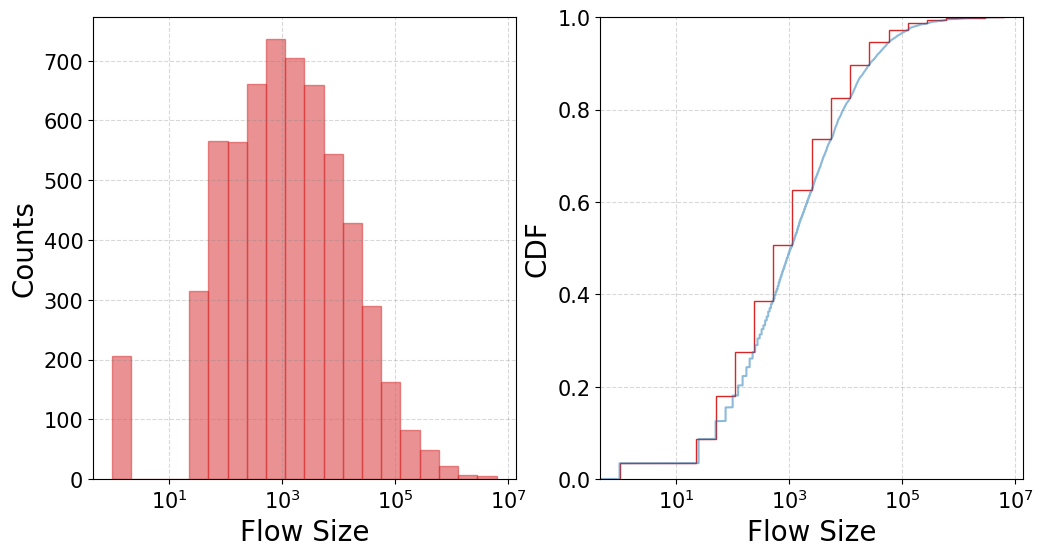

Characteristics of Interarrival Time distribution: DescribeResult(nobs=5999, minmax=(0.000882086005731253, 64.70100854277916), mean=5.54812806301049, variance=37.38524308974187, skewness=2.3902219225555887, kurtosis=9.568868173726429)


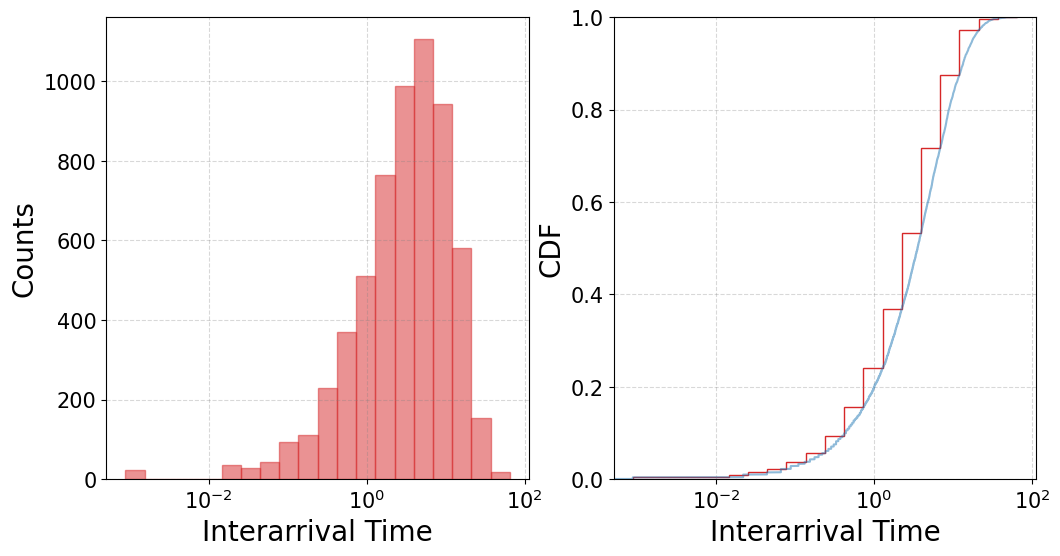

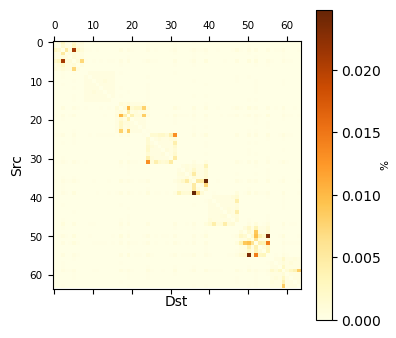

<Figure size 640x480 with 0 Axes>

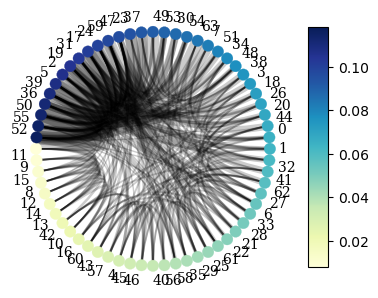

<Figure size 640x480 with 0 Axes>

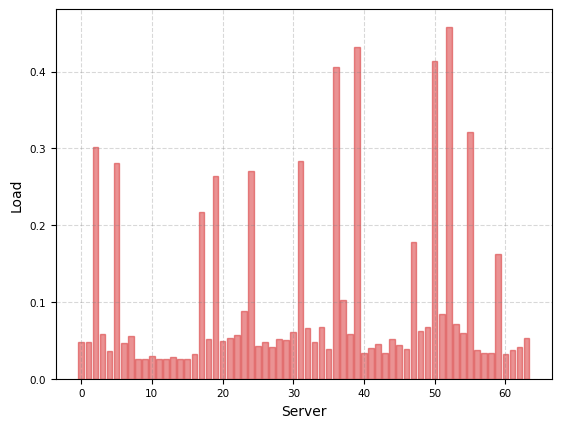

<Figure size 640x480 with 0 Axes>

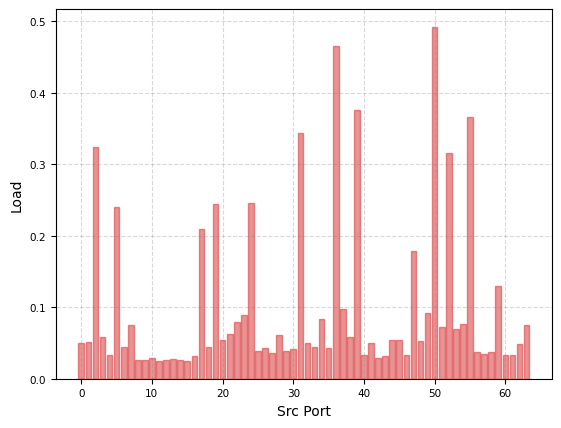

<Figure size 640x480 with 0 Axes>

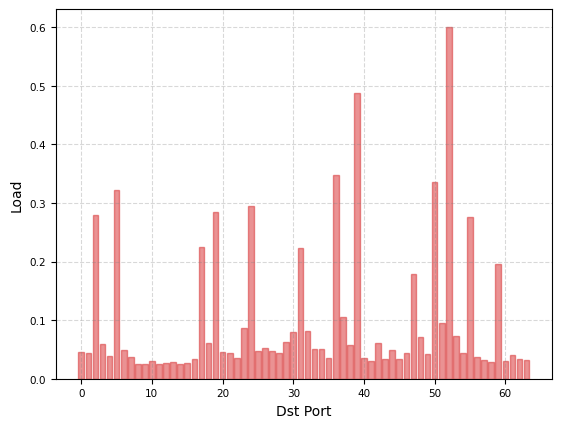

private_enterprise
Characteristics of Flow Size distribution: DescribeResult(nobs=6000, minmax=(1.0, 9528175.0), mean=25392.989333333335, variance=37496650334.47063, skewness=26.48732917287012, kurtosis=1063.0925572544327)


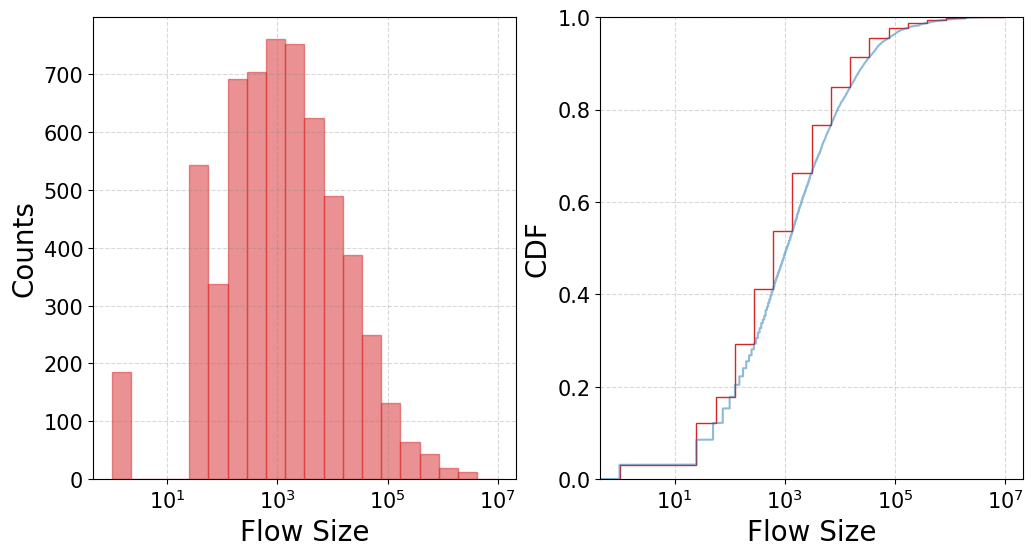

Characteristics of Interarrival Time distribution: DescribeResult(nobs=5999, minmax=(0.002361111659411108, 235.40283254172755), mean=6.34930555092532, variance=808.5327831211771, skewness=5.83588890205534, kurtosis=34.754623083050205)


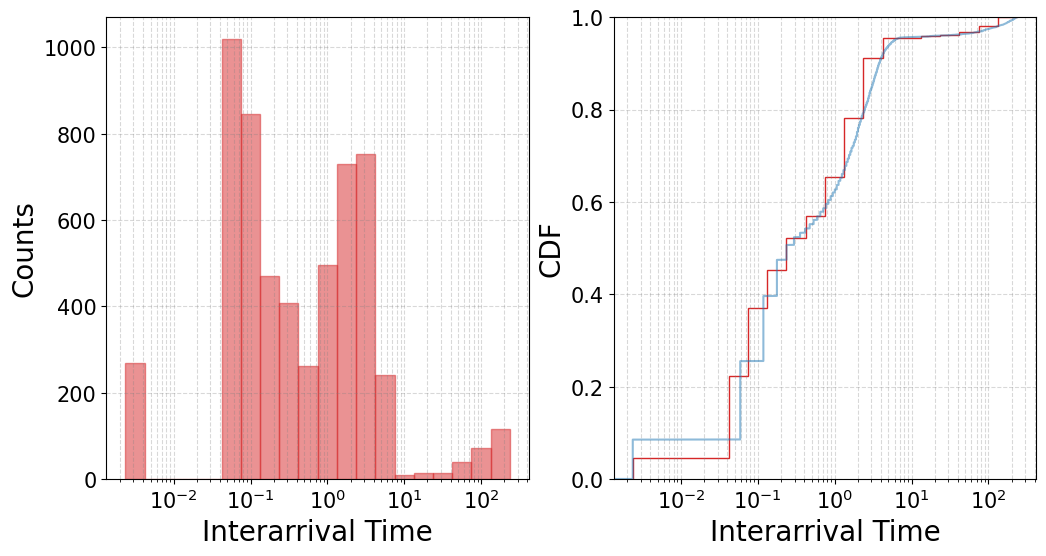

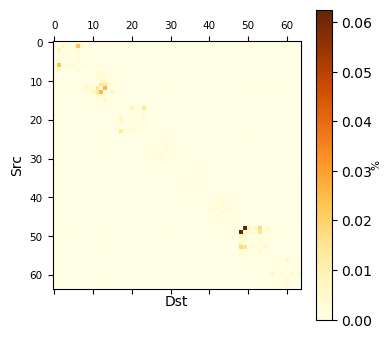

<Figure size 640x480 with 0 Axes>

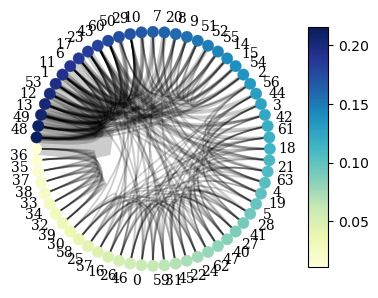

<Figure size 640x480 with 0 Axes>

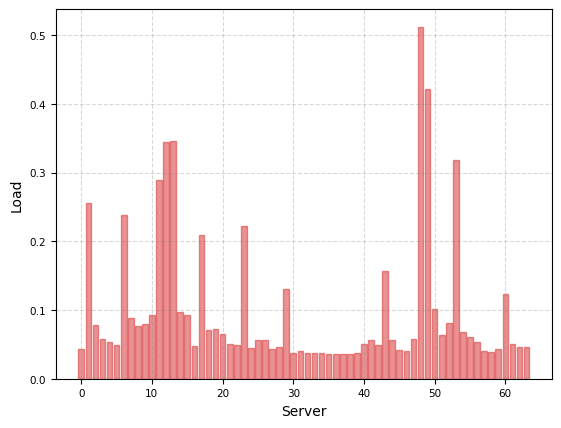

<Figure size 640x480 with 0 Axes>

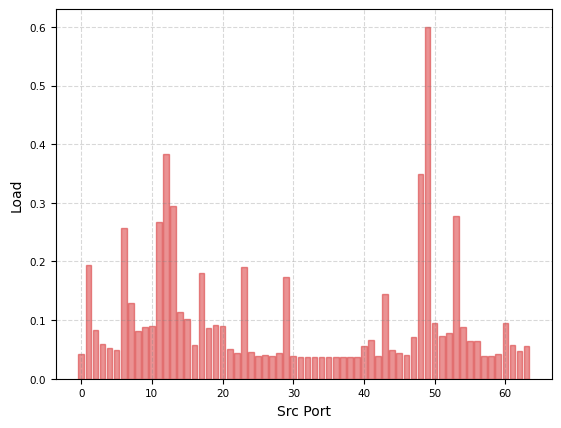

<Figure size 640x480 with 0 Axes>

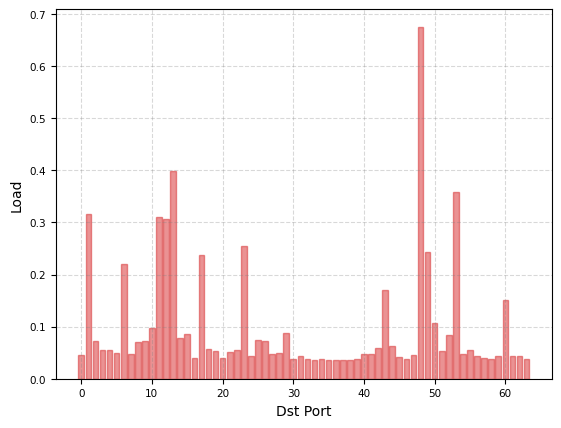

commercial_cloud
Characteristics of Flow Size distribution: DescribeResult(nobs=6000, minmax=(1.0, 6292500.0), mean=20163.113166666666, variance=16839181994.35709, skewness=26.792861430625113, kurtosis=1060.096498569307)


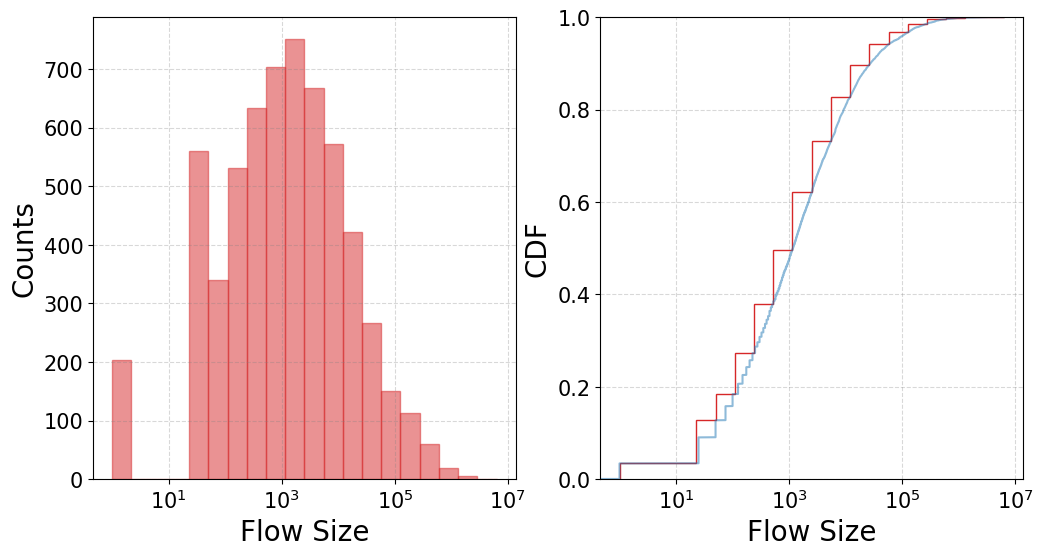

Characteristics of Interarrival Time distribution: DescribeResult(nobs=5999, minmax=(0.05694507785301539, 559.4853899189457), mean=5.041618561426602, variance=1196.2885401595531, skewness=12.407699403165974, kurtosis=161.40050617228735)


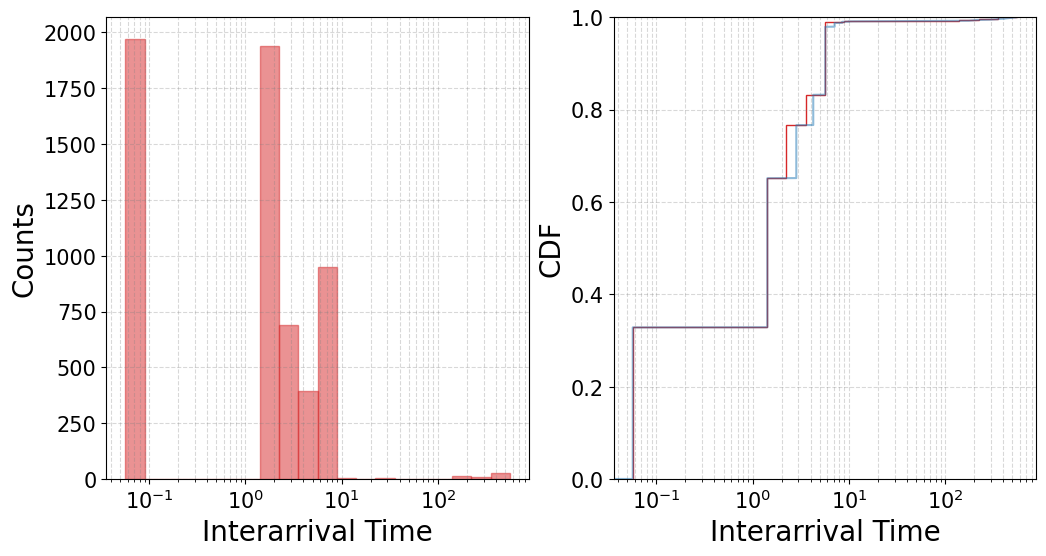

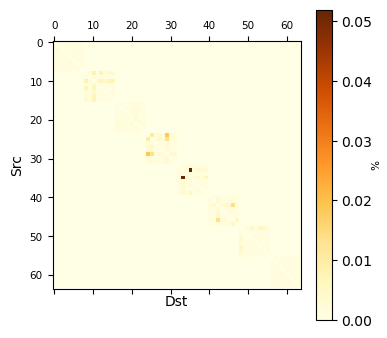

<Figure size 640x480 with 0 Axes>

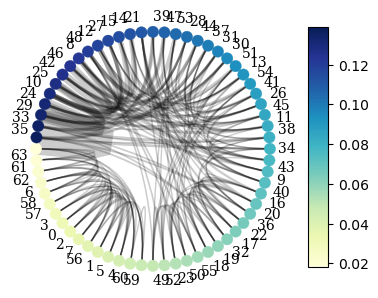

<Figure size 640x480 with 0 Axes>

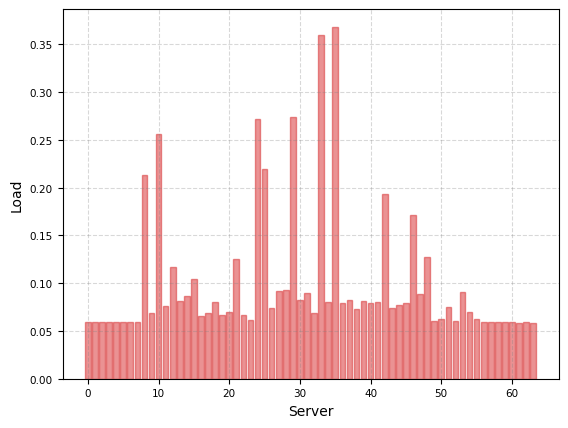

<Figure size 640x480 with 0 Axes>

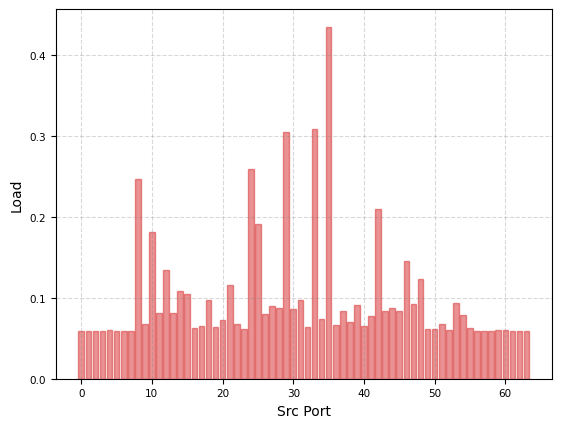

<Figure size 640x480 with 0 Axes>

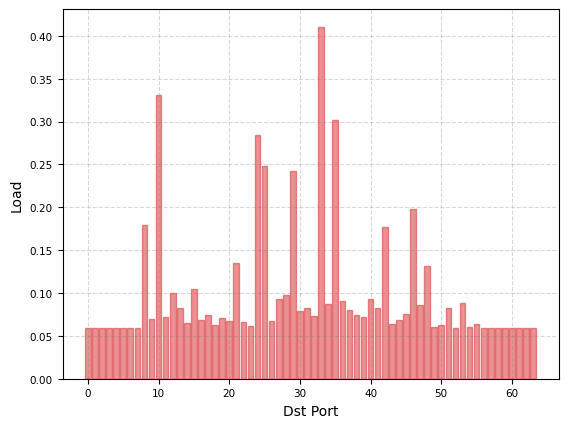

social_media_cloud
Characteristics of Flow Size distribution: DescribeResult(nobs=6000, minmax=(1.0, 1528875.0), mean=41967.719666666664, variance=9126289120.436487, skewness=5.893133419913156, kurtosis=52.637209361052165)


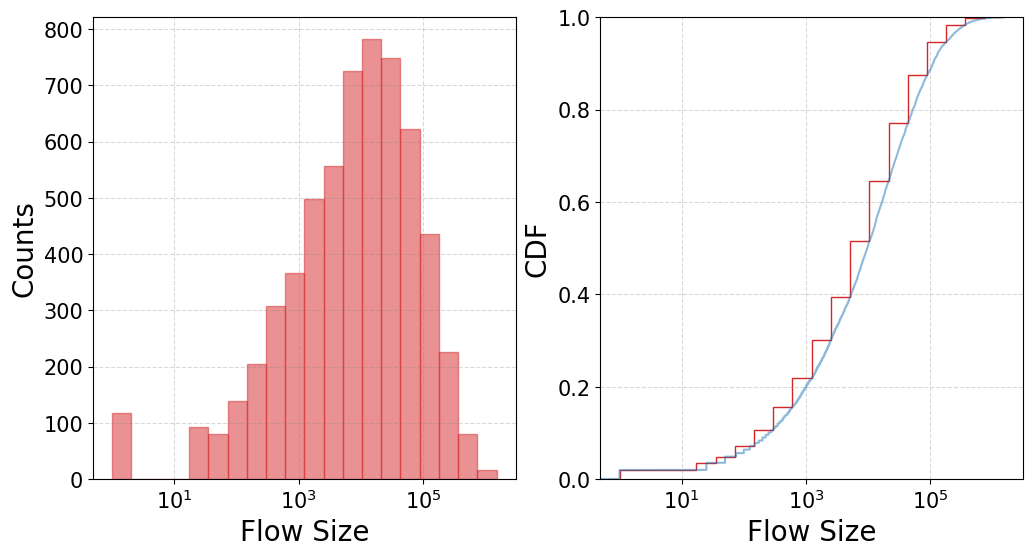

Characteristics of Interarrival Time distribution: DescribeResult(nobs=5999, minmax=(0.0019305126552353613, 4453.113545386623), mean=10.493678863143732, variance=5642.44043959452, skewness=38.07646562828407, kurtosis=2079.084793966626)


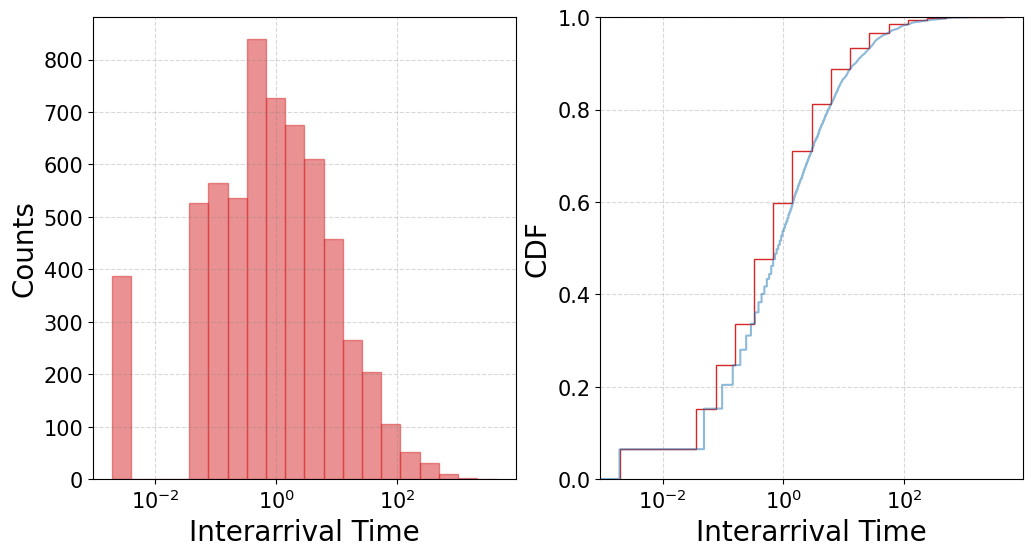

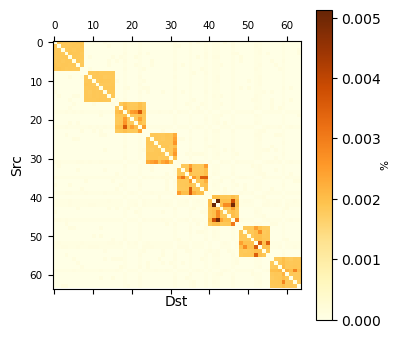

<Figure size 640x480 with 0 Axes>

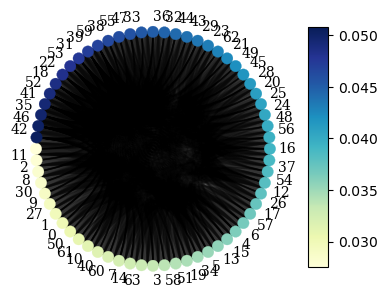

<Figure size 640x480 with 0 Axes>

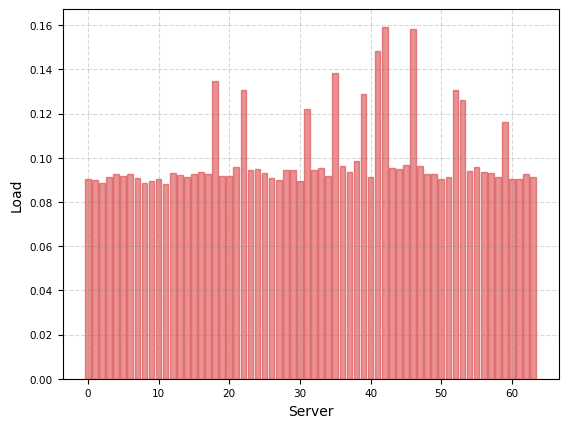

<Figure size 640x480 with 0 Axes>

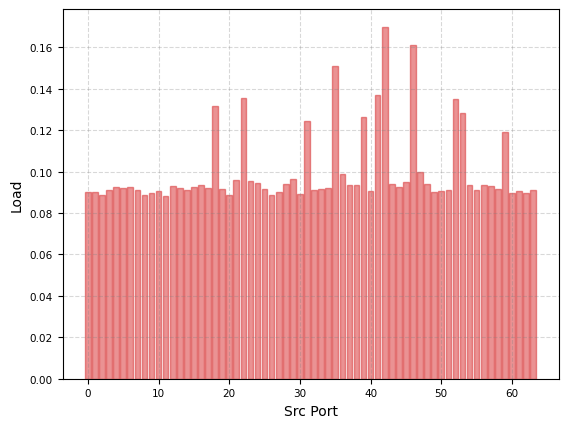

<Figure size 640x480 with 0 Axes>

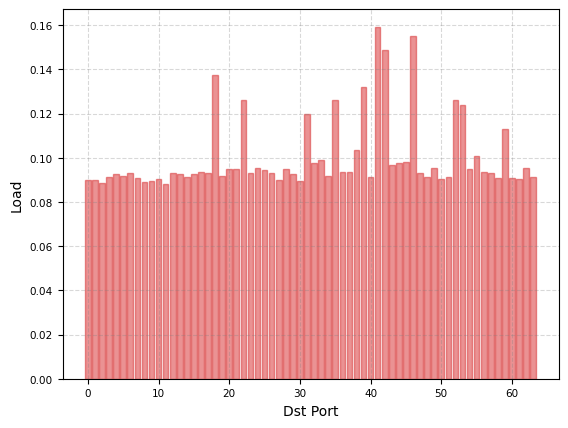

In [18]:
# visualise distributions
for dcn, demand in demands.items():
    print(dcn)
    plotter = DemandPlotter(demand)
    plotter.plot_flow_size_dist(logscale=True, figsize=(12,6))
    plotter.plot_interarrival_time_dist(logscale=True, figsize=(12,6))
    plotter.plot_node_dist(eps=net.graph['endpoints'],
                           chord_edge_width_range=[1,25],
                           chord_edge_display_threshold=0.005)
    plotter.plot_node_load_dists(eps=net.graph['endpoints'], 
                                 ep_link_bandwidth=net.graph['ep_link_capacity'],
                                 plot_extras=False)

# 7. (Optional) Generate a slots dict data base


Many network experiments are based on time slots. I.e. during a time slot of e.g. 10 time units, some number of flows arrive. The `trafpy.generator.Demand()` class has a useful `get_slots_dict()` method to automatically organise your generated traffic demands into time slots given the `slot_size` you want to use:

In [19]:
slots_dict = demand.get_slots_dict(slot_size=1000)

The `slots_dict` dictionary contains indices 0-n for `n` slots, as well as some other useful information:

In [20]:
print(slots_dict.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 'slot_keys', 'slot_size', 'time_first_demand_arrived', 'time_last_demand_arrived', 'job_centric', 'num_control_deps', 'num_data_deps', 'num_flows', 'num_demands'])


E.g. To access the flows which arrived in the first time slot (with upper bound and lower bound times on the time slot also given since this is often useful):

In [21]:
print(slots_dict[0])

{'lb_time': 0.0, 'ub_time': 1000.0, 'new_event_dicts': [{'flow_id': 'flow_857', 'unique_id': 'flow_857', 'size': 77375.0, 'src': '54', 'dst': '48', 'establish': 1, 'parent_deps': None, 'completed_parent_deps': [], 'child_deps': None, 'parent_op_run_time': None, 'time_parent_op_started': None, 'parent_op': None, 'dependency_type': None, 'child_op': None, 'can_schedule': 1, 'job_id': None, 'path': None, 'channel': None, 'packets': None, 'packet_size': None, 'packets_this_slot': 0, 'time_arrived': 0.0, 'time_completed': None, 'k_shortest_paths': None}, {'flow_id': 'flow_318', 'unique_id': 'flow_318', 'size': 183525.0, 'src': '56', 'dst': '63', 'establish': 1, 'parent_deps': None, 'completed_parent_deps': [], 'child_deps': None, 'parent_op_run_time': None, 'time_parent_op_started': None, 'parent_op': None, 'dependency_type': None, 'child_op': None, 'can_schedule': 1, 'job_id': None, 'path': None, 'channel': None, 'packets': None, 'packet_size': None, 'packets_this_slot': 0, 'time_arrived':

Next time slot flows:

In [22]:
print(slots_dict[1])

{'lb_time': 1000.0, 'ub_time': 2000.0, 'new_event_dicts': [{'flow_id': 'flow_3025', 'unique_id': 'flow_3025', 'size': 9450.0, 'src': '29', 'dst': '53', 'establish': 1, 'parent_deps': None, 'completed_parent_deps': [], 'child_deps': None, 'parent_op_run_time': None, 'time_parent_op_started': None, 'parent_op': None, 'dependency_type': None, 'child_op': None, 'can_schedule': 1, 'job_id': None, 'path': None, 'channel': None, 'packets': None, 'packet_size': None, 'packets_this_slot': 0, 'time_arrived': 1058.6583917484754, 'time_completed': None, 'k_shortest_paths': None}, {'flow_id': 'flow_2759', 'unique_id': 'flow_2759', 'size': 12275.0, 'src': '35', 'dst': '3', 'establish': 1, 'parent_deps': None, 'completed_parent_deps': [], 'child_deps': None, 'parent_op_run_time': None, 'time_parent_op_started': None, 'parent_op': None, 'dependency_type': None, 'child_op': None, 'can_schedule': 1, 'job_id': None, 'path': None, 'channel': None, 'packets': None, 'packet_size': None, 'packets_this_slot':

And so on.

For large simulations, it is recommended to save the `slots_dict` as a database on your disk which you can query during your simulation. The `SqliteDict` library is particularly useful for this since it lets you save a database in .sqlite file format whilst still allowing you to query the database as if it were a normal Python dictionary. See [here](https://pypi.org/project/sqlitedict/) for more details.

To save your `slots_dict` as a .sqlite database with `SqliteDict`, run:

In [23]:
from sqlitedict import SqliteDict
import json

with SqliteDict(path_to_data+'{}_demand_data_slots_dict.sqlite'.format(dcn)) as _slots_dict:
    for key, val in slots_dict.items():
        if type(key) is not str:
            _slots_dict[json.dumps(key)] = val
        else:
            _slots_dict[key] = val
    _slots_dict.commit()
    _slots_dict.close()